In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 2000
pd.options.display.max_rows = 200

import missingno as msno
from sys import getsizeof

# Functions used in Preprocessing

In [2]:
def partition(p_List, partitions):
    for i in range(0, len(p_List), partitions):
        yield p_List[i:i + partitions]

In [3]:
def success_rates(_df, _feature, _target="default"):
    """
    Attributes
    ----------
    _df: pandas DataFrame.
    _feature: string, categorical feature name.
    _target: string, binary feature, usually target.
    
    Returns
    -------
    Dictionary with Feature: Success Rate ([0,1] range) pairs.
    """
    
    _sr_dict = {}
    for i in df[_feature].value_counts().index:
        _sr_dict[i] =(_df.loc[_df[_feature]==i, _target].sum()/(df.loc[df[_feature]==i, _target].shape[0])).round(2)
    
    return _sr_dict

# Feature Descriptions

In [36]:
definitions = pd.read_excel("definitions.xlsx")
definitions

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
5,annual_inc_joint,The combined self-reported annual income provi...
6,application_type,Indicates whether the loan is an individual ap...
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/...


# Load in data (utilizes about 3GB memory)

In [37]:
# 3+ GB memory usage. This will take a couples minutes on a laptop. 
date_cols = ["issue_d", "earliest_cr_line", "last_pymnt_d", "last_credit_pull_d"]
df = pd.read_csv("lending_club.csv", 
                 low_memory=False) 
                 # parse_dates=date_cols, 
                 # date_format="%b-%Y")
df.shape

(2925493, 142)

In [34]:
# df.dropna().shape

In [35]:
# df.info()

In [ ]:
for item in df.columns:
    print()

In [38]:
# Take a sample of 60,000 points. Save to "lending_club_sample.csv" in pwd.
df.sample(60000, random_state=2112).to_csv("lending_club_sample.csv", index=False)

In [54]:
# Take a sample of 20,000 points from the subset of data that do not have status "Fully Paid"
mask = ~df.loan_status.str.contains('Does not meet the credit policy. Status:Fully Paid').fillna(method="ffill")
df.loc[mask, :].sample(20000, random_state=2112).to_csv("lending_club_not_Fully_Paid.csv", index=False)

In [55]:
df.loan_status.value_counts()

loan_status
Fully Paid                                             1497783
Current                                                1031016
Charged Off                                             362548
Late (31-120 days)                                       16154
In Grace Period                                          10028
Late (16-30 days)                                         2719
Issued                                                    2062
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                    433
Name: count, dtype: int64

In [29]:
df = pd.read_csv("lending_club_sample.csv", 
                 low_memory=False) 
                 # parse_dates=date_cols, 
                 # date_format="%b-%Y")

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Columns: 142 entries, Unnamed: 0 to debt_settlement_flag
dtypes: float64(106), int64(2), object(34)
memory usage: 325.0+ MB


# Create our target feature, "default"

In [6]:
df.loan_status.value_counts(dropna=False)

loan_status
Fully Paid                                             153236
Current                                                105764
Charged Off                                             37527
Late (31-120 days)                                       1710
In Grace Period                                           978
Late (16-30 days)                                         275
Does not meet the credit policy. Status:Fully Paid        201
Issued                                                    197
Does not meet the credit policy. Status:Charged Off        71
Default                                                    41
Name: count, dtype: int64

In [27]:
# Target feature
df.dropna(subset=["loan_status"], inplace=True) # getting rid of that 1 missing value
df["default"] = np.where((df.loan_status == "Charged Off") | 
                         (df.loan_status == "Does not meet the credit policy. Status:Charged Off") | 
                         (df.loan_status == "Default"), 
                         1, 0)

In [8]:
df.default.value_counts(dropna=False)

default
0    262361
1     37639
Name: count, dtype: int64

In [9]:
# annual_inc = annual_inc_joint when there are multiple borrowers, it can be dropped.
(df.annual_inc.isnull() == df.annual_inc_joint.isnull()).sum()

21551

In [10]:
df.annual_inc_joint.isnull().sum()

278449

In [11]:
df.shape

(300000, 143)

In [12]:
df.annual_inc_joint.isnull().sum() + (df.annual_inc.isnull() == df.annual_inc_joint.isnull()).sum()

300000

# Remove columns missing more than 20% of their values

In [13]:
df.id.describe()

count    3.000000e+05
mean     9.795035e+07
std      5.113014e+07
min      6.542600e+04
25%      5.922153e+07
50%      1.077885e+08
75%      1.432997e+08
max      1.710018e+08
Name: id, dtype: float64

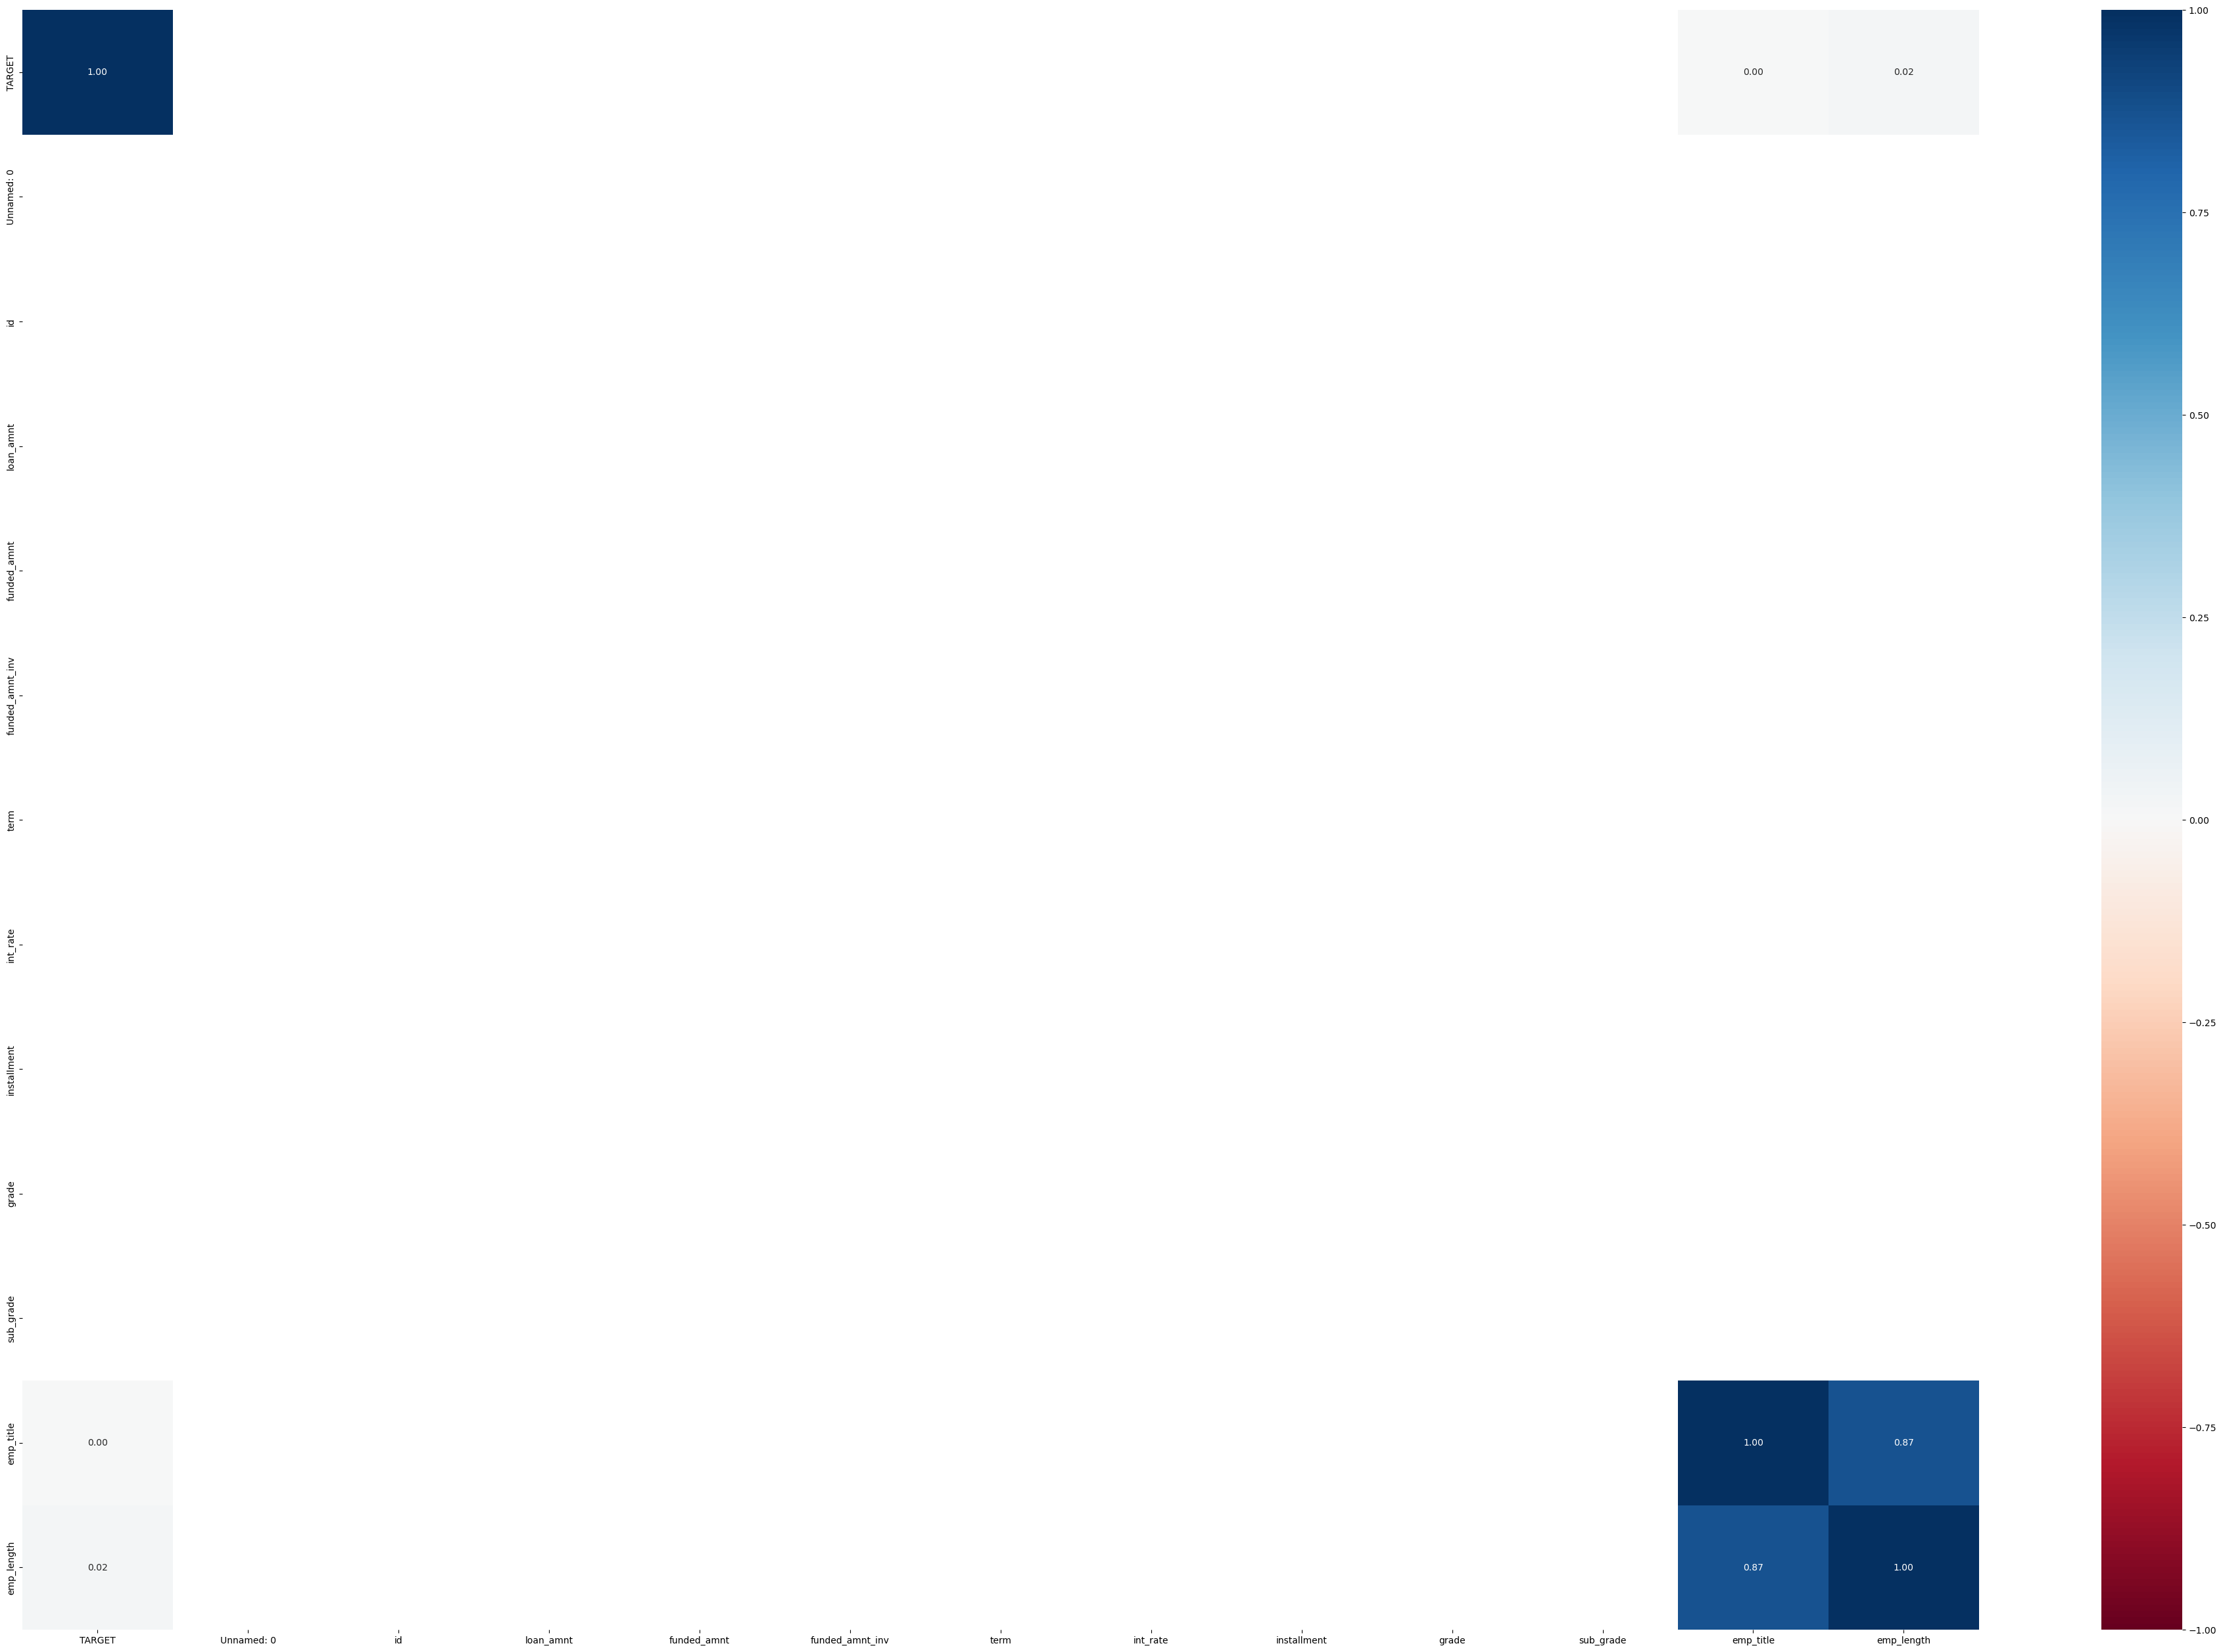

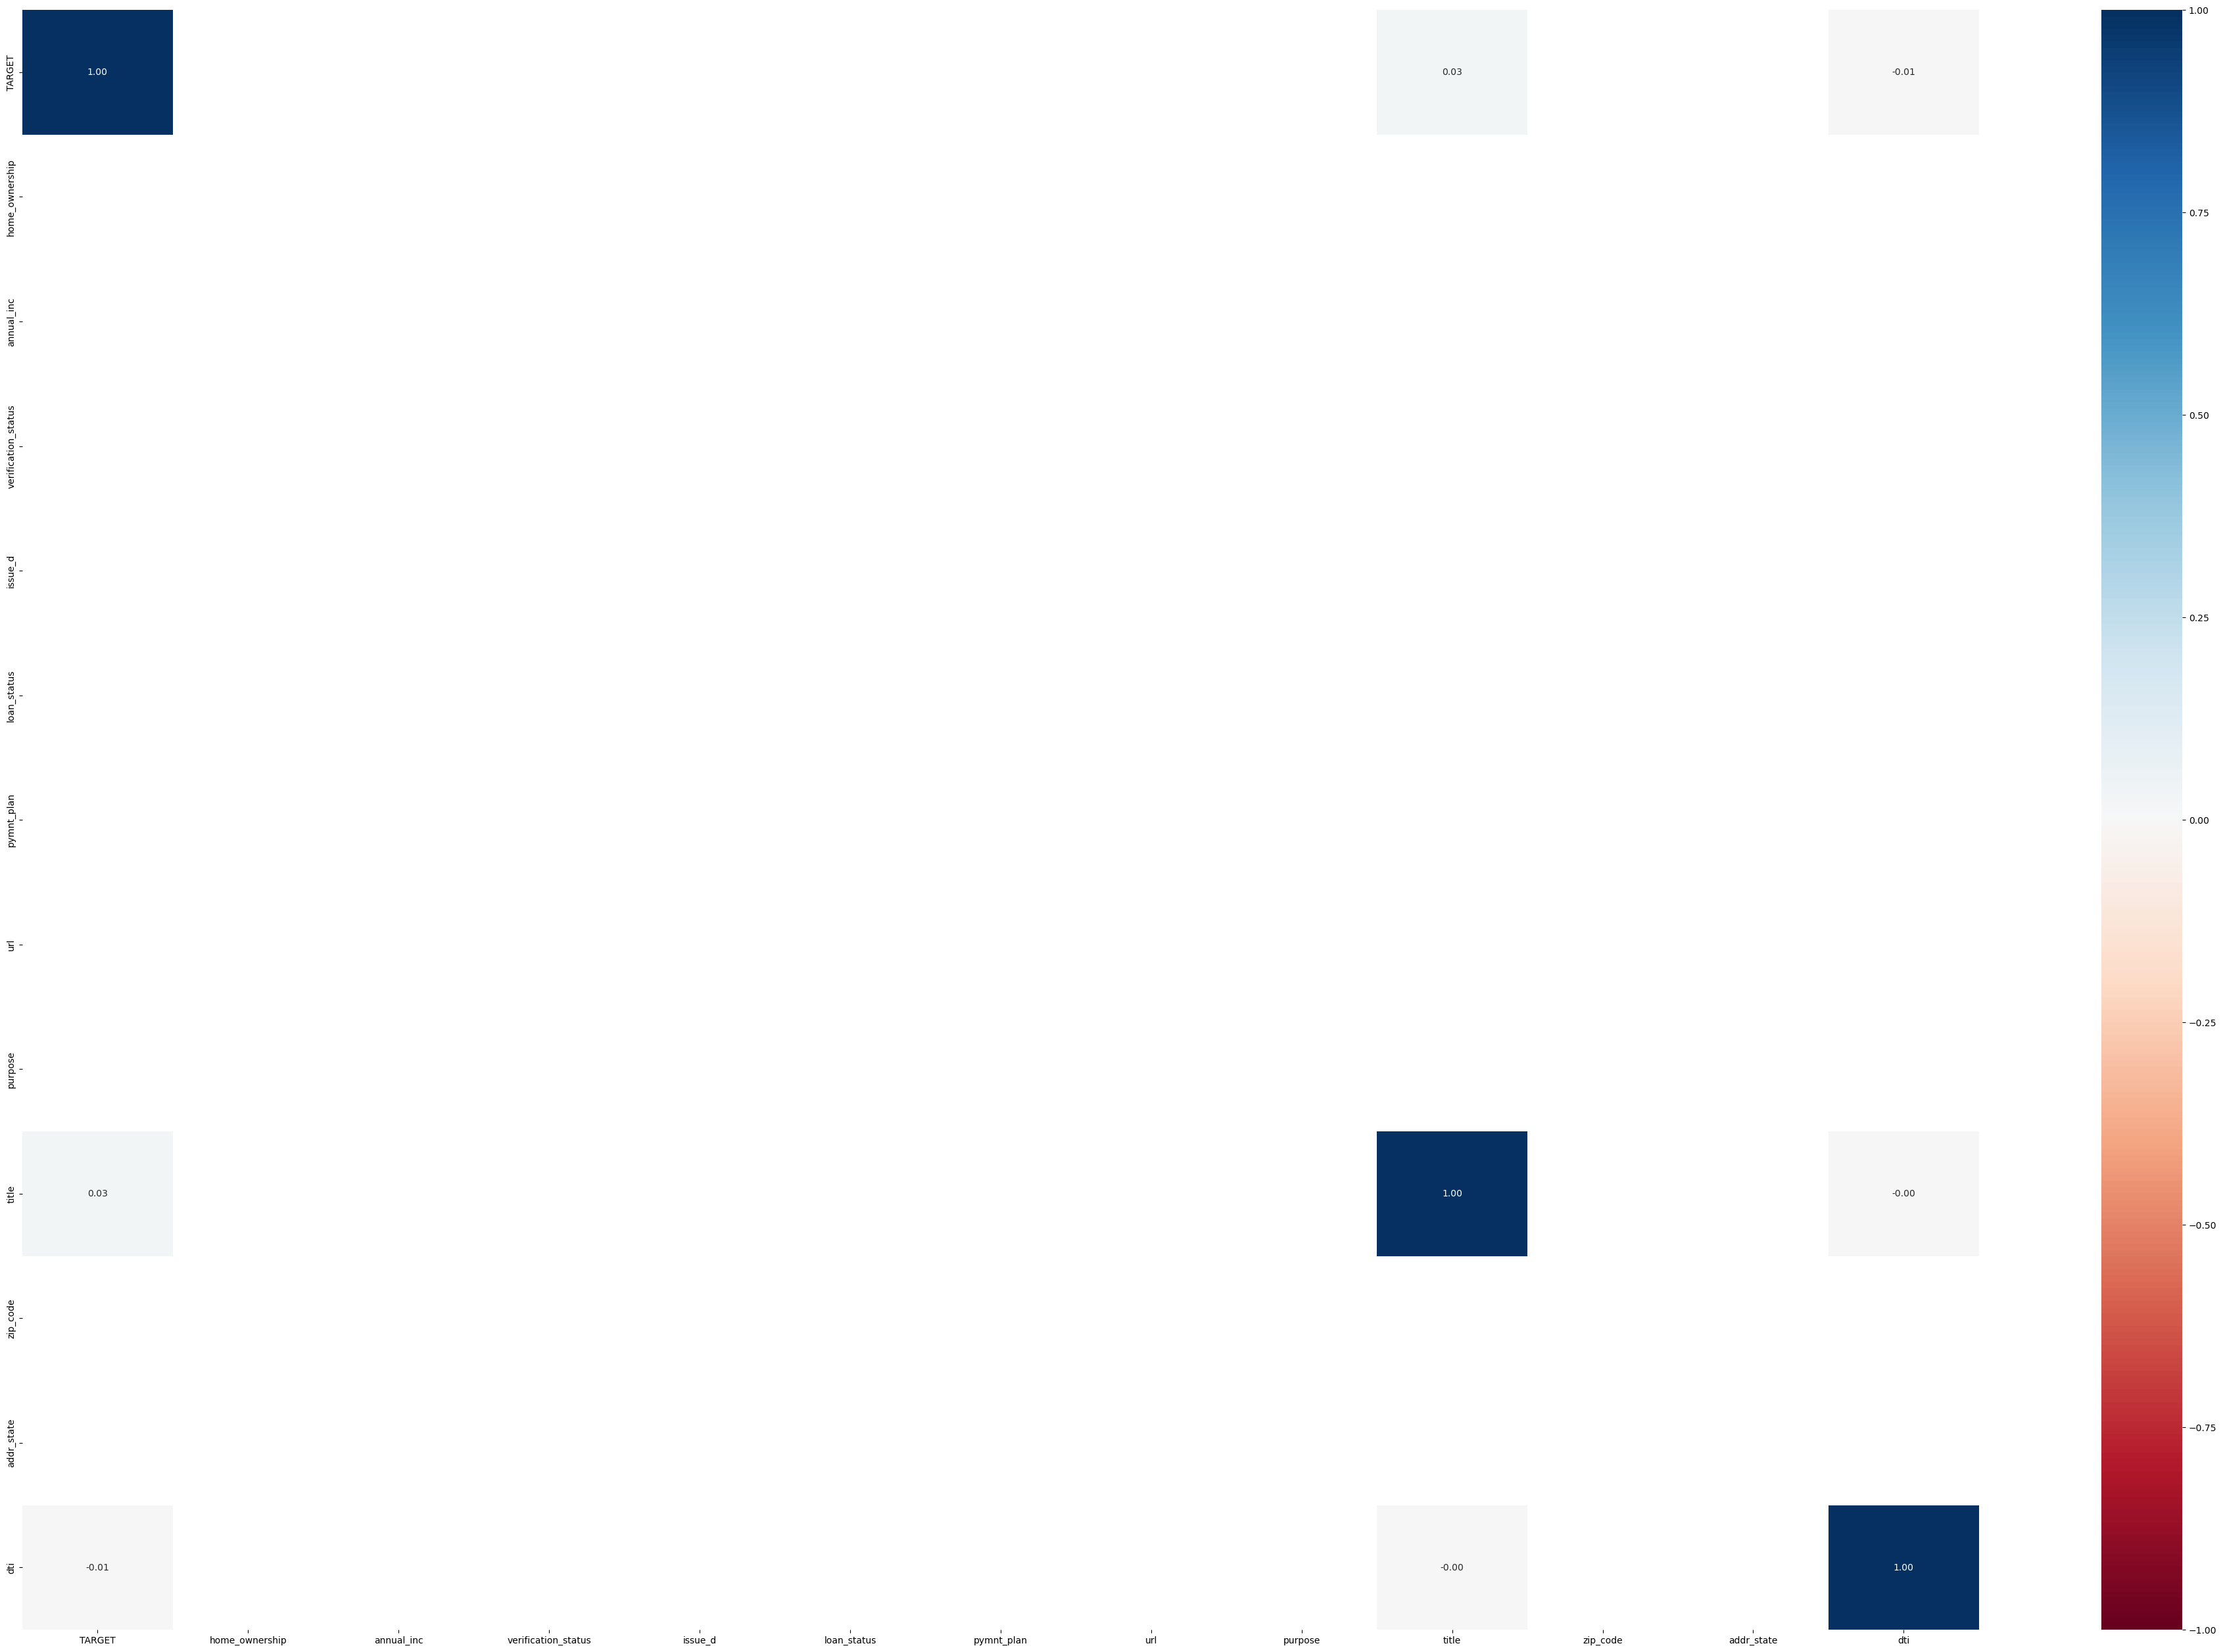

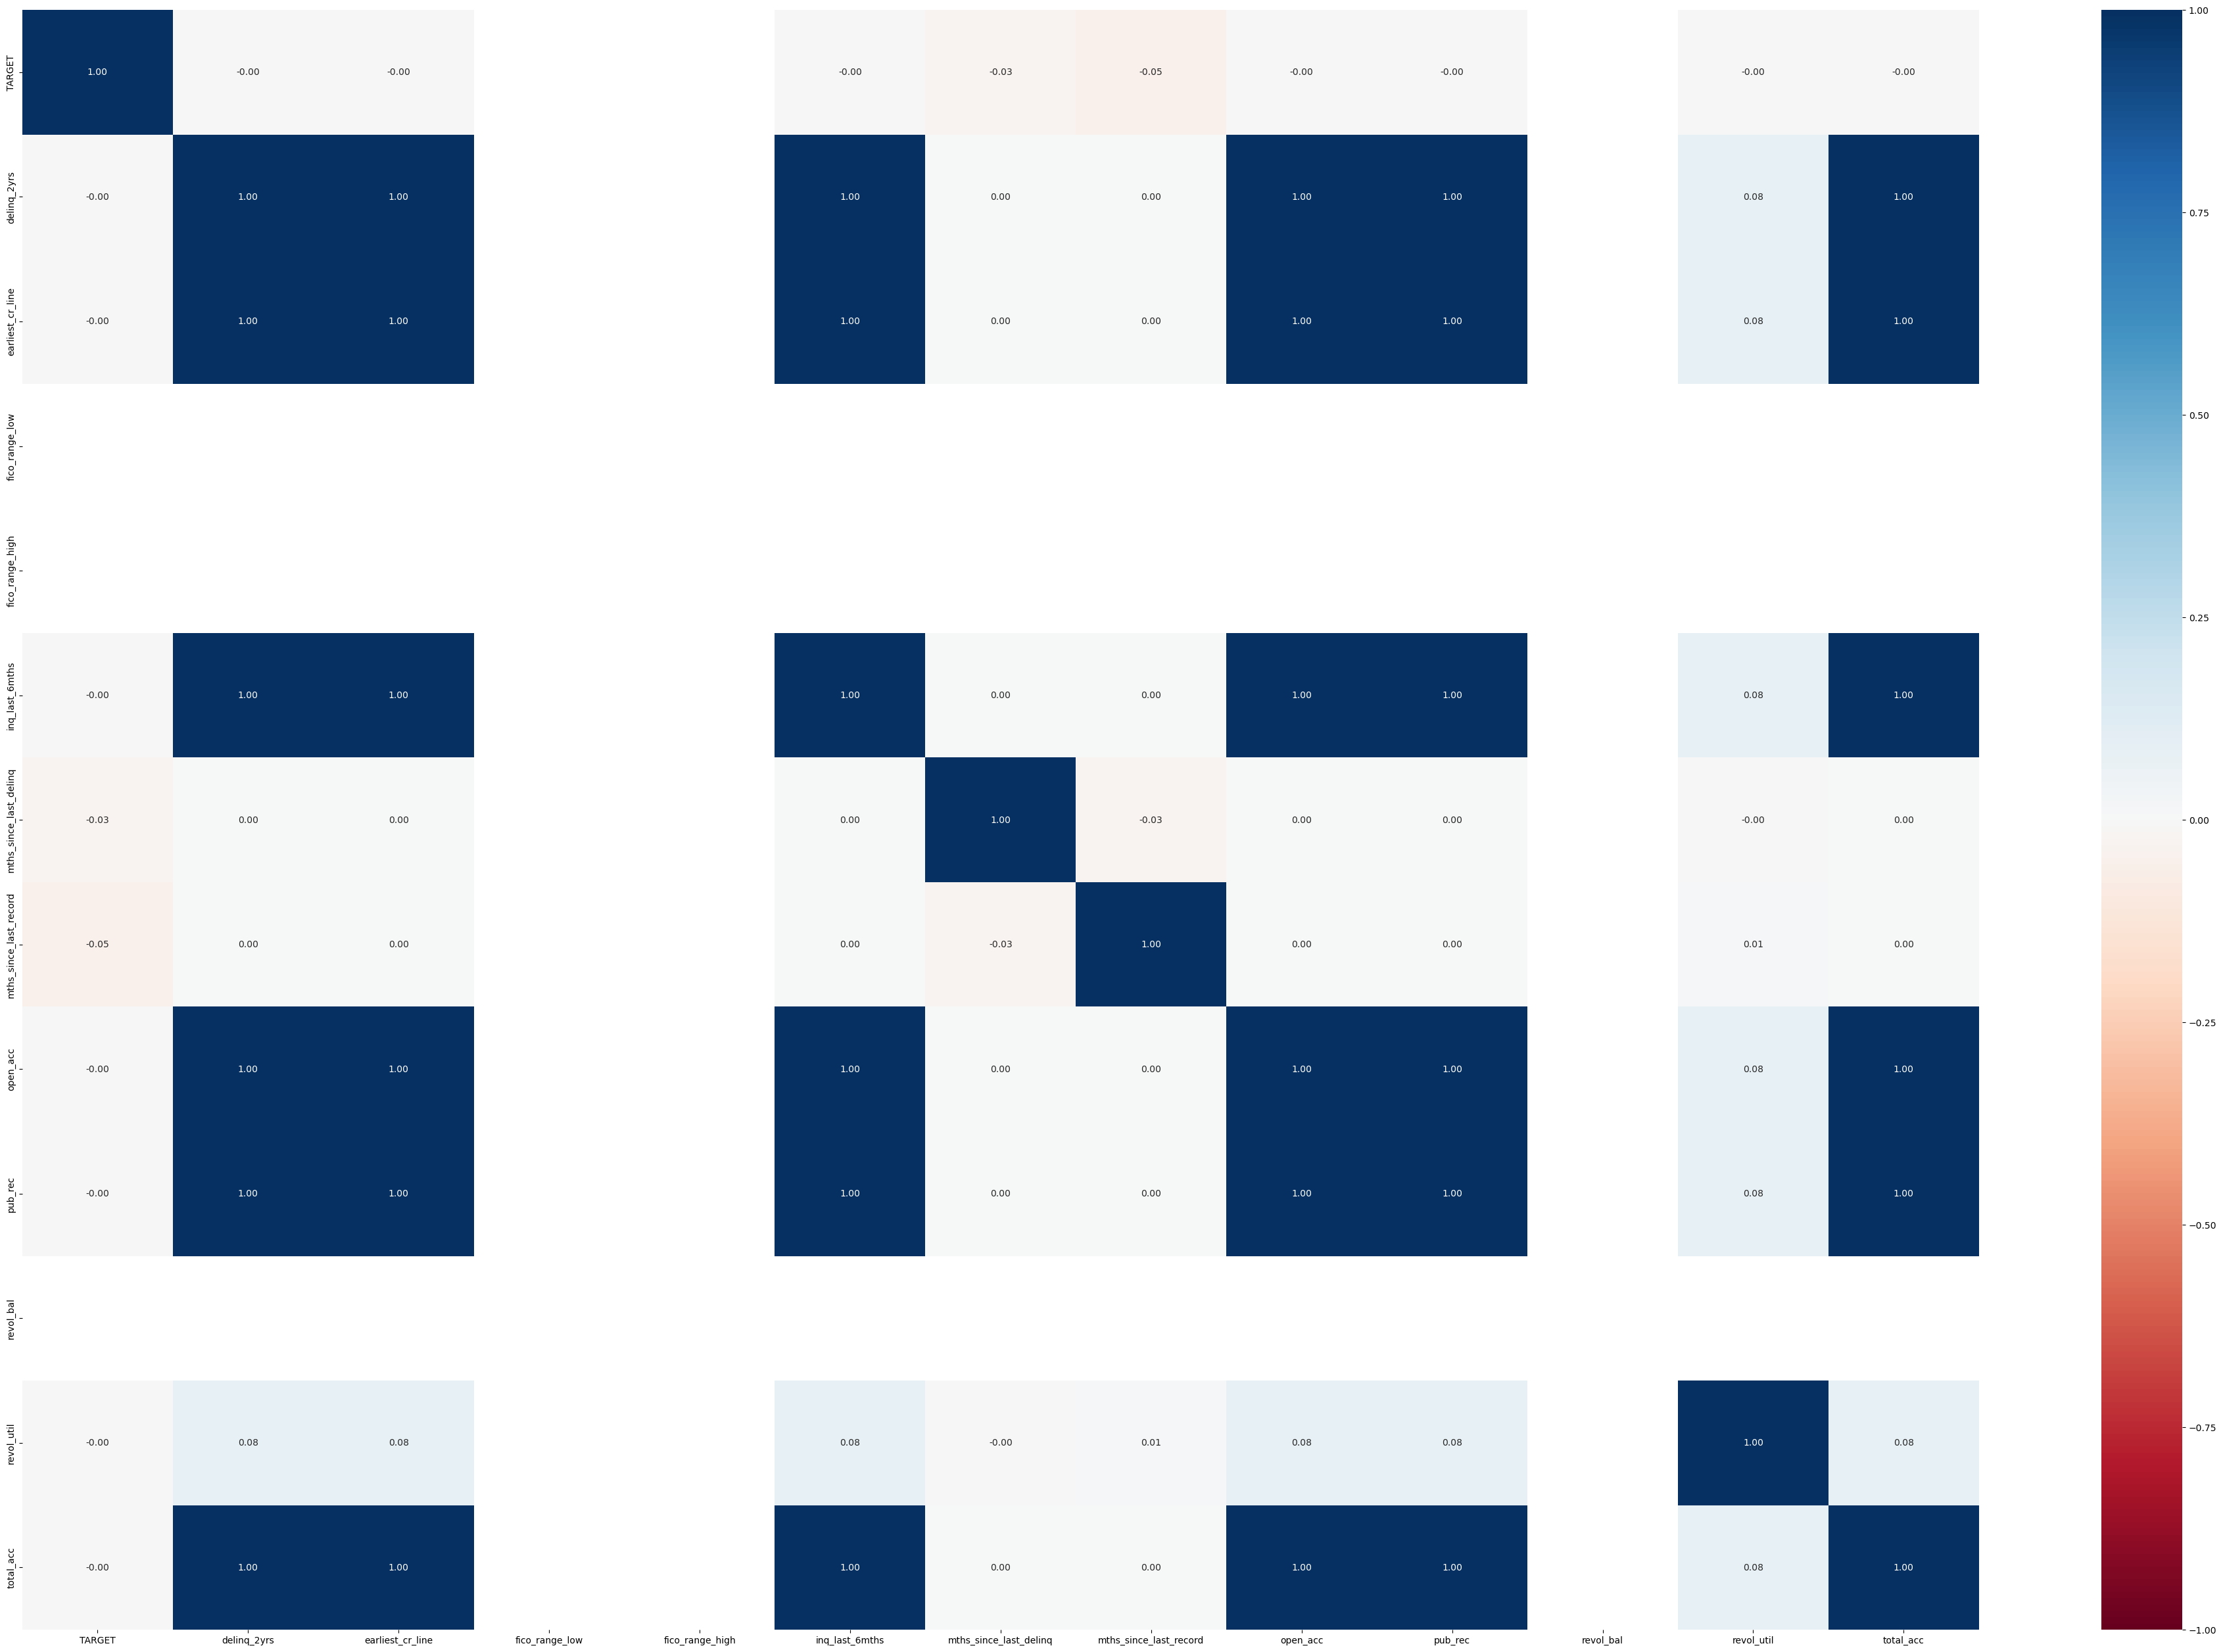

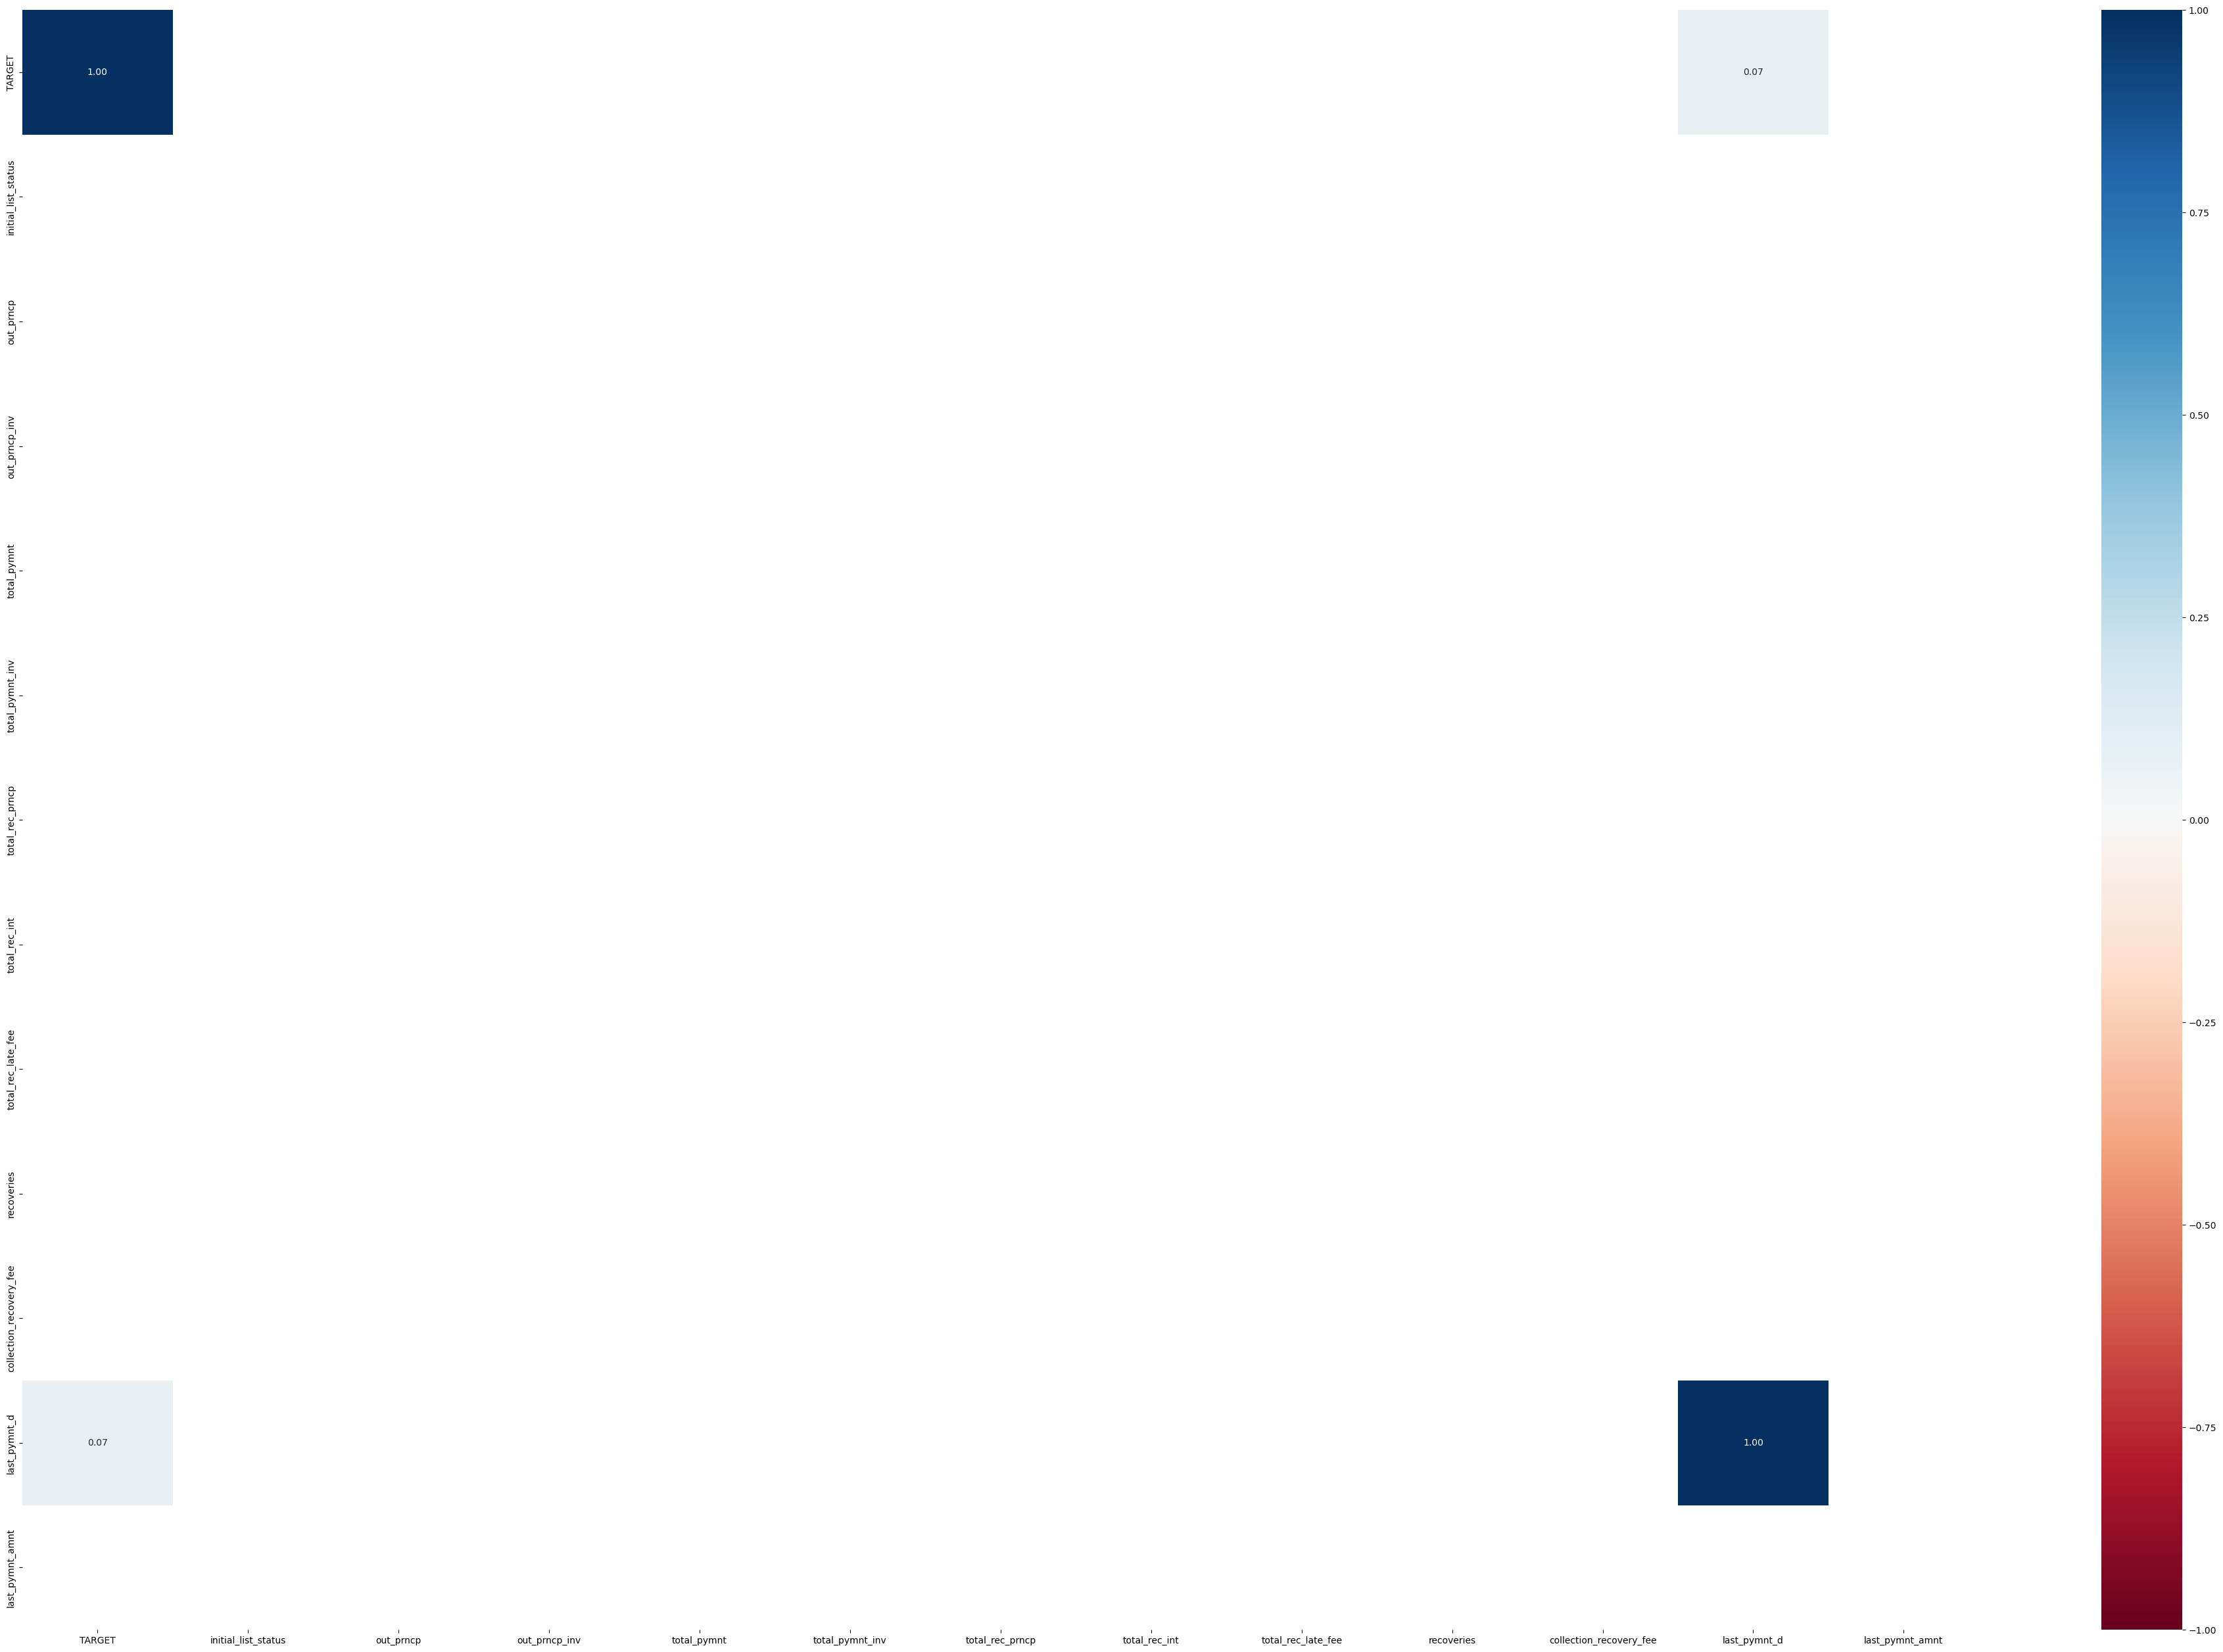

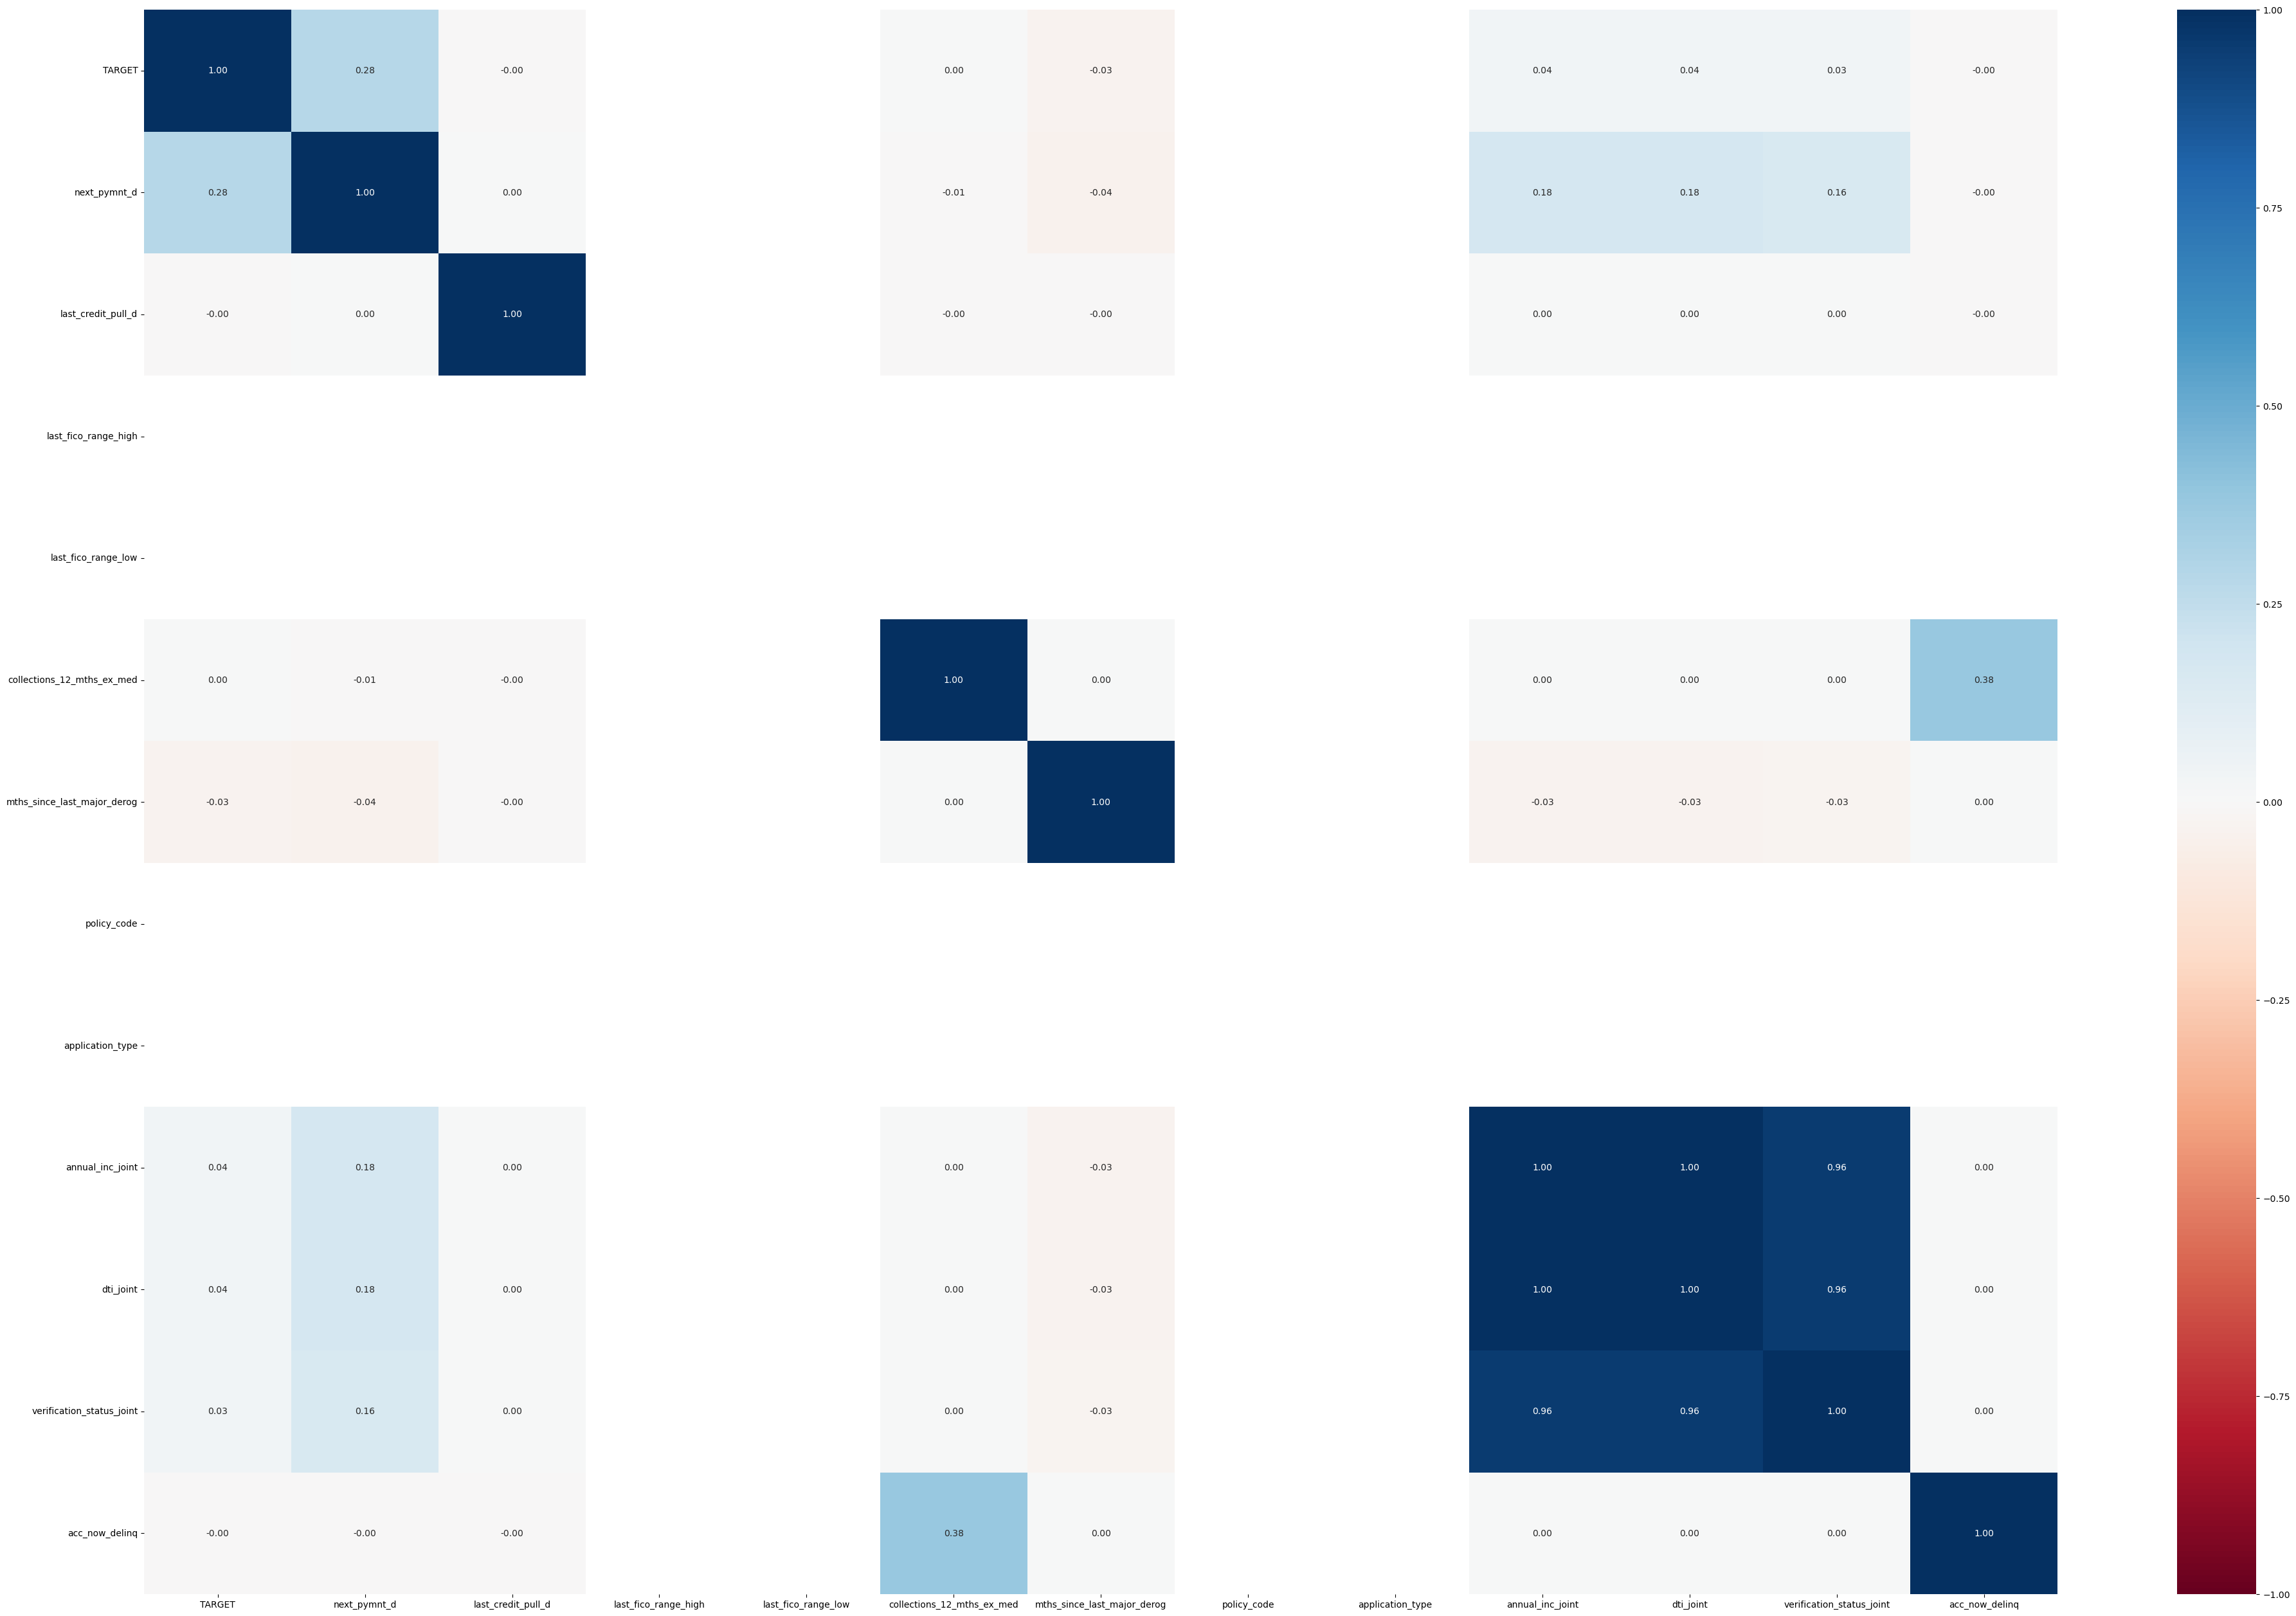

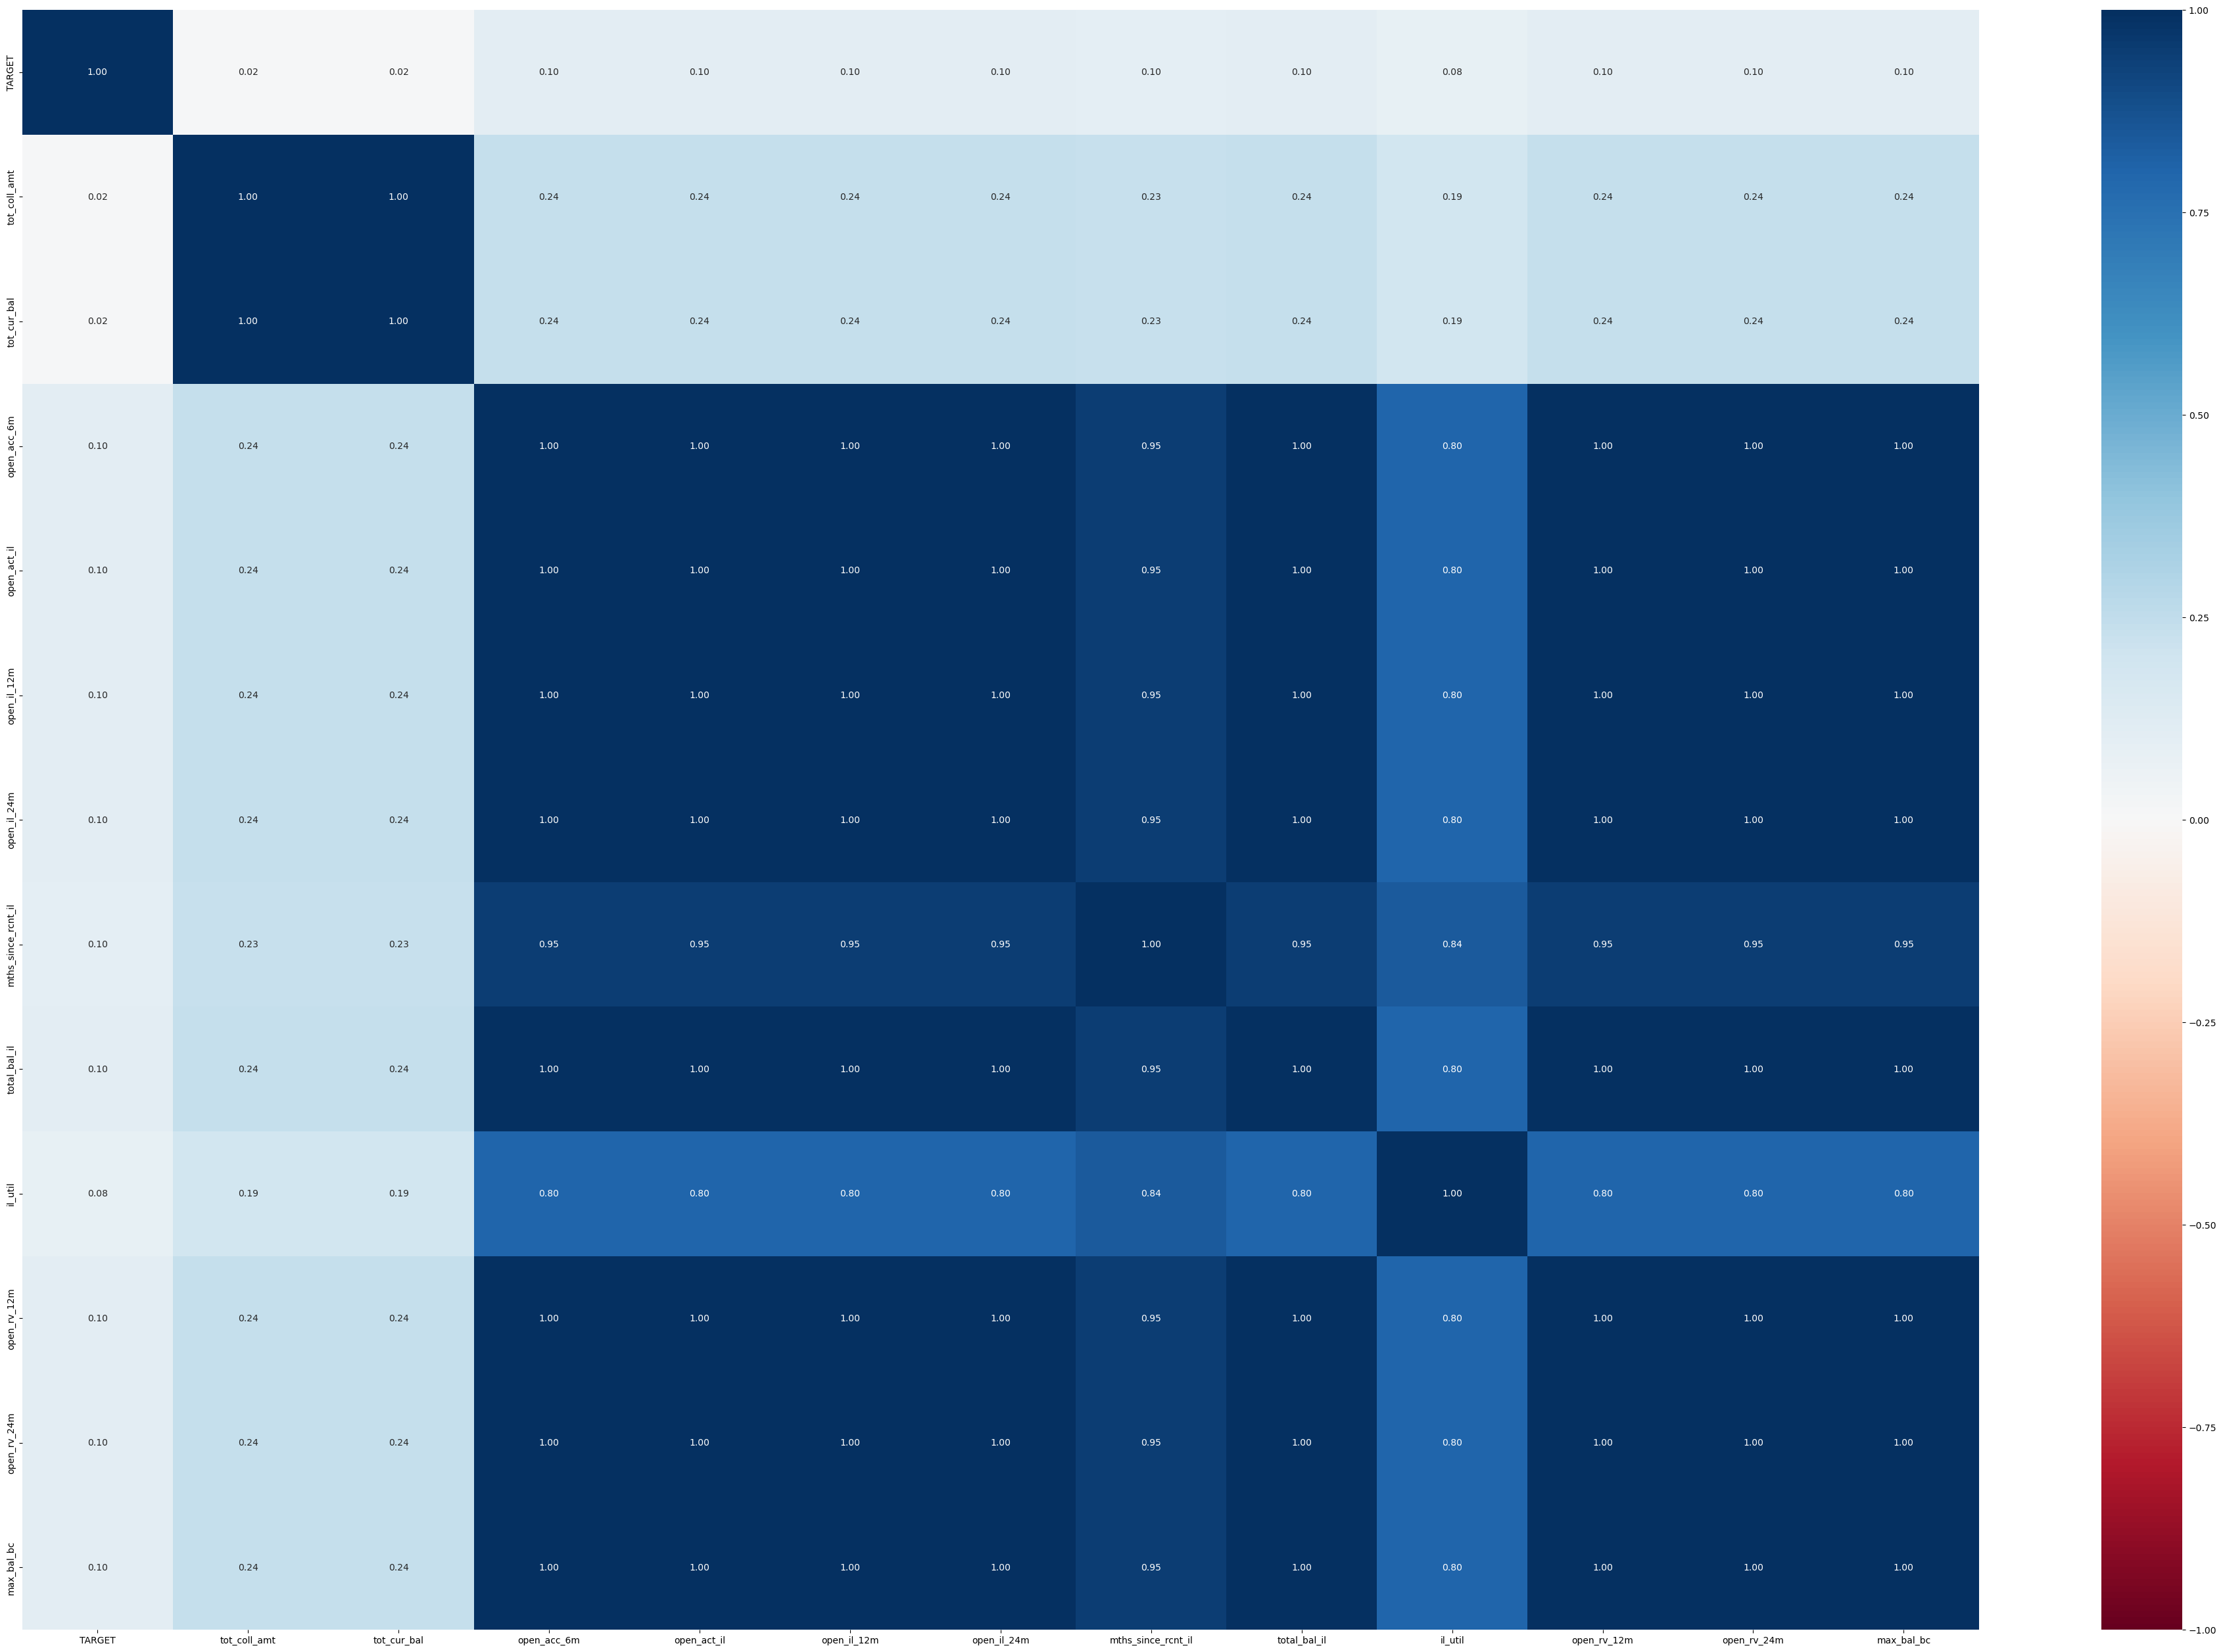

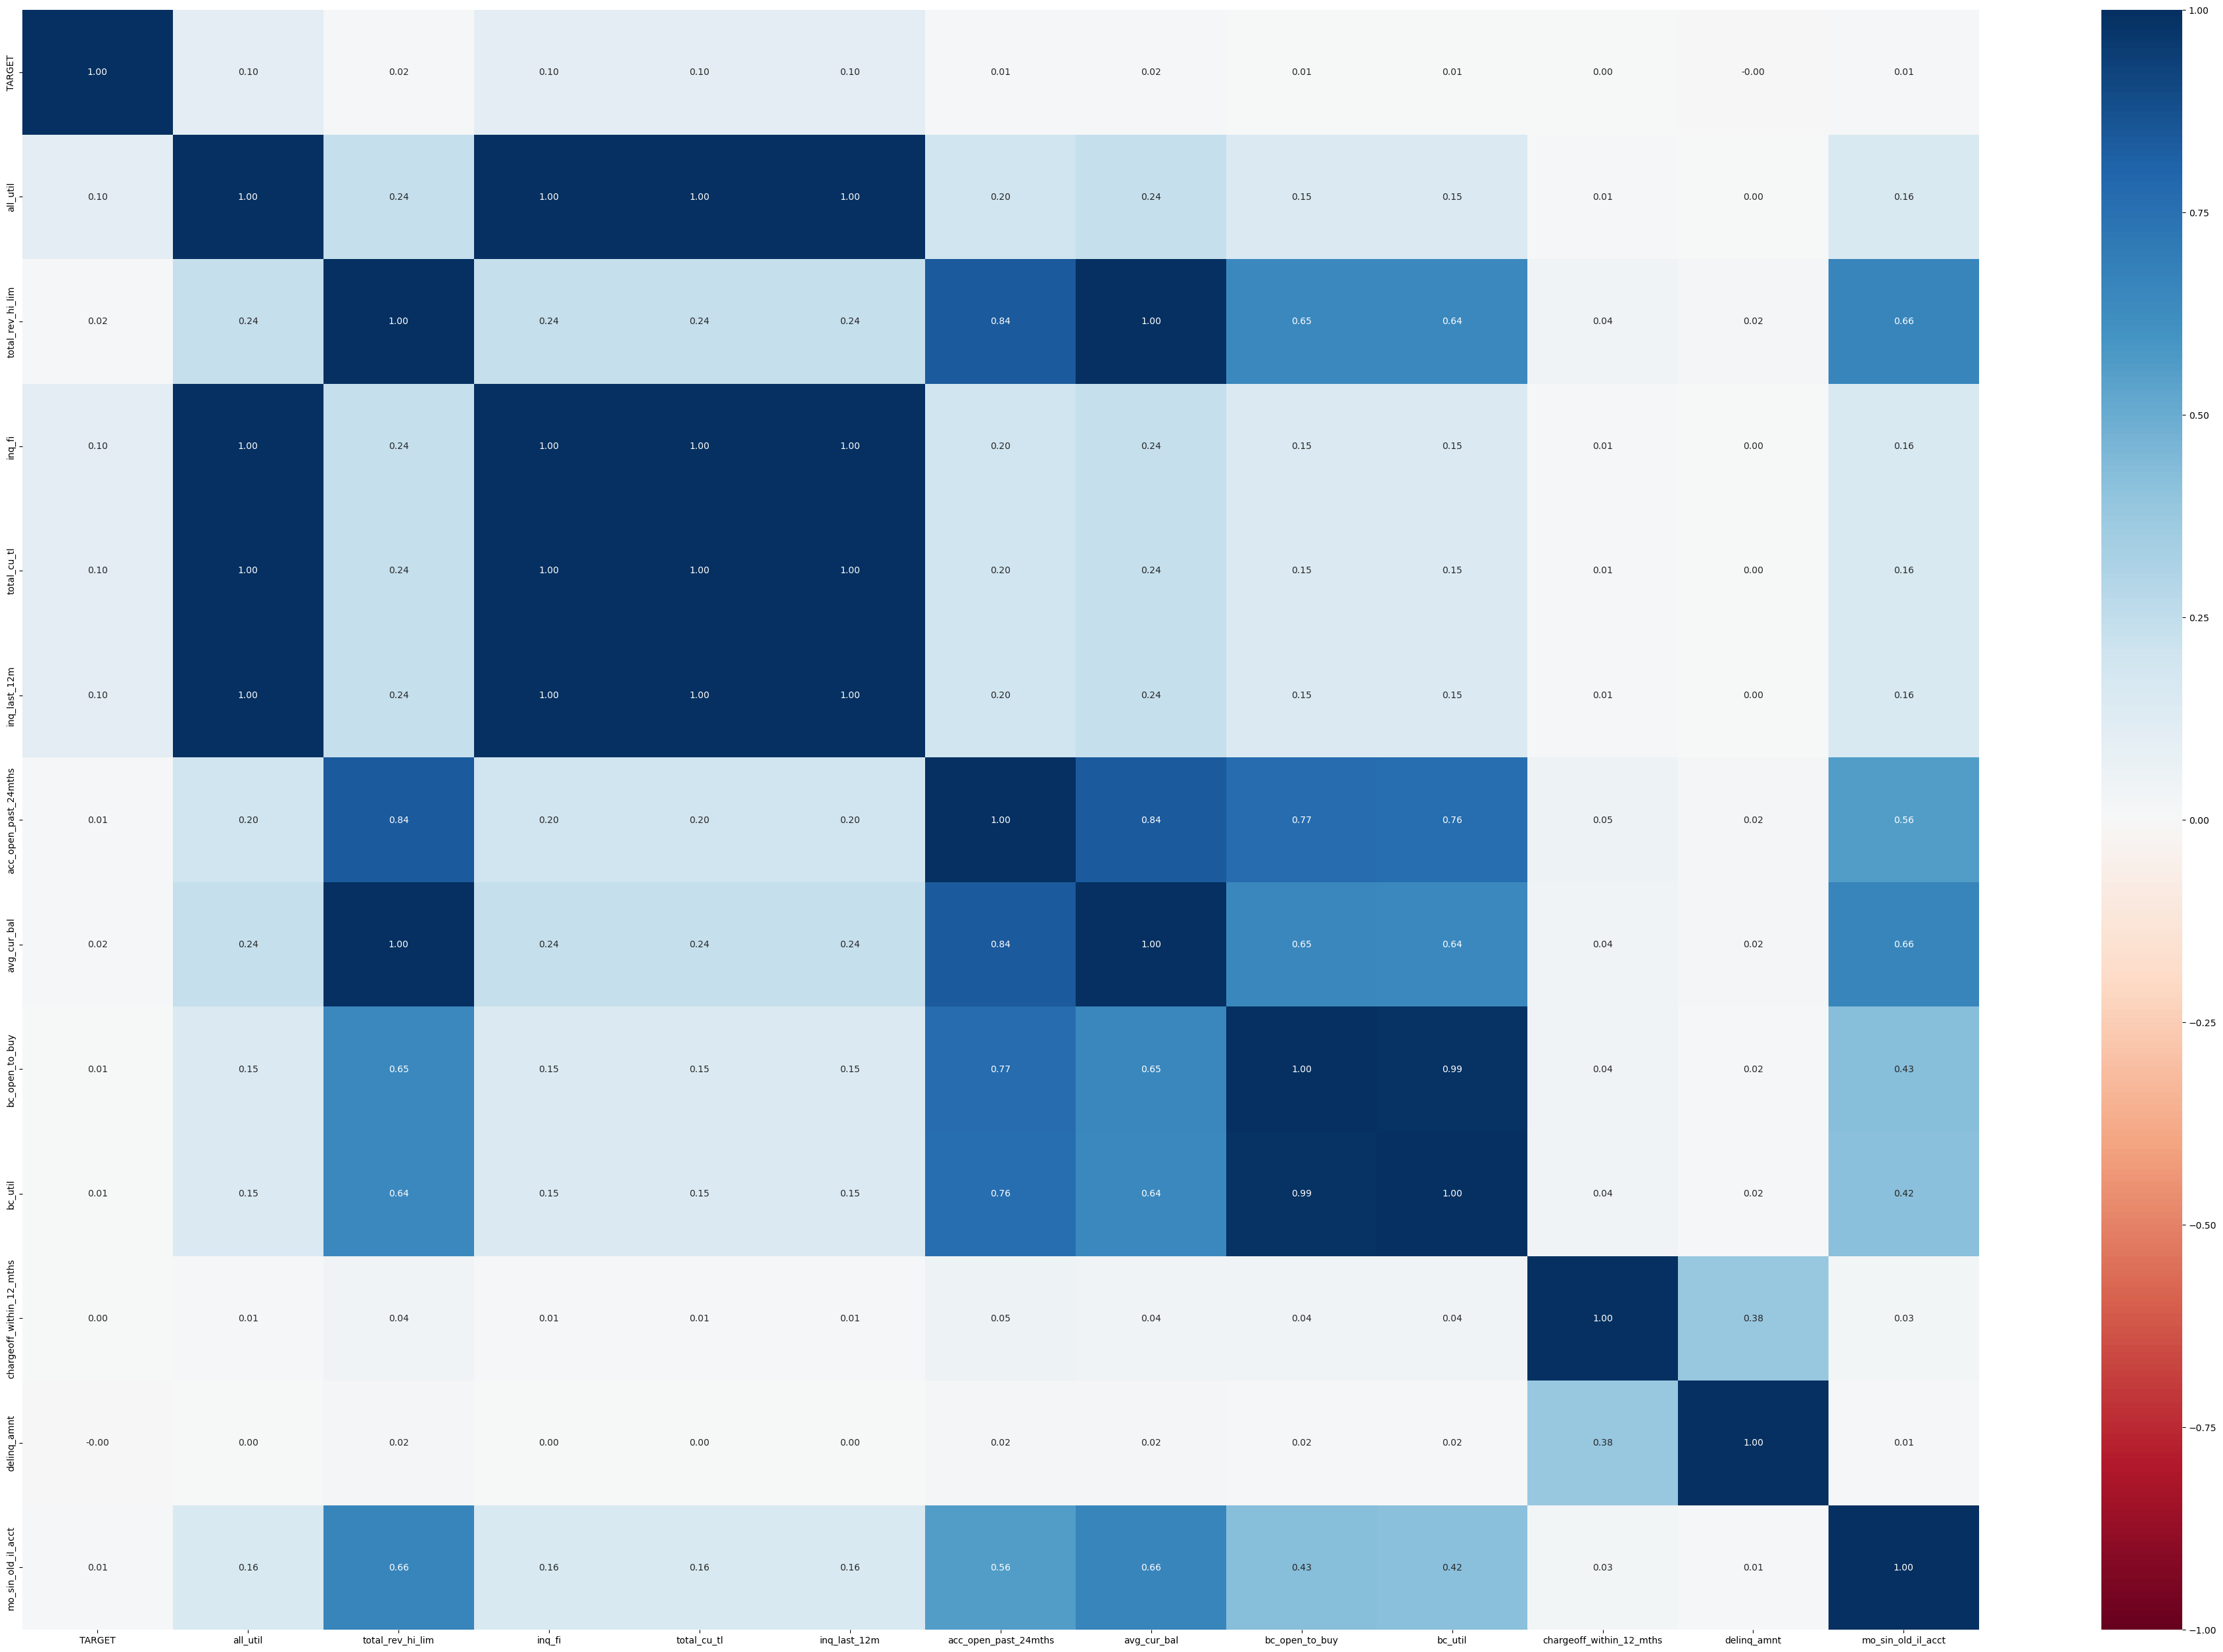

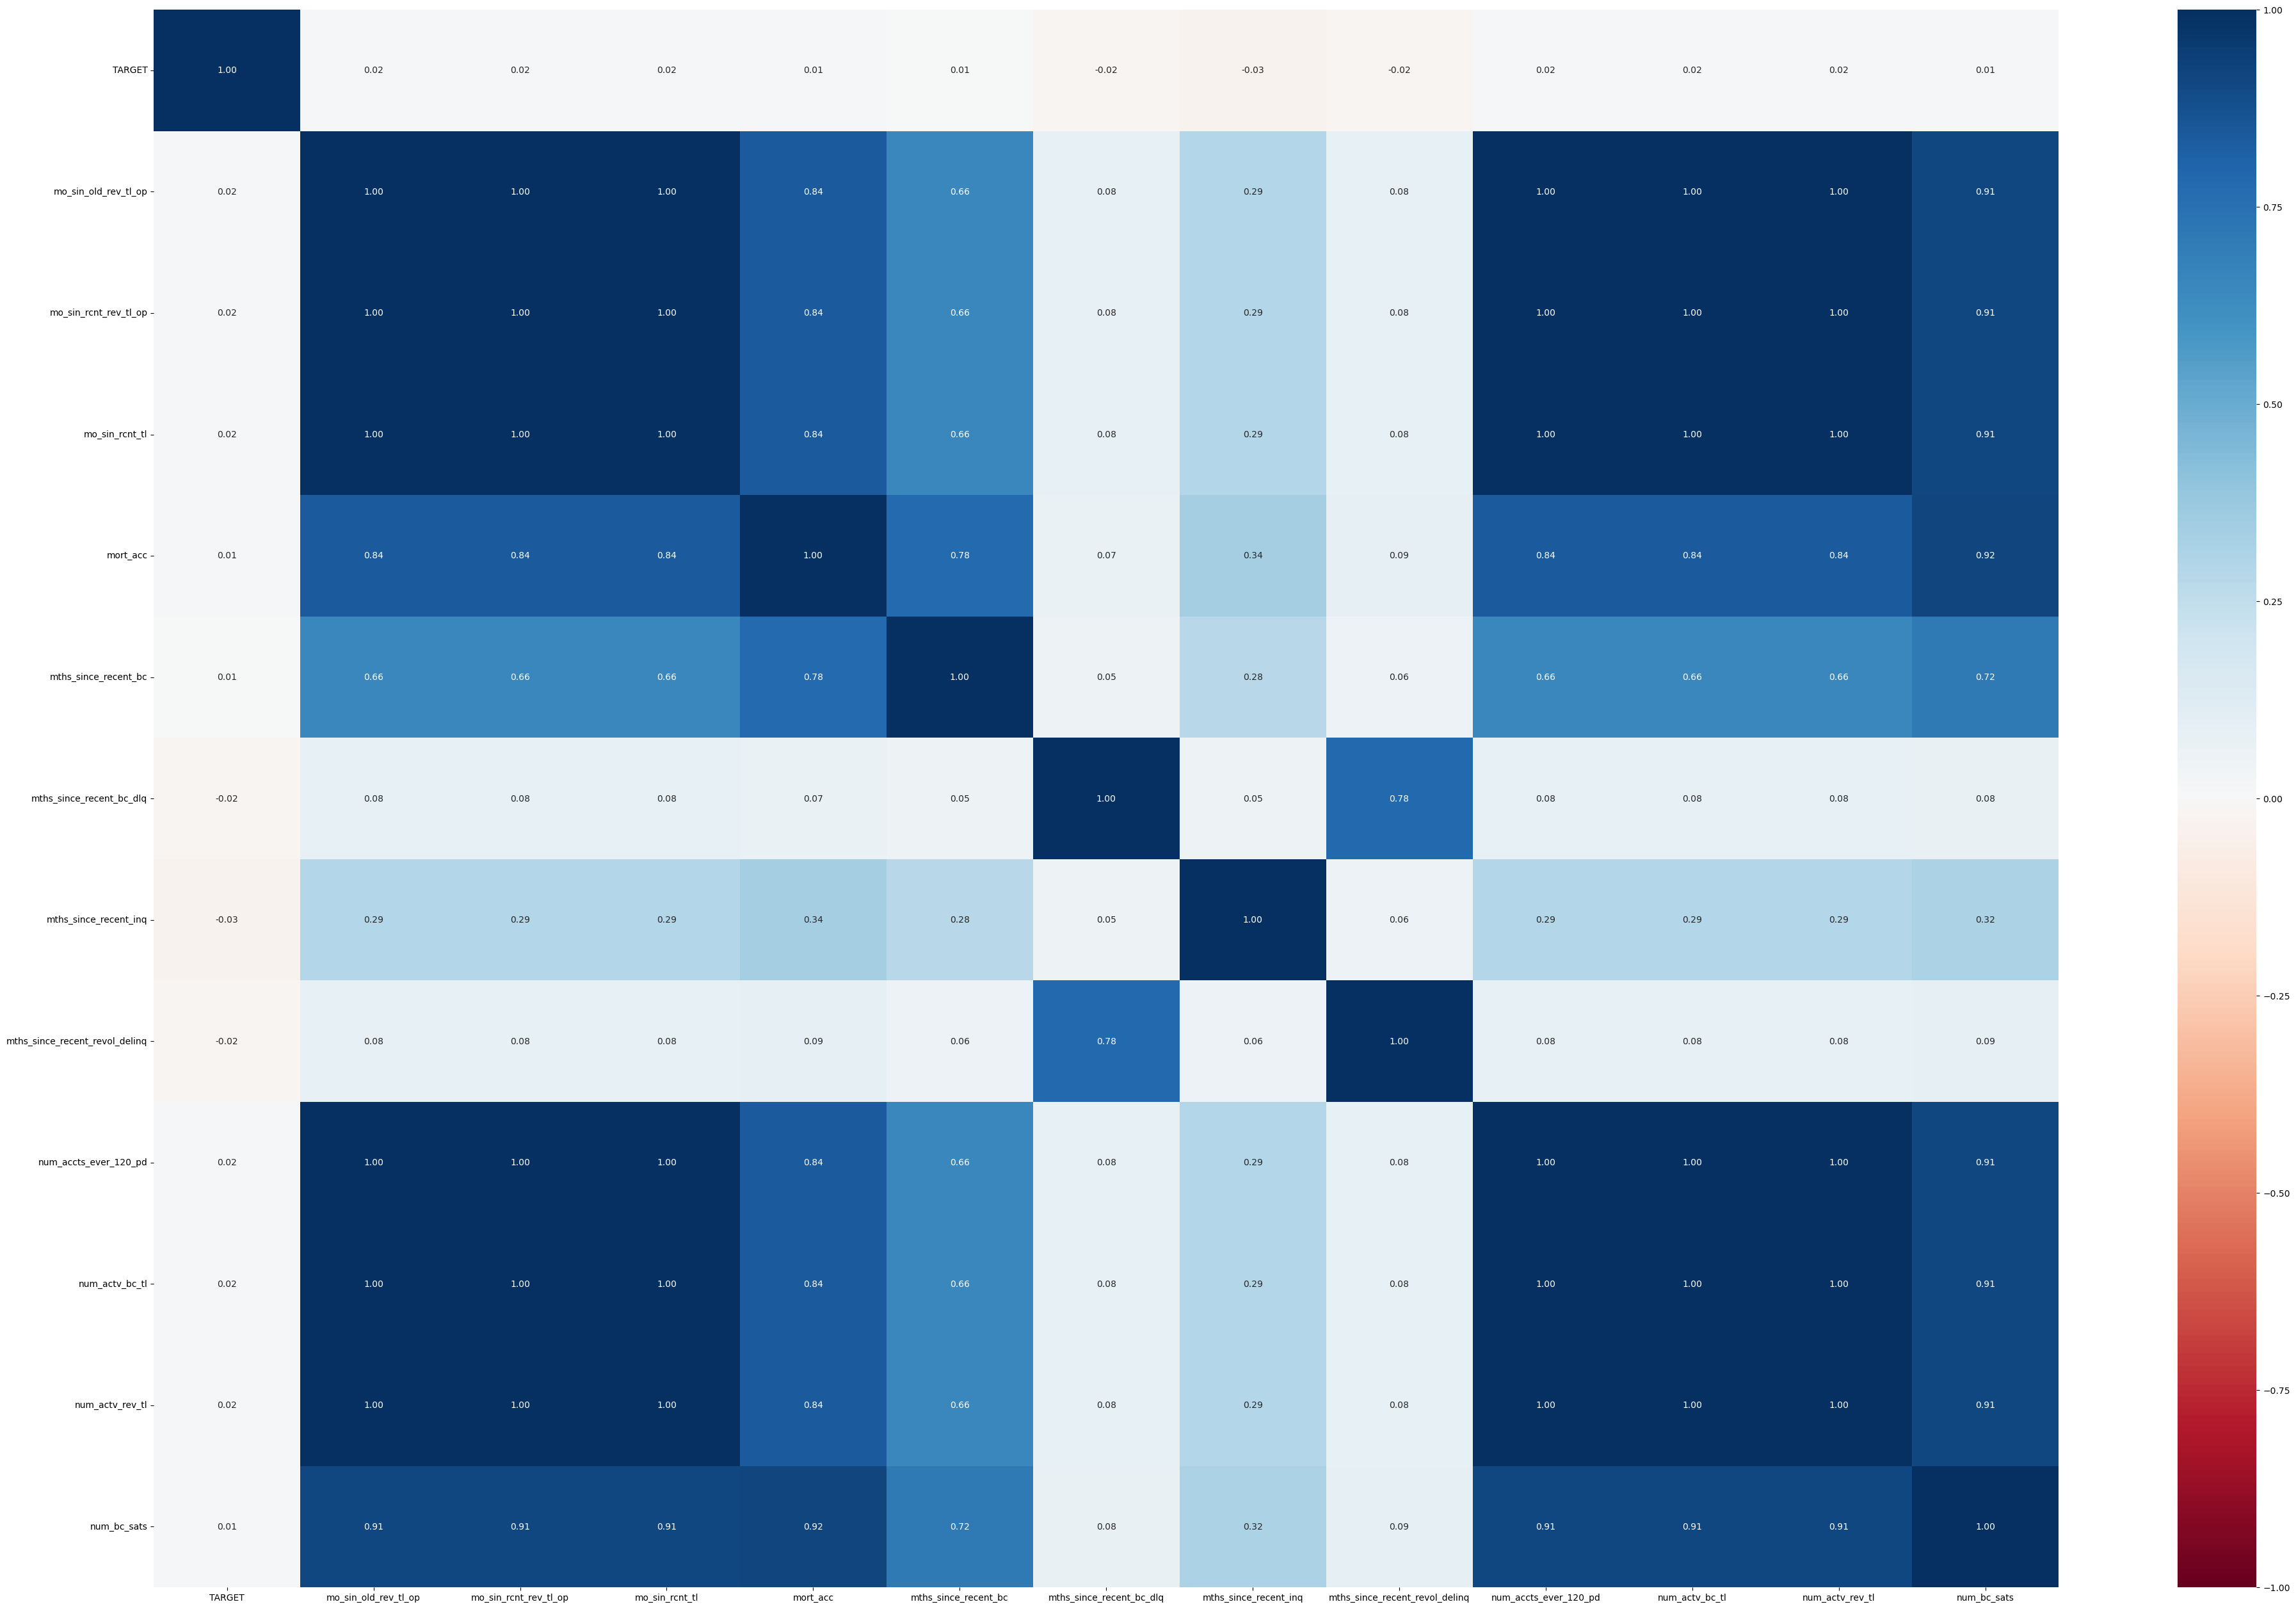

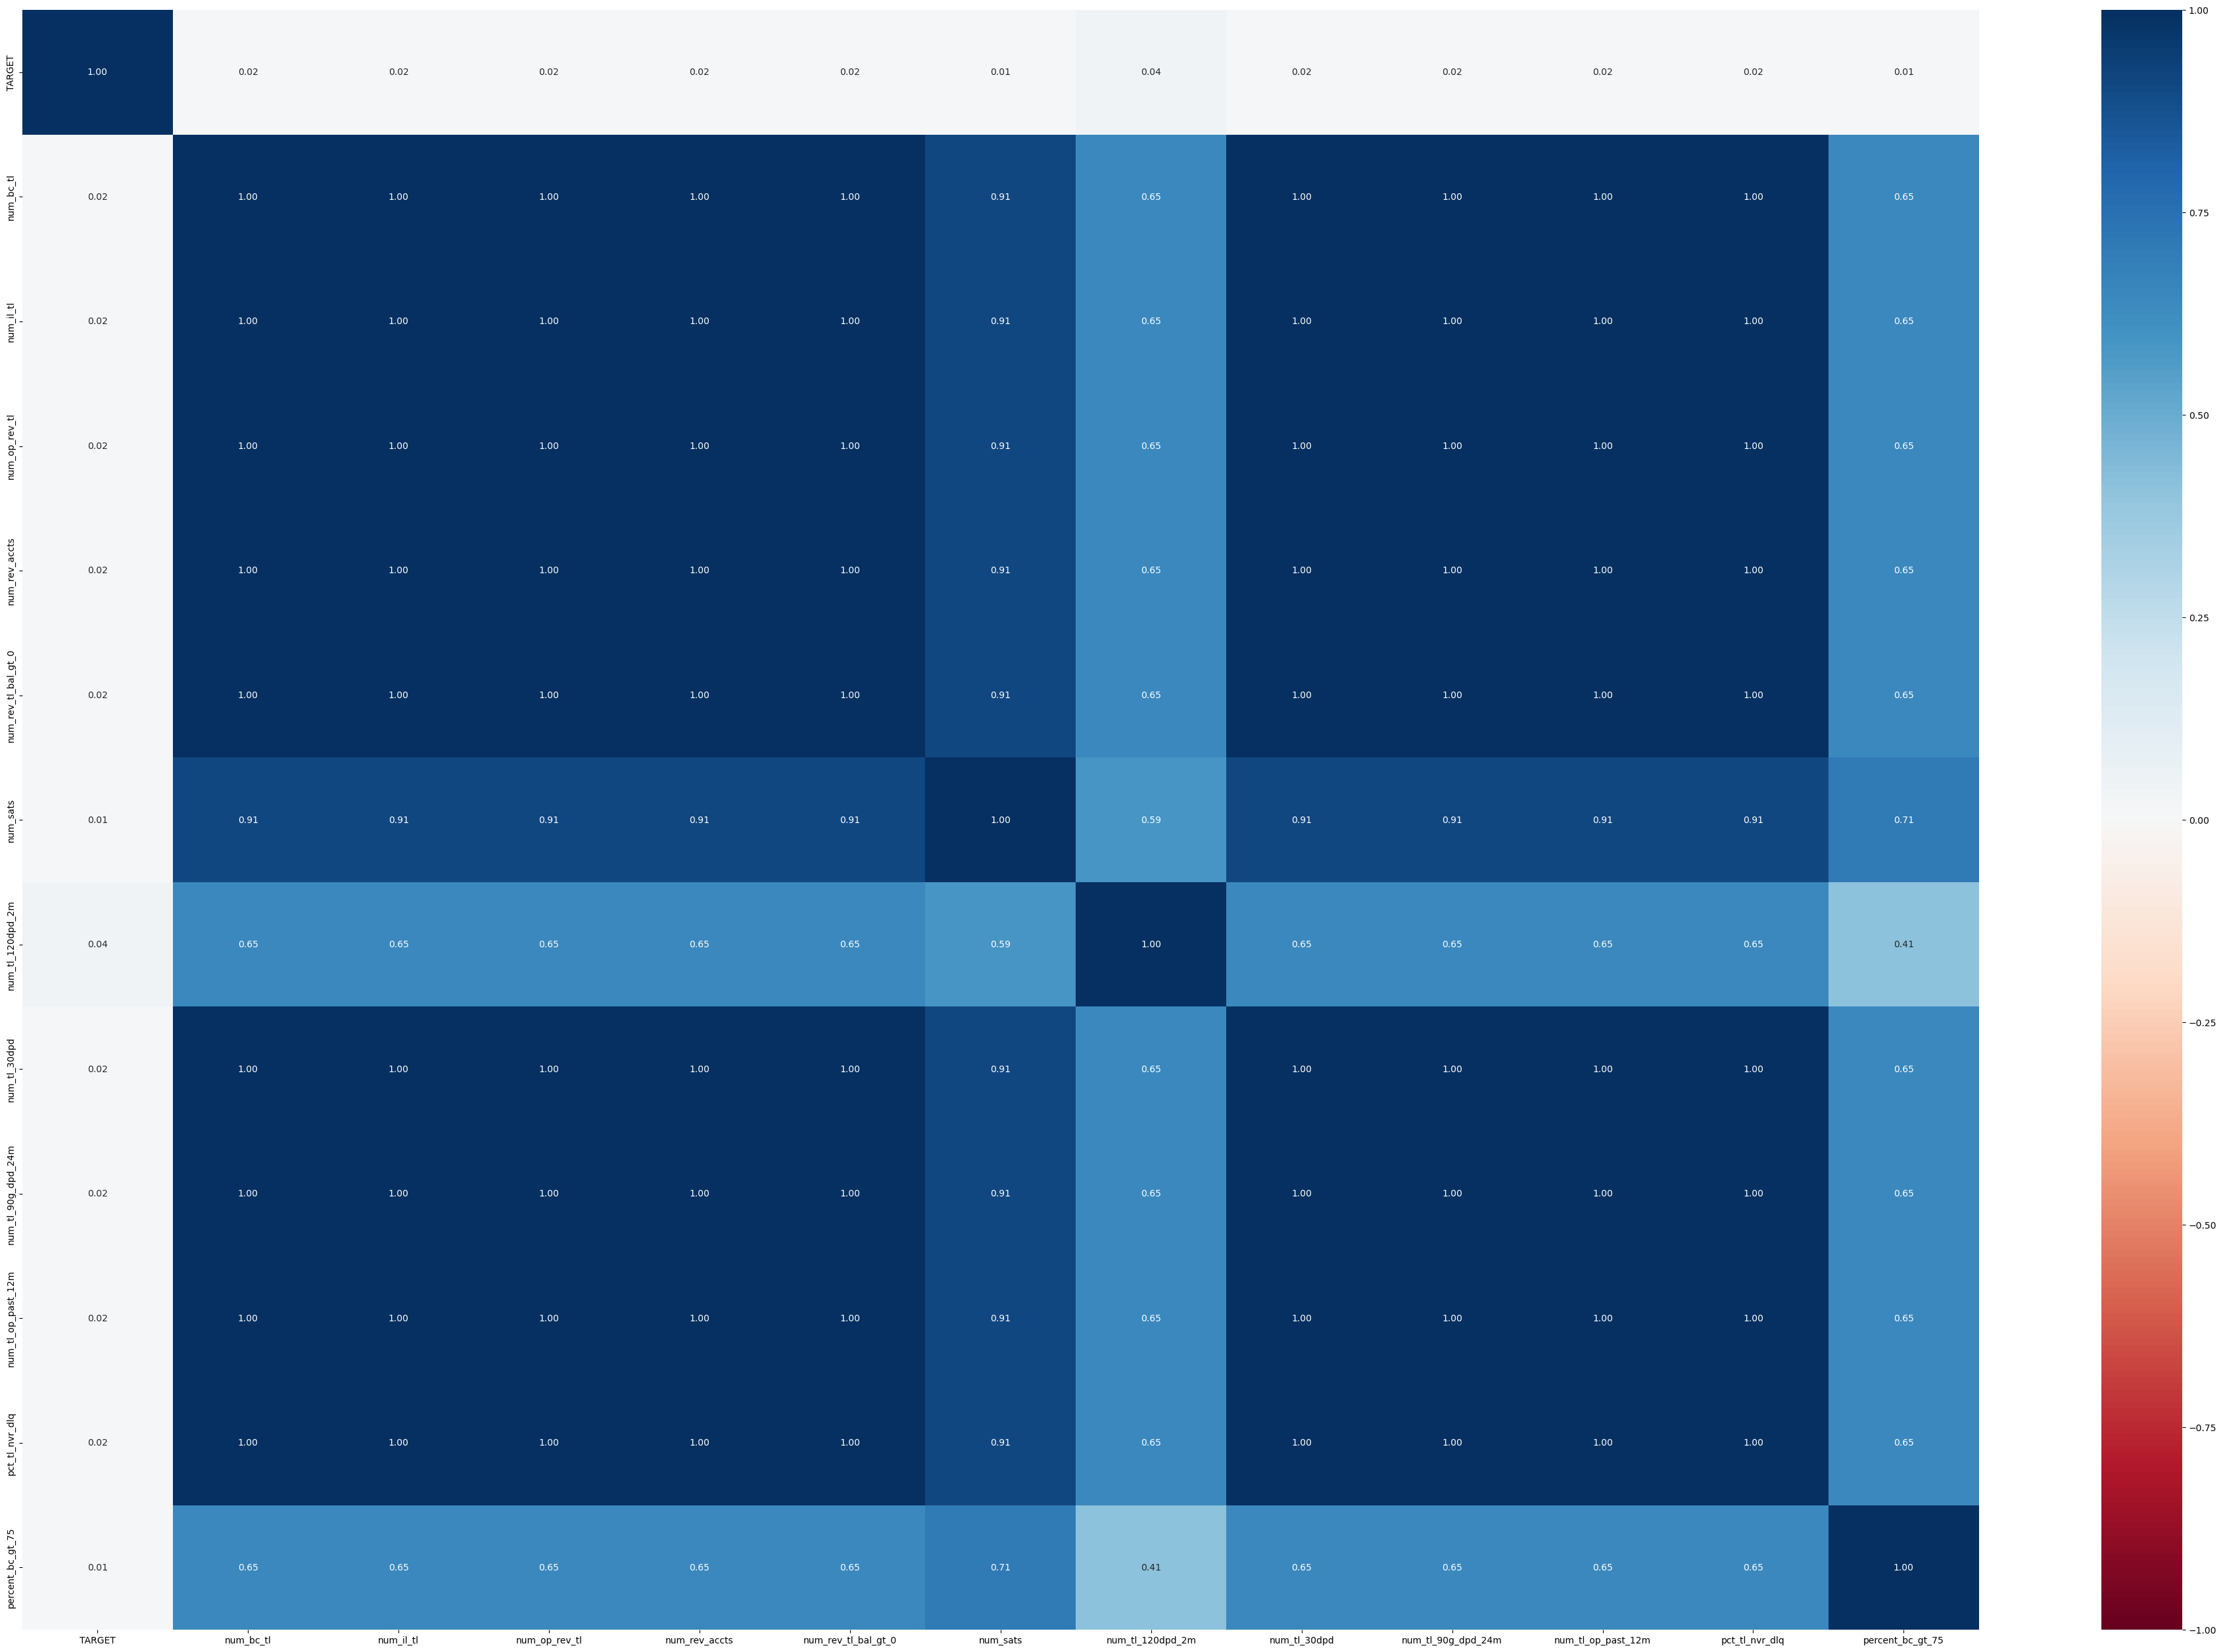

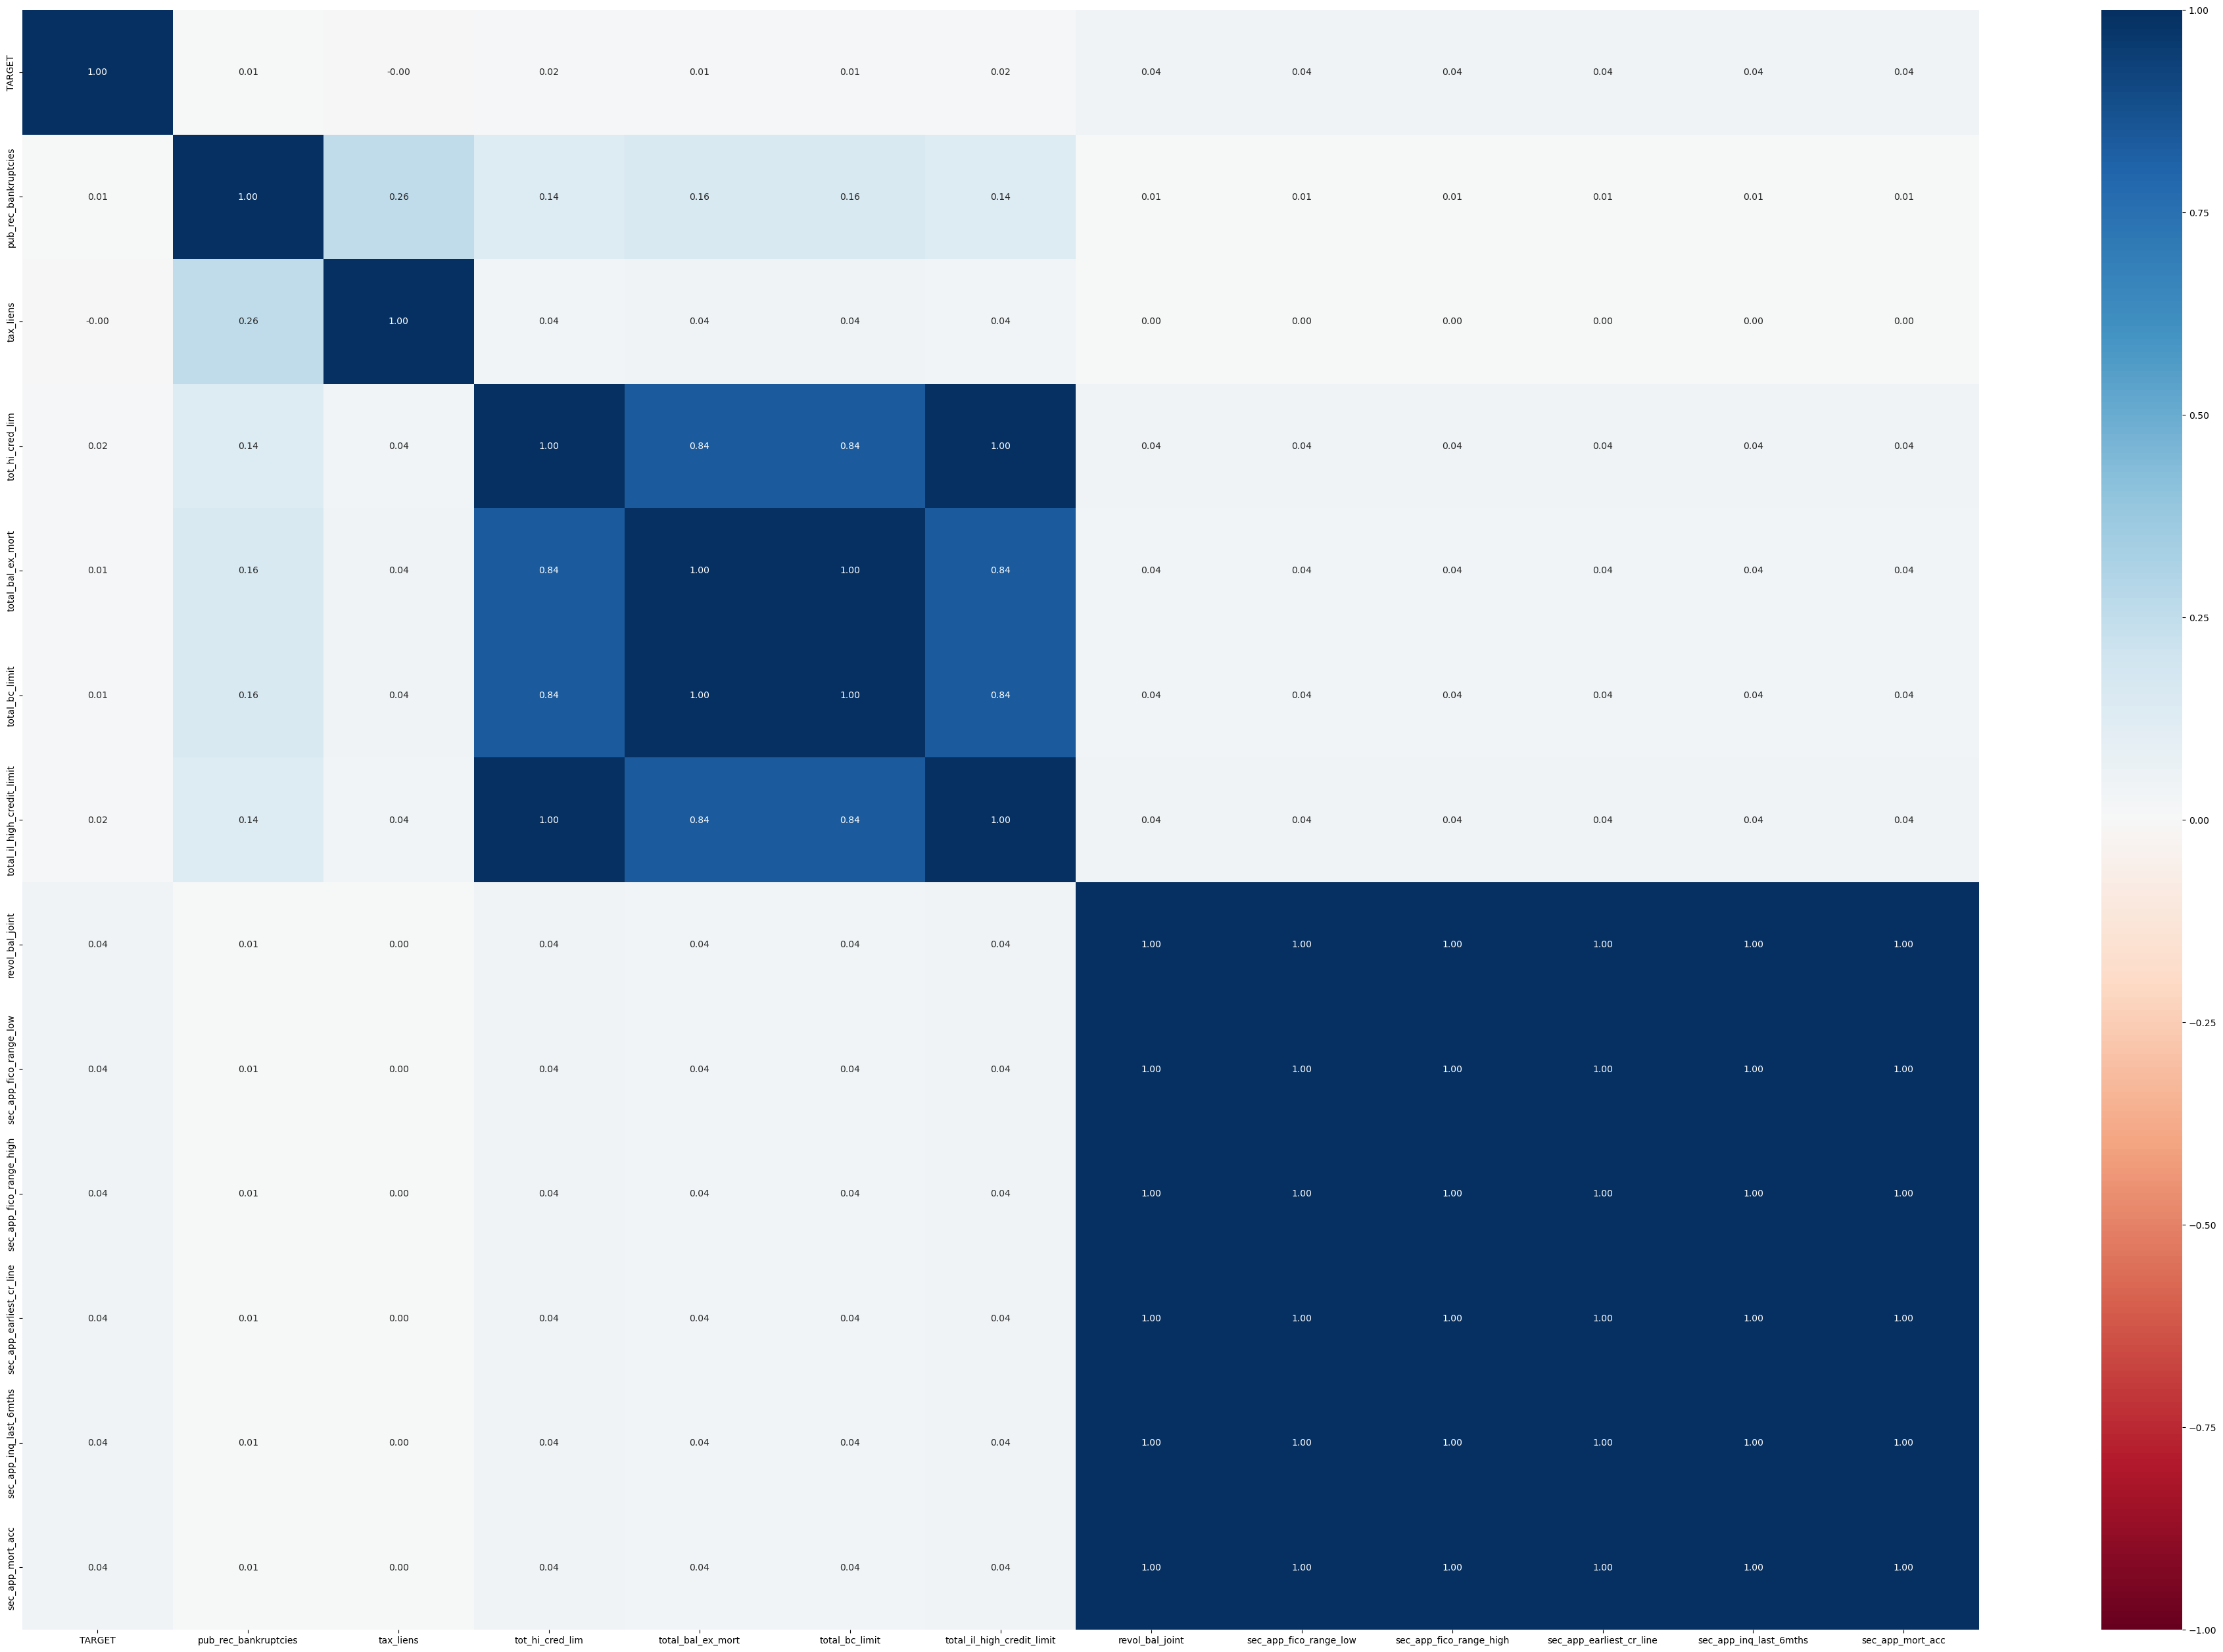

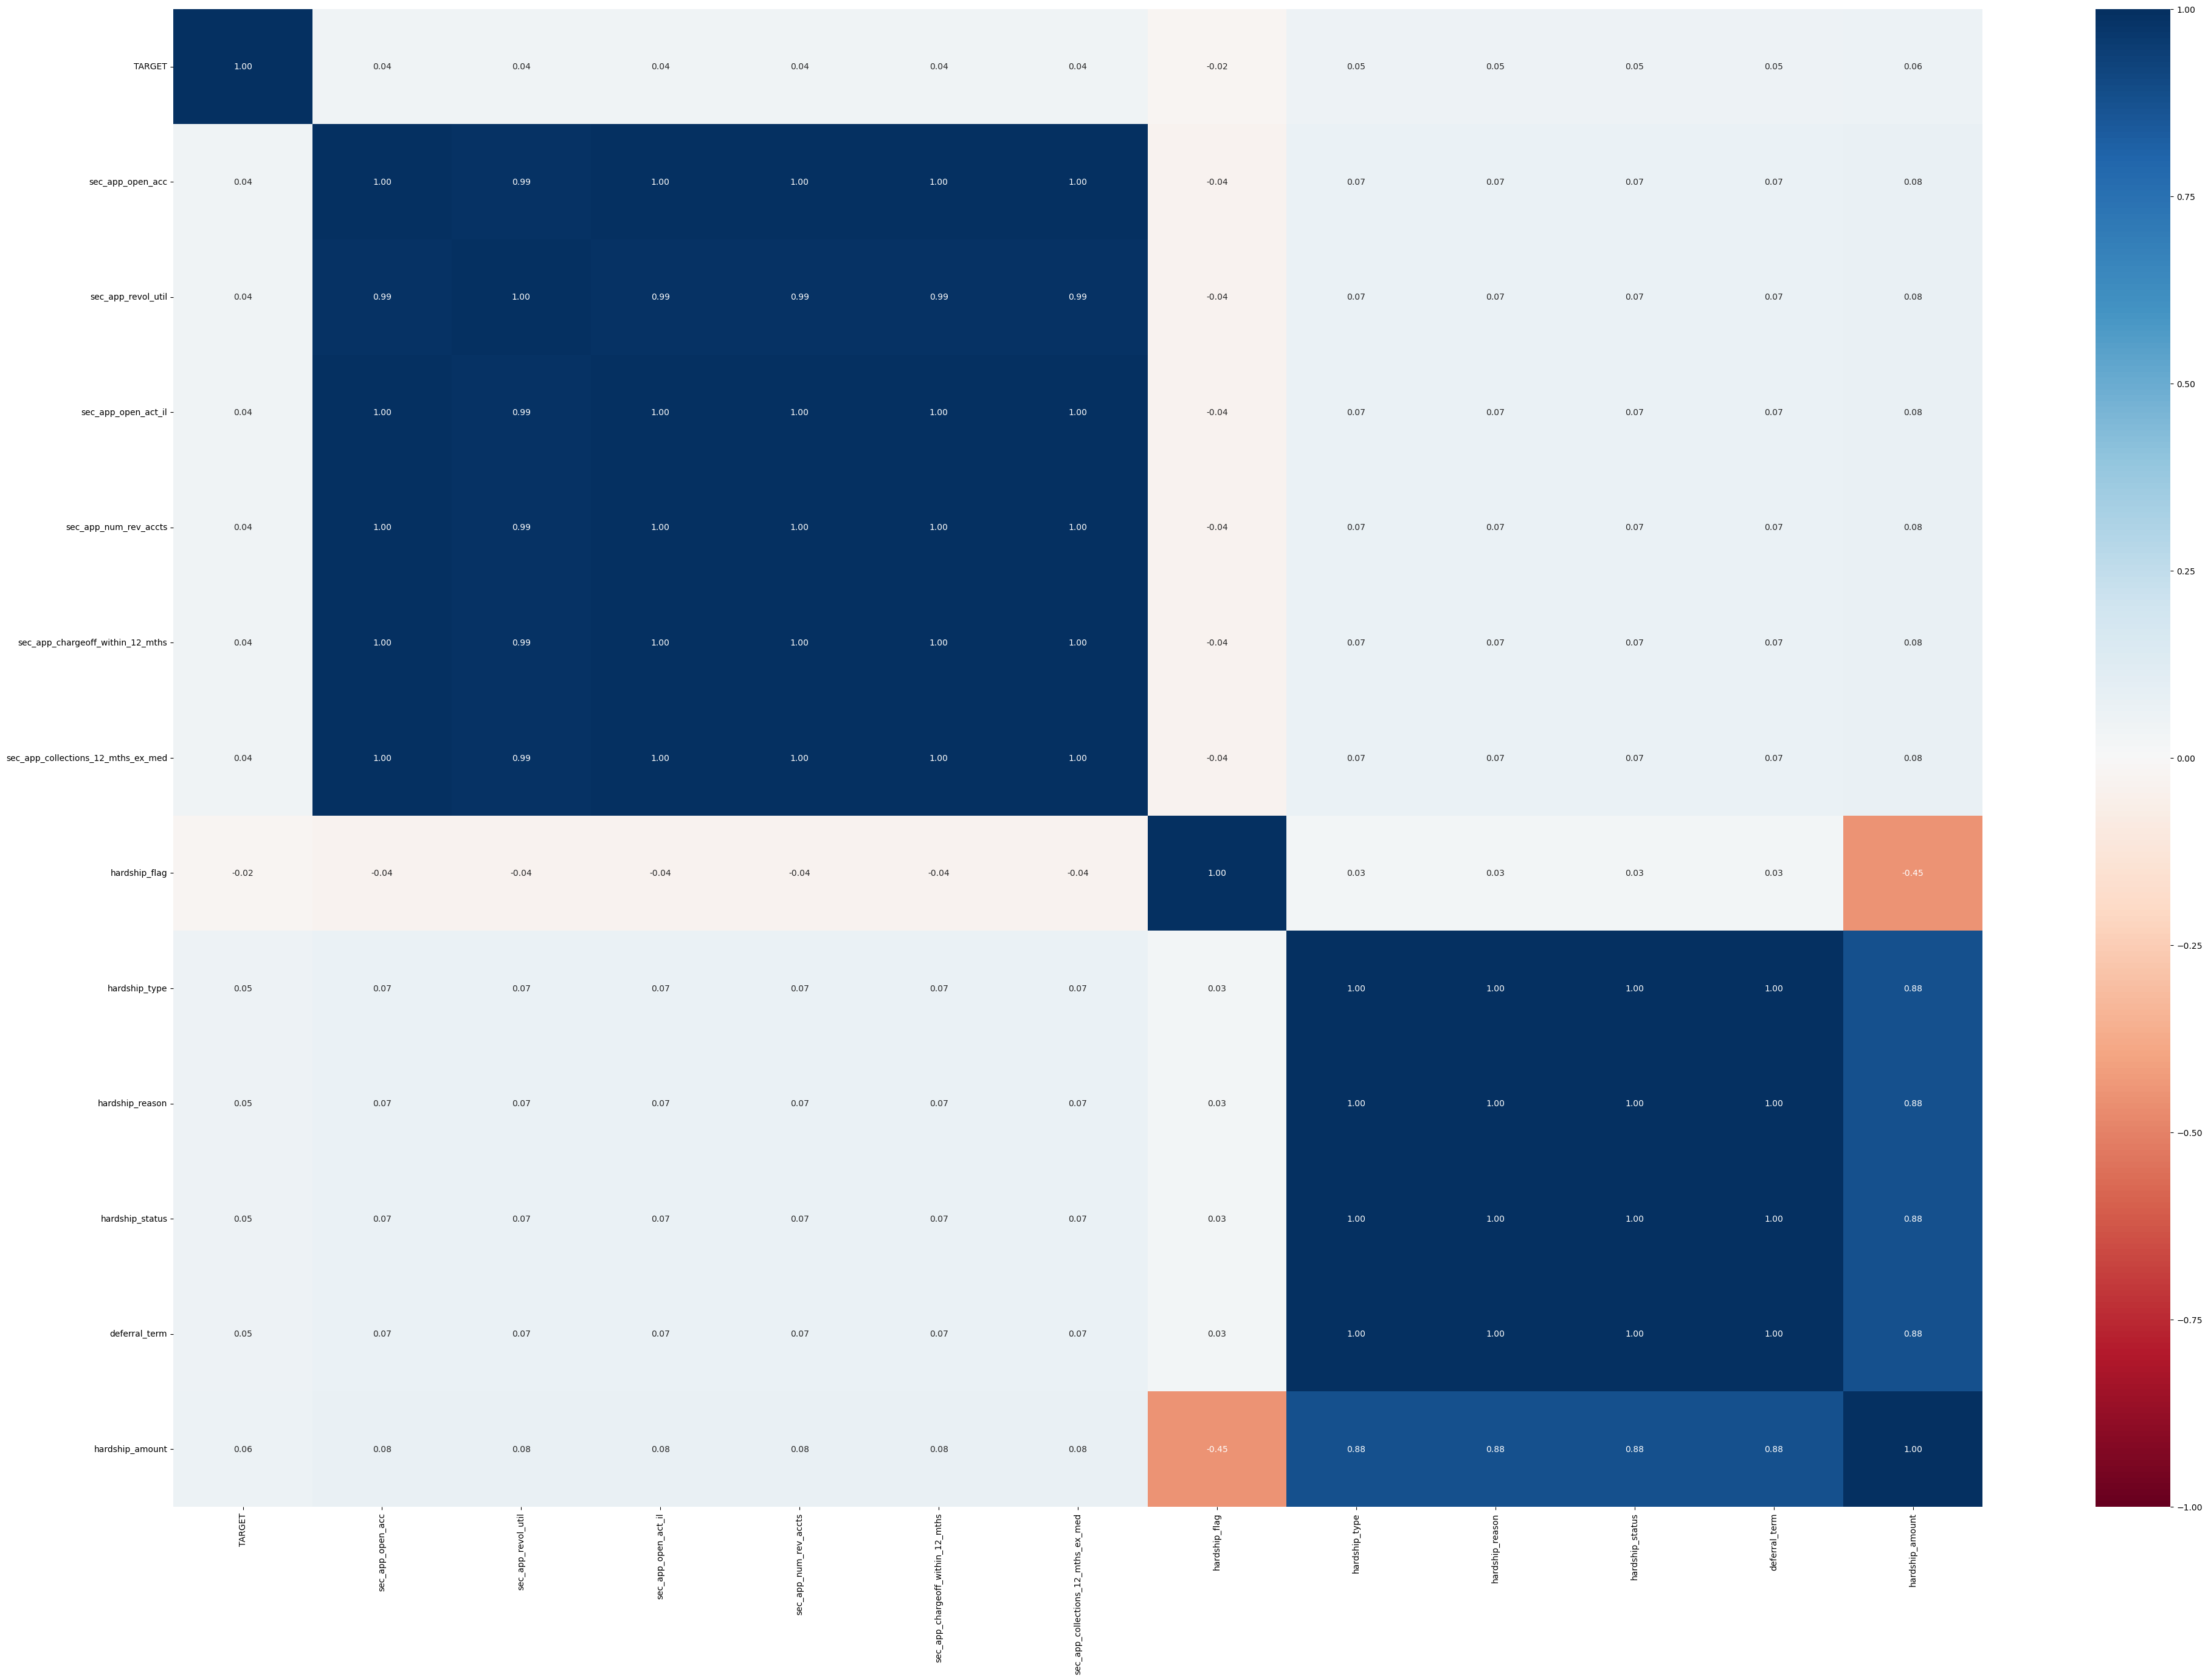

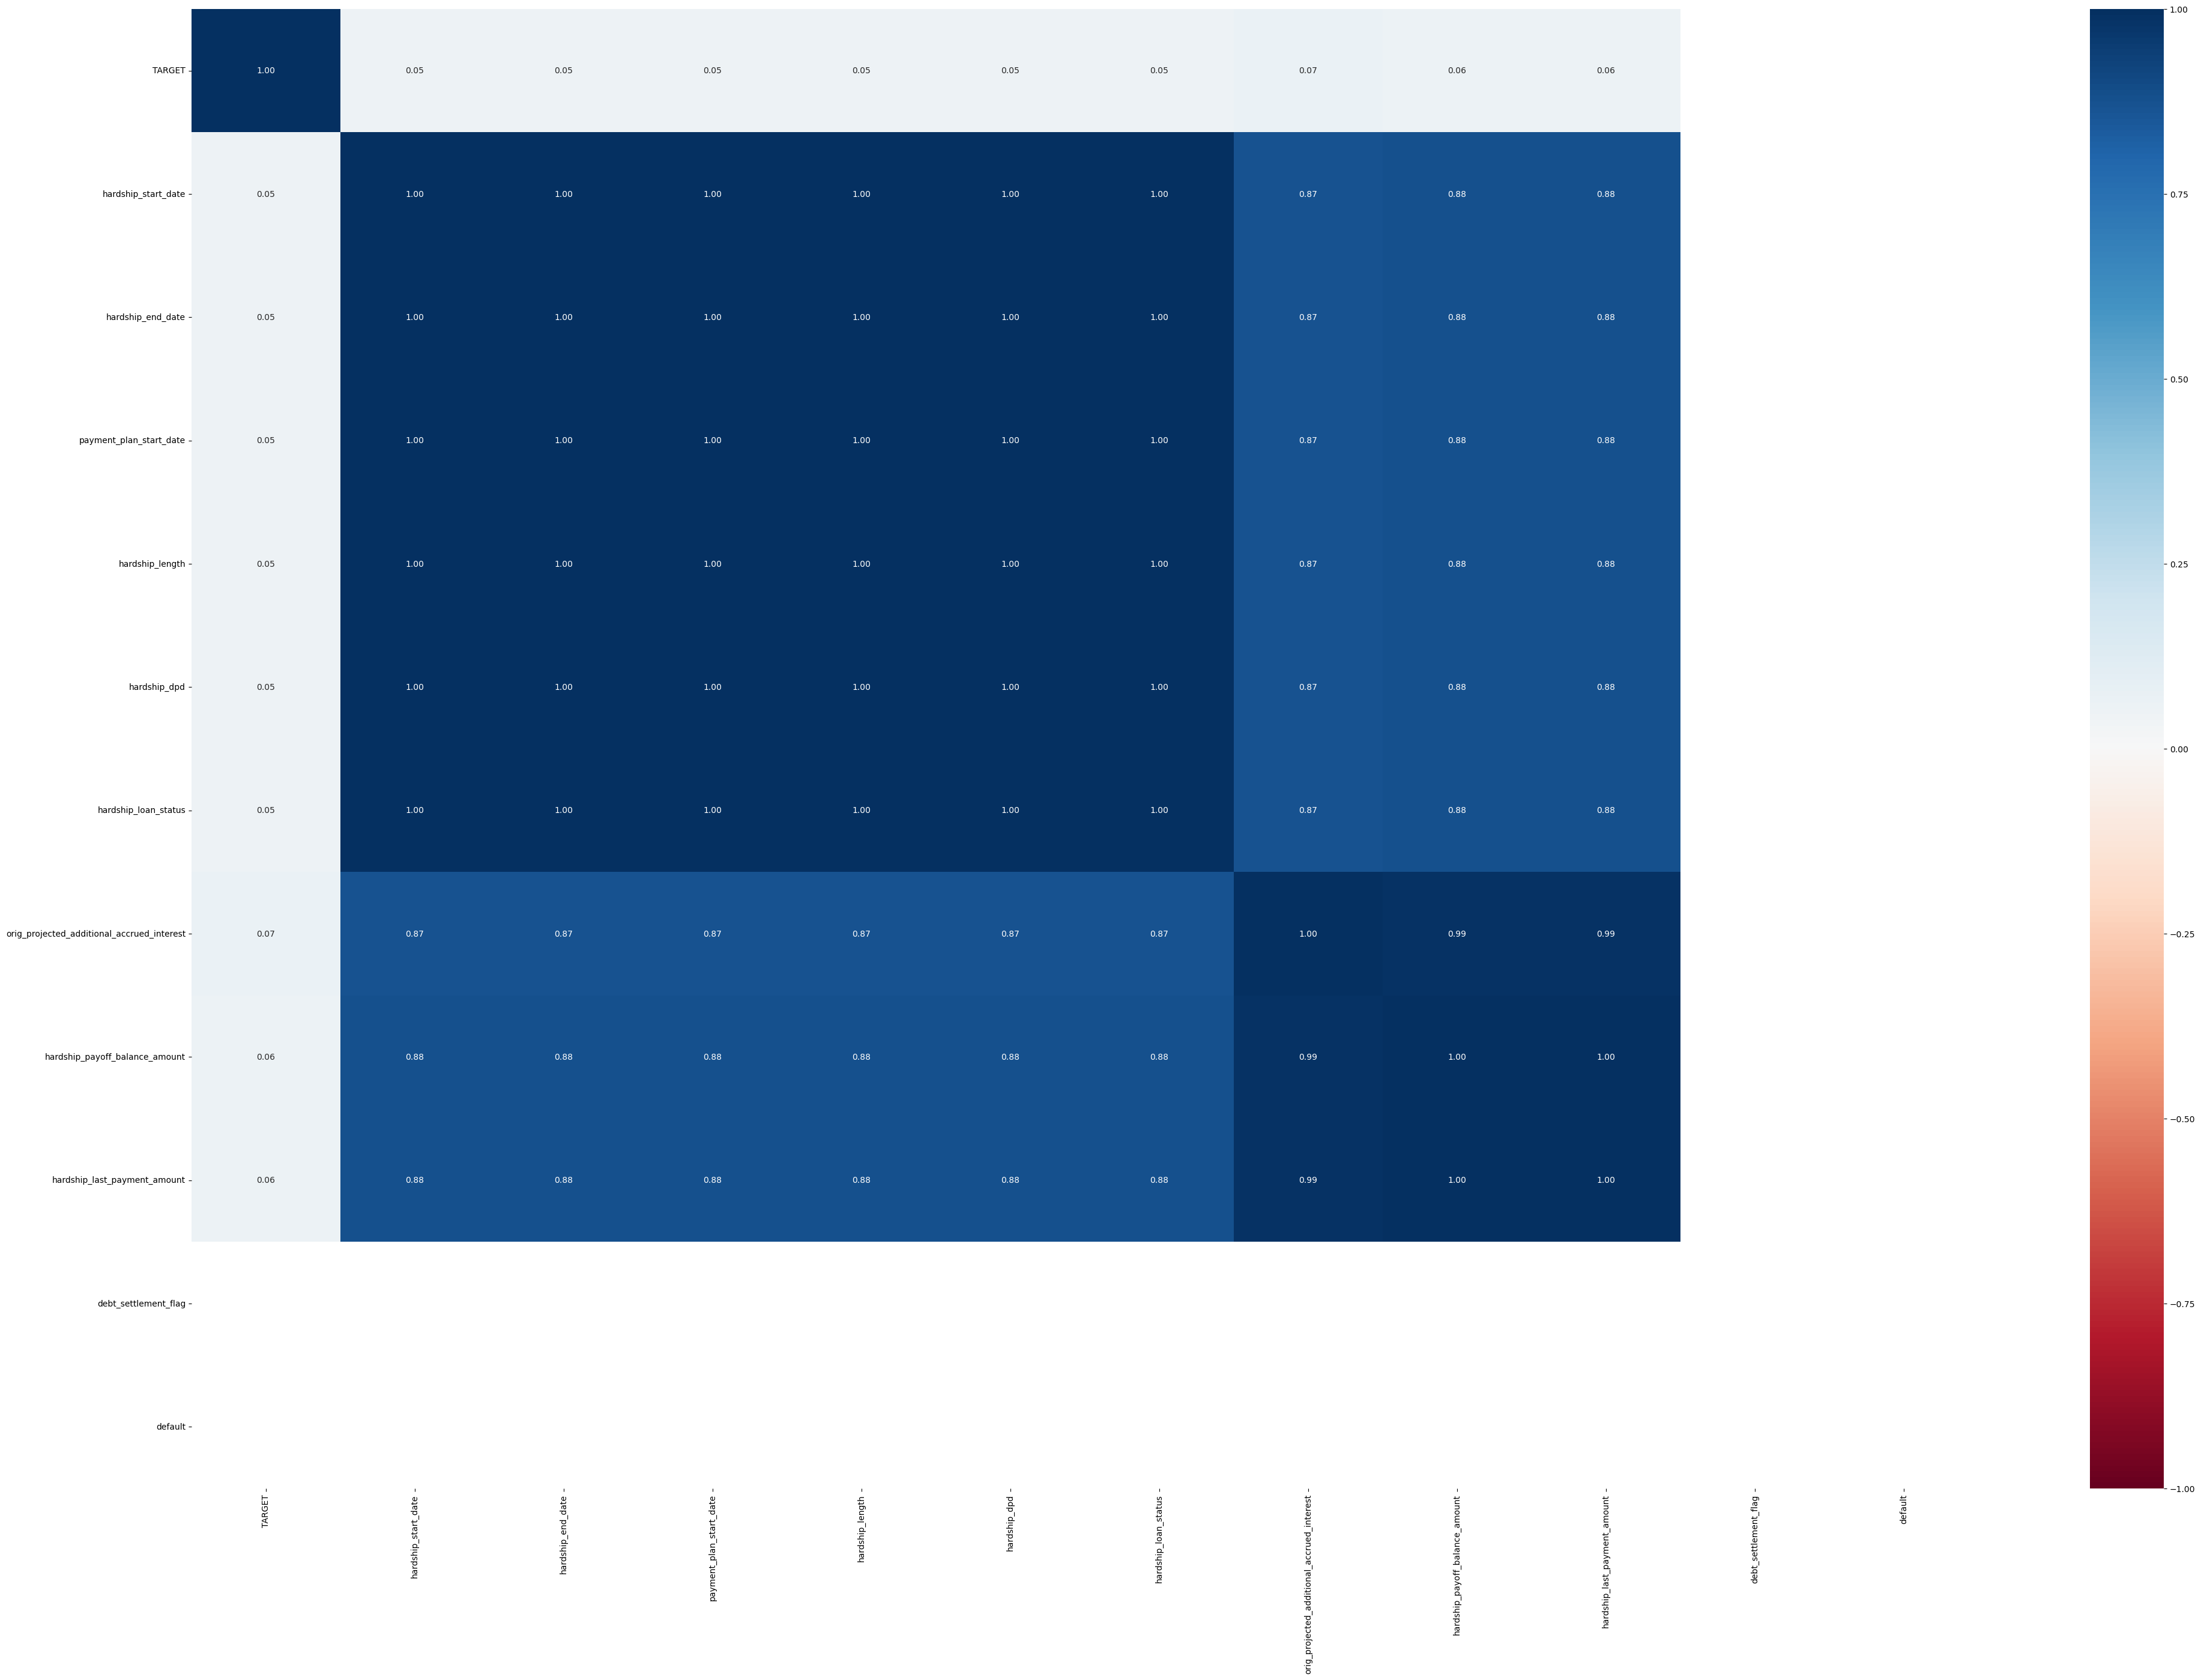

In [14]:
# Just for fun: Exploration of possible correlation between NaNs and the "default" series.
# Note 1: scan first columns or top rows.
# Note 2: Subsamples will have blank values due to insufficient number of missing values.
# The plots below also show that many of the feature items are collected as groups.

df_nas = df.isnull()

for chunk in list(partition(df_nas.columns, 12)):
    fig, ax = plt.subplots(figsize=(48, 32))
    data = df_nas.loc[:, chunk].copy()
    data.insert(0, "TARGET", df.default)
    sns.heatmap(data.corr(method="spearman", numeric_only=True), 
                cmap = "RdBu", 
                annot=True, 
                fmt=".2f", 
                vmin=-1,
                vmax=1,
                ax=ax    
               )
    #plt.title("Correlation Heat Map for Lending Club Dataset NaNs", fontsize=40)
    plt.show()
    
del df_nas

In [98]:
# a boolean series indicating which columns are 80% or more complete.
mask = df.isnull().sum().div(df.shape[0]) < .2

In [99]:
# Items we are dropping due to many NAs. This threshhold is arbitrary and would be evaluated more thoroughly 
# in a production environment. e.g. Thoughtful imputation could likely be applied in many cases.
temp = []
for i, j in zip(~mask.values, mask.index):
    if i:
        temp.append(j)
sorted(temp)

['all_util',
 'annual_inc_joint',
 'deferral_term',
 'dti_joint',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'il_util',
 'inq_fi',
 'inq_last_12m',
 'max_bal_bc',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_rcnt_il',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'next_pymnt_d',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'open_rv_12m',
 'open_rv_24m',
 'orig_projected_additional_accrued_interest',
 'payment_plan_start_date',
 'revol_bal_joint',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_earliest_cr_line',
 'sec_app_fico_range_high',
 'sec_app_fico_range_low',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_num_rev_accts',
 'sec_app_

In [46]:
df = df.loc[:, mask]
df.shape

(300000, 94)

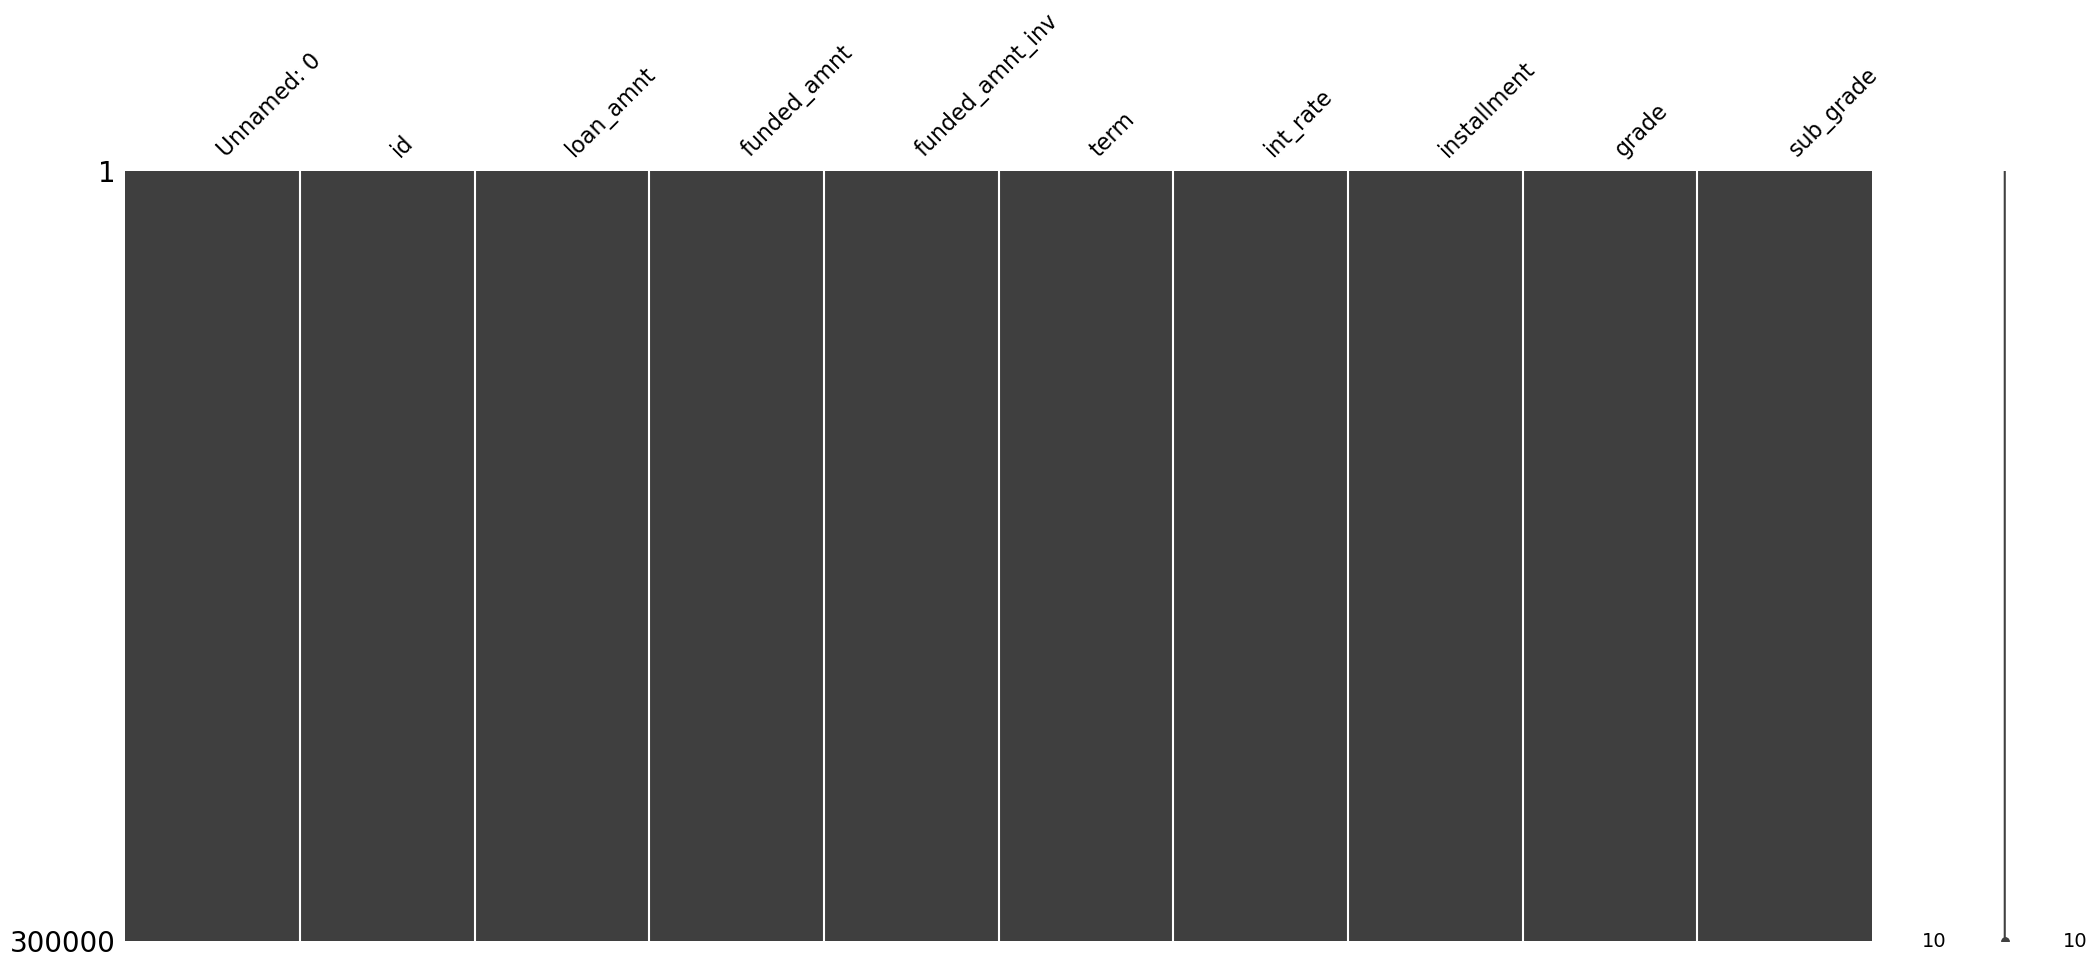

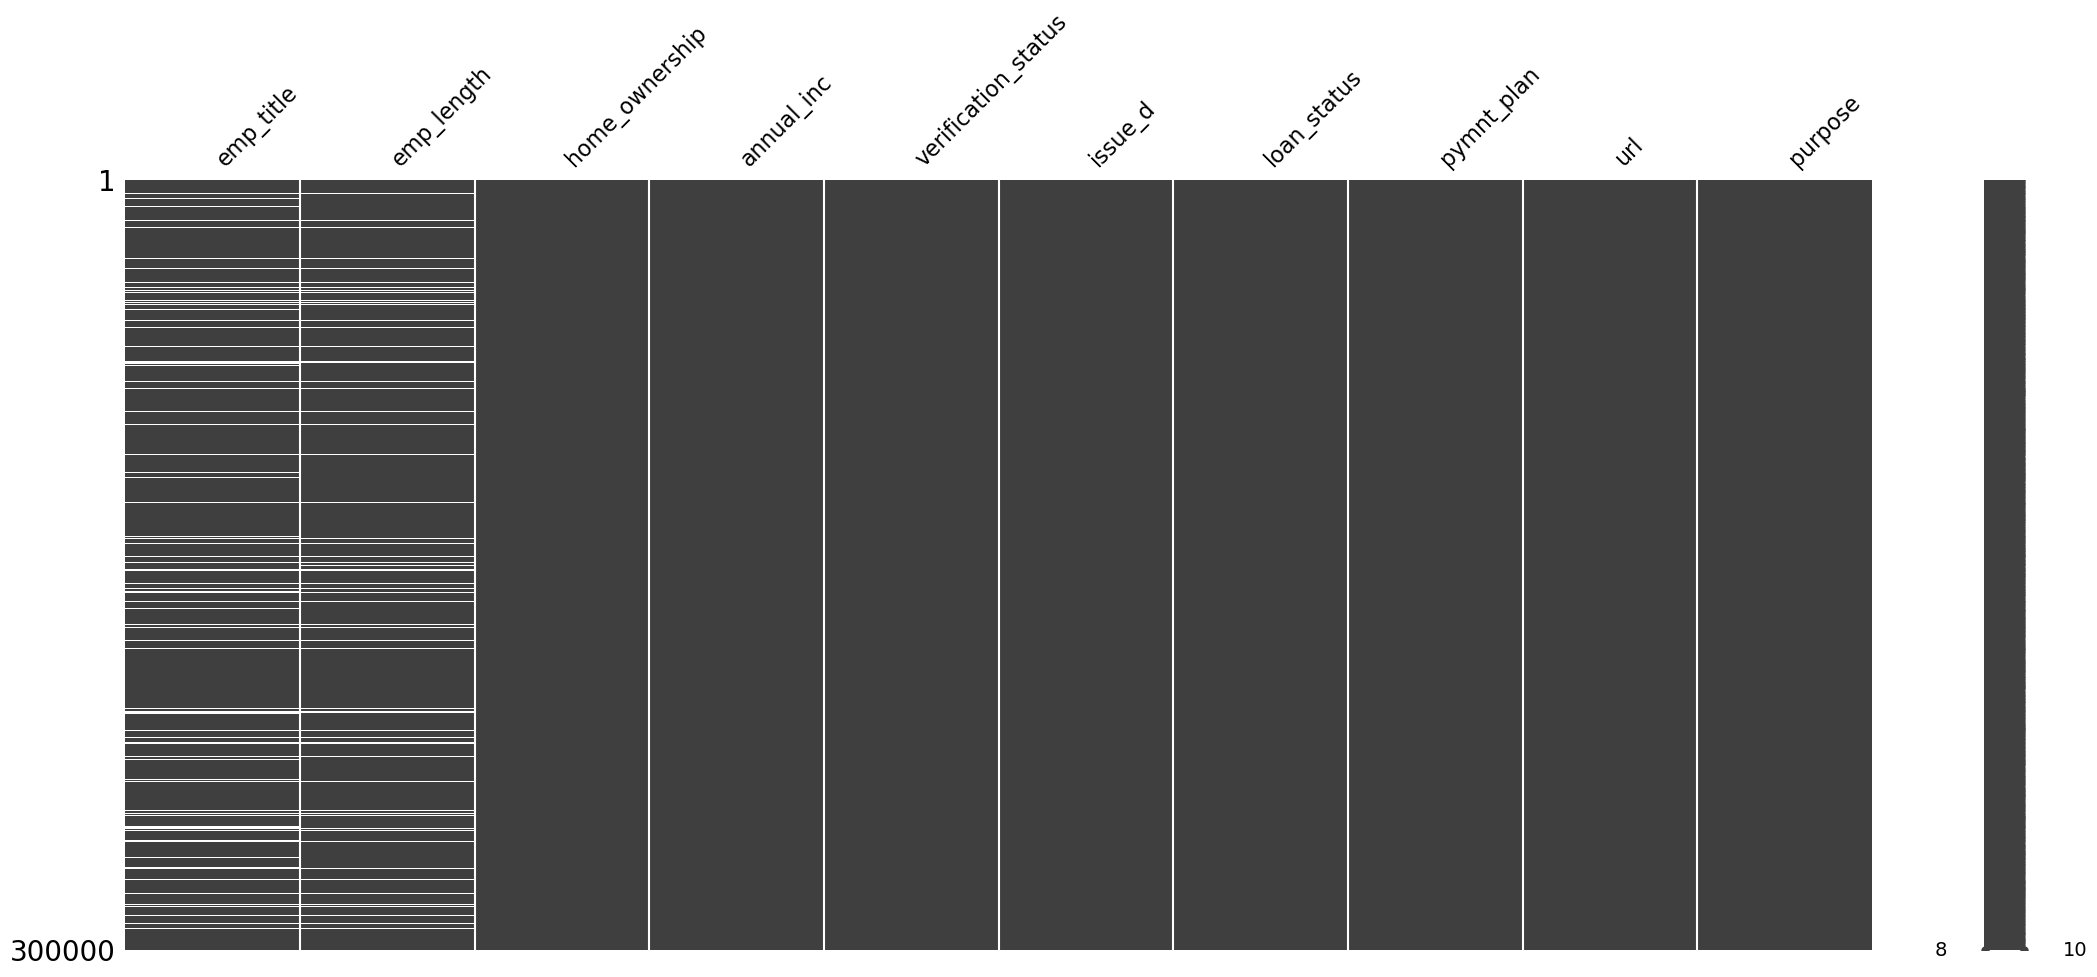

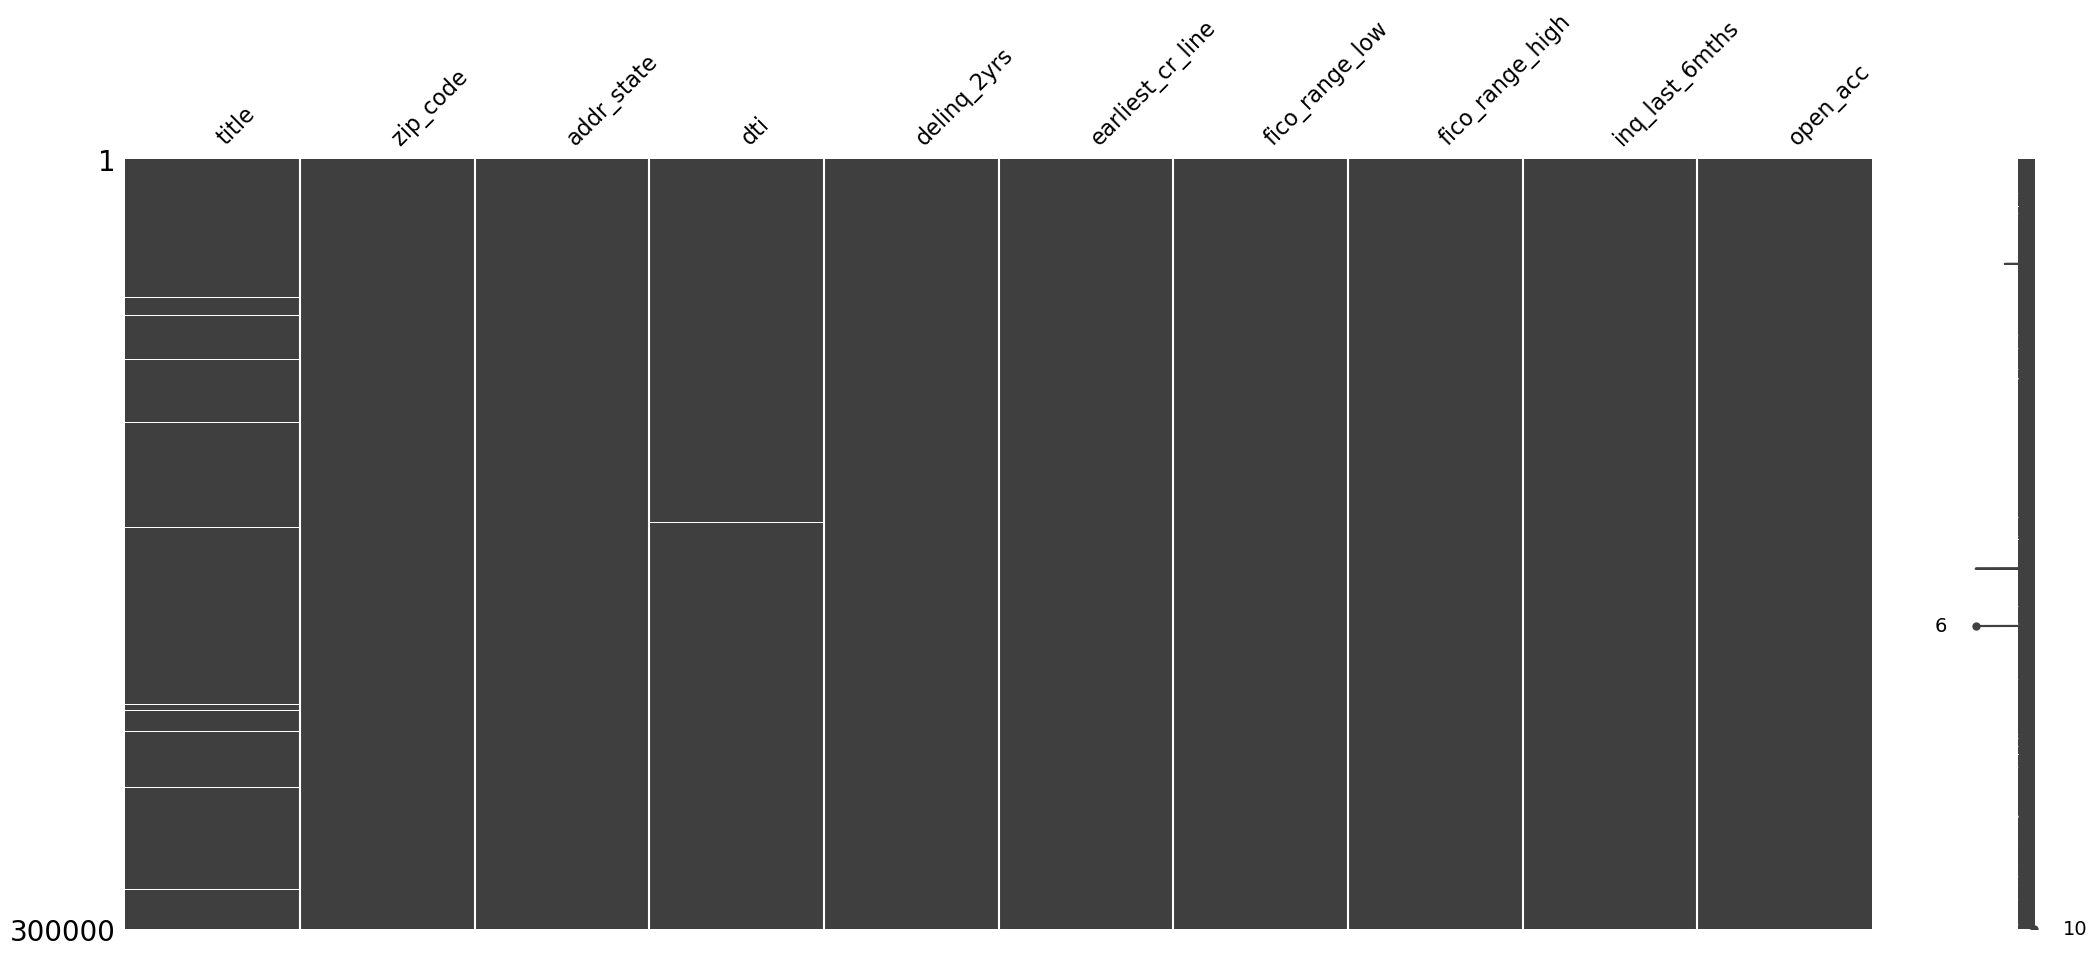

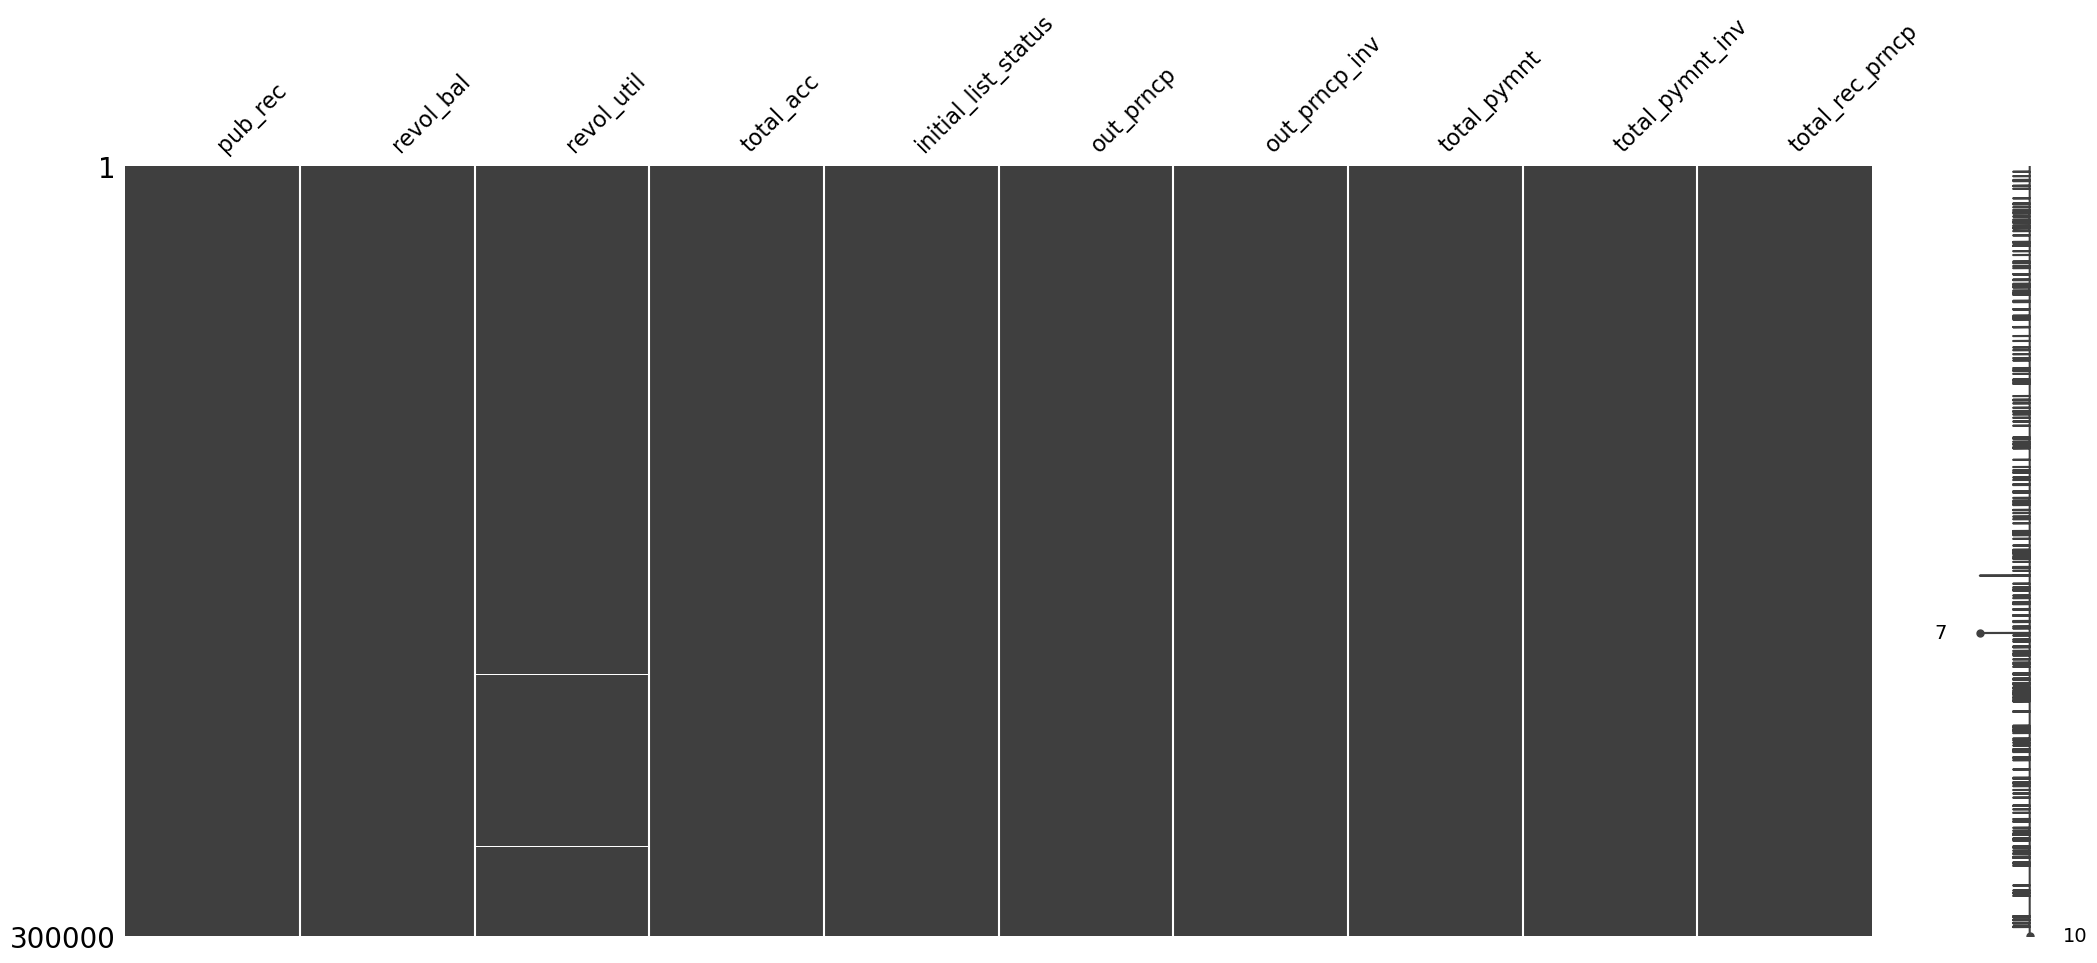

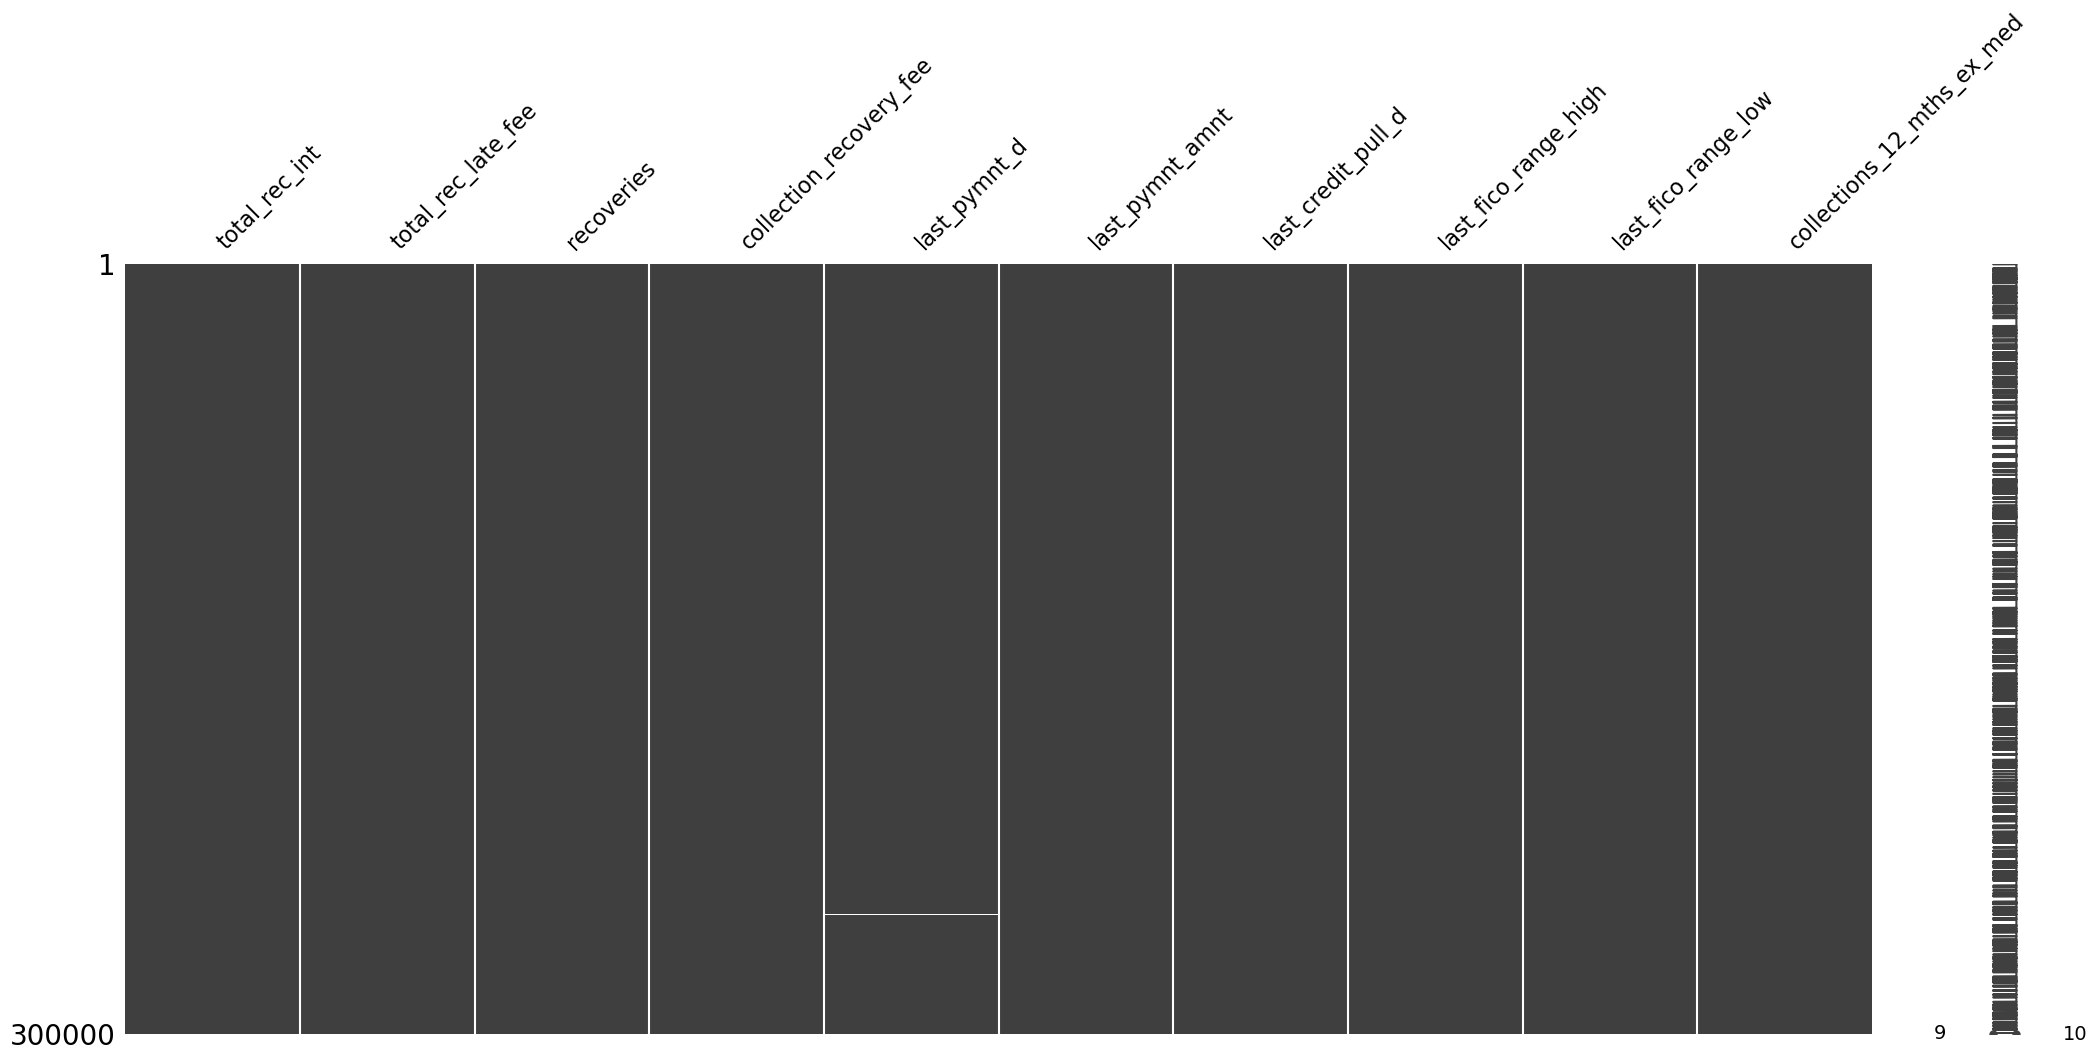

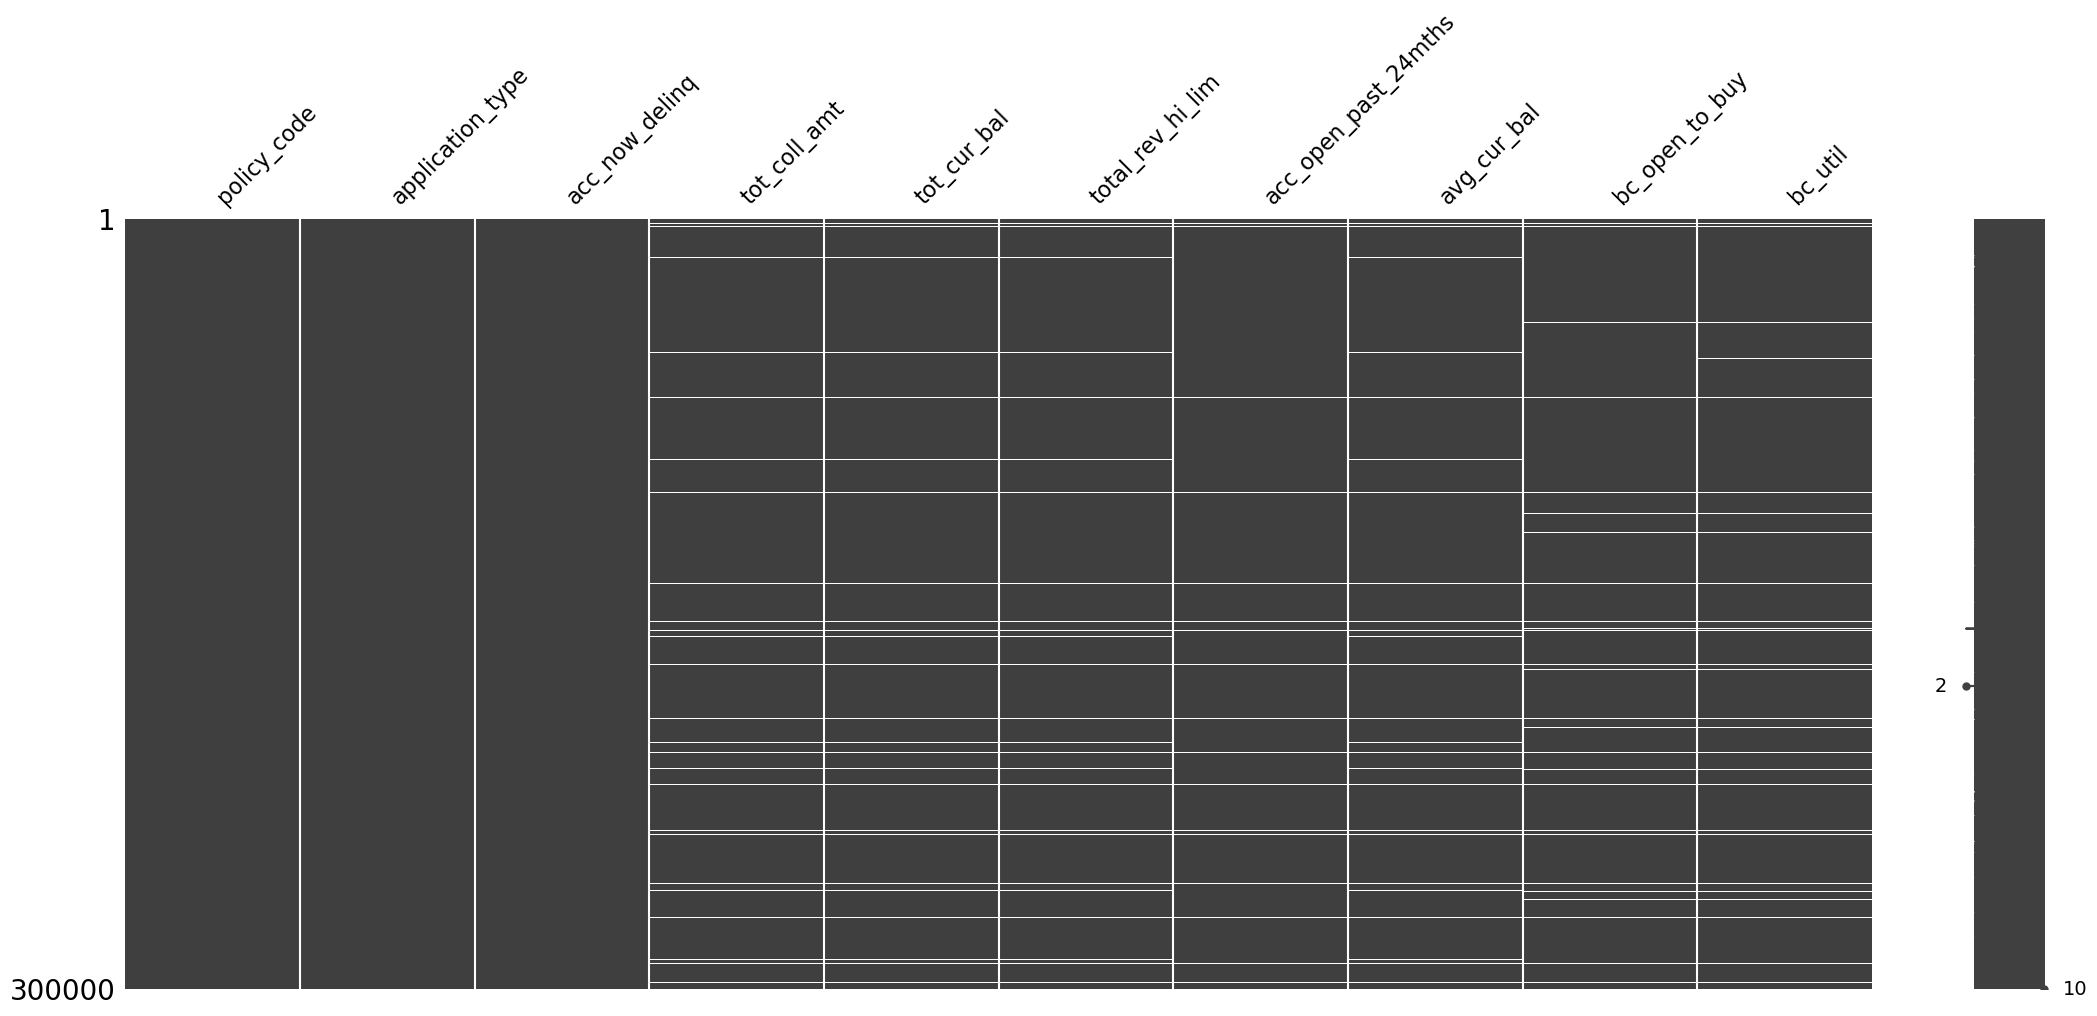

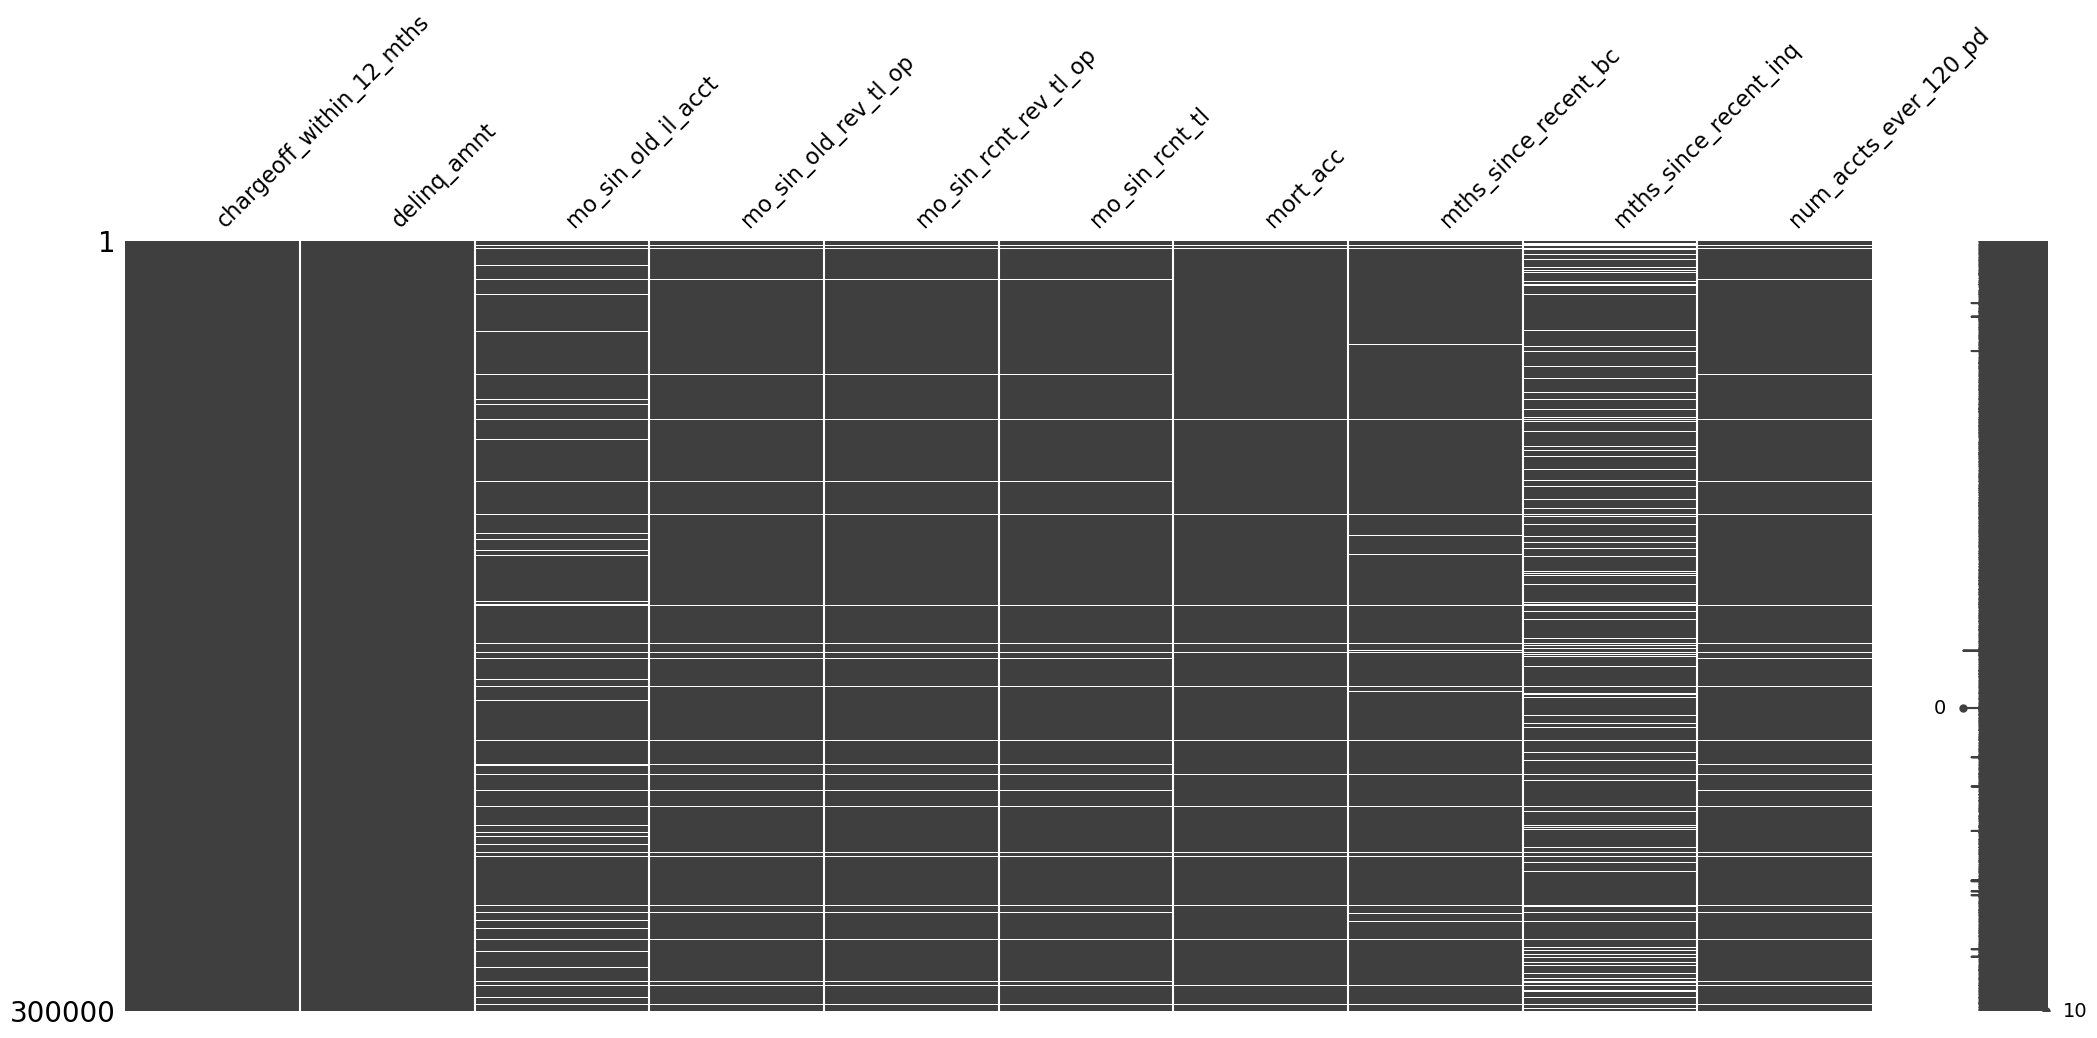

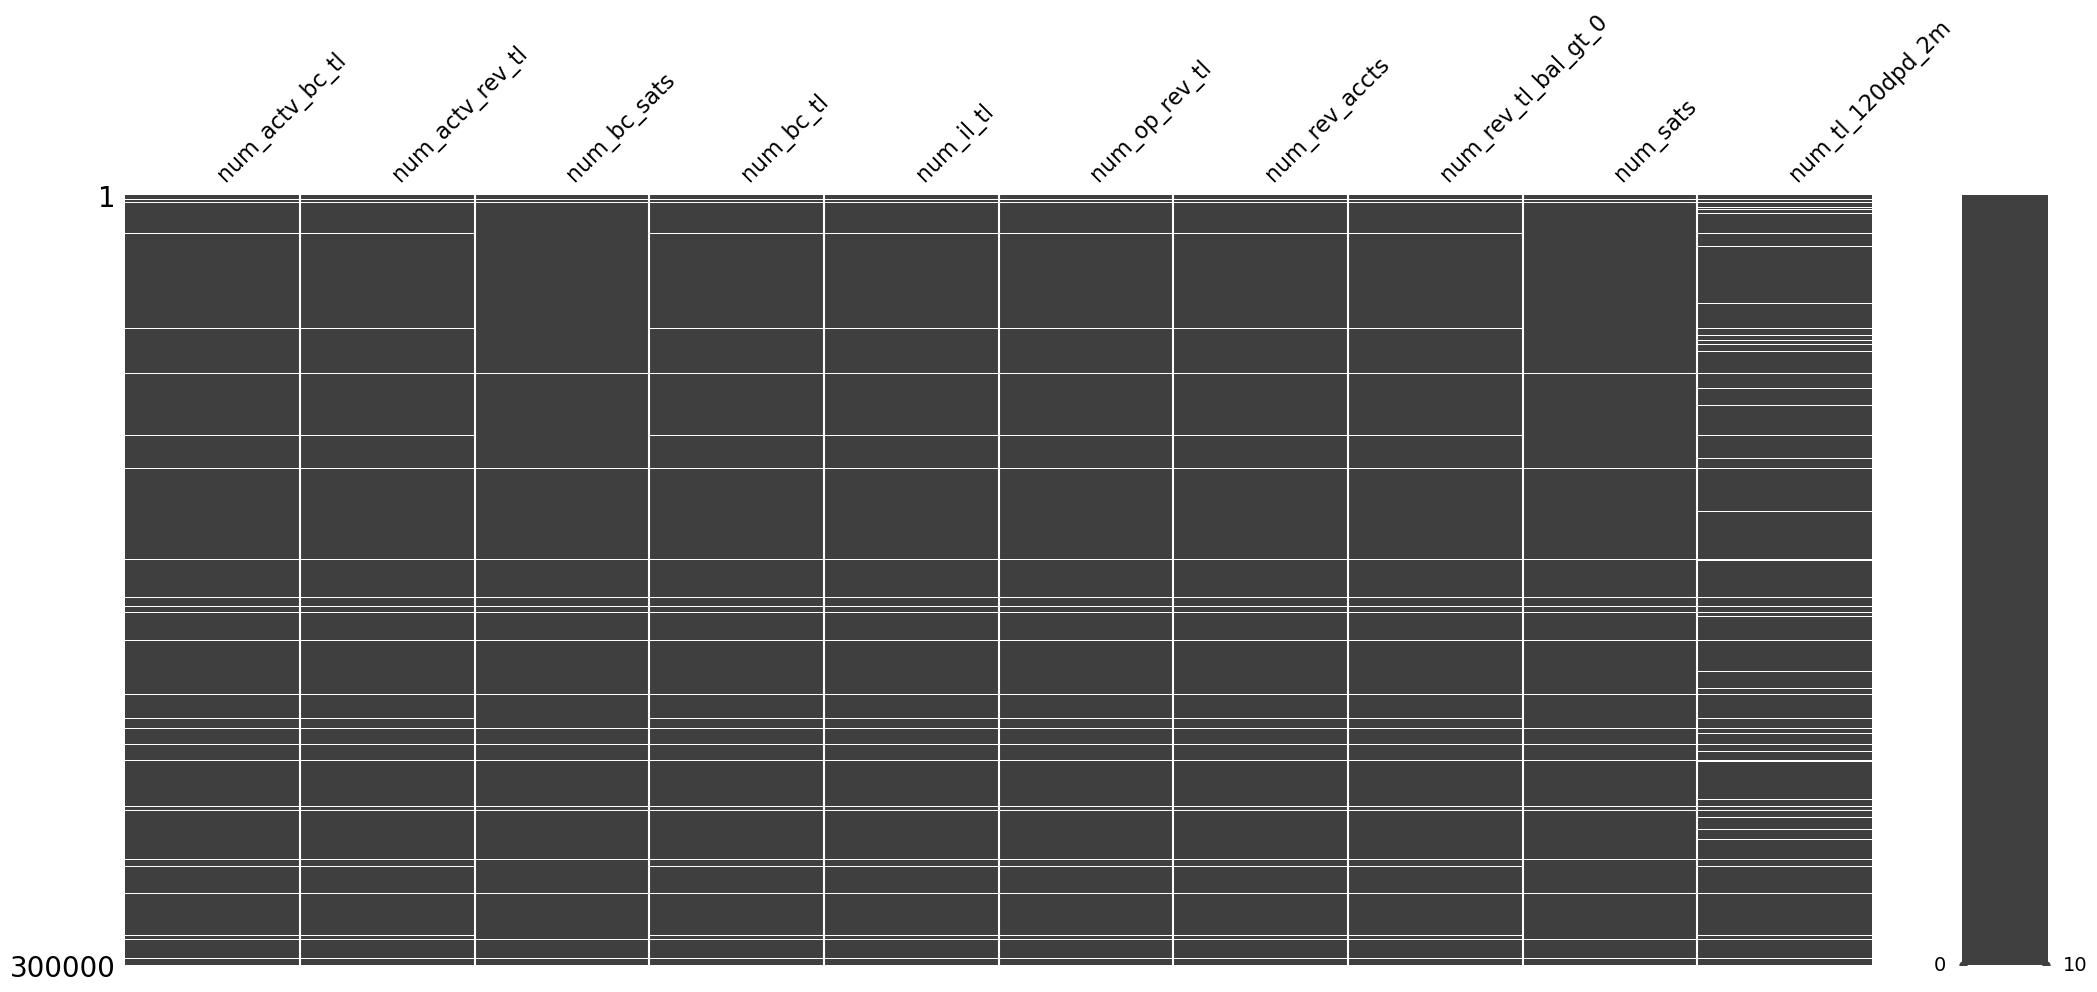

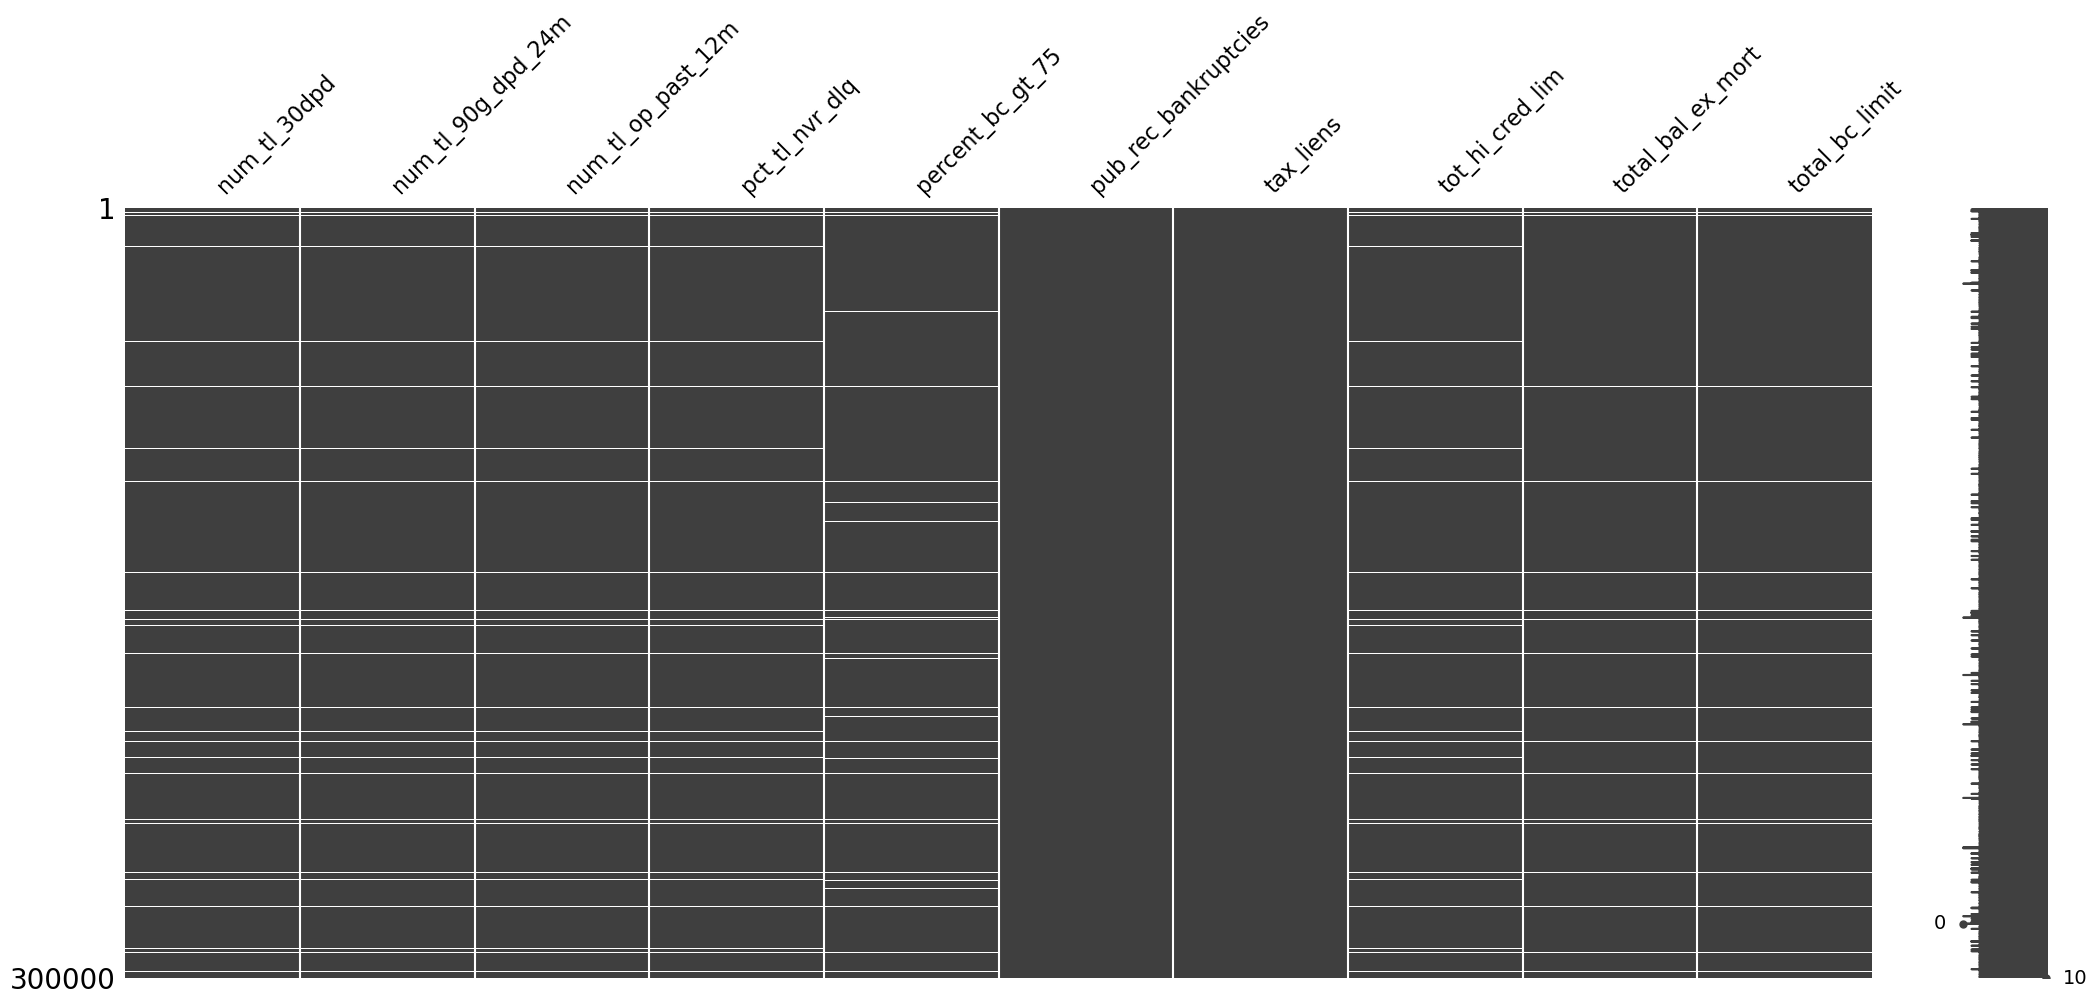

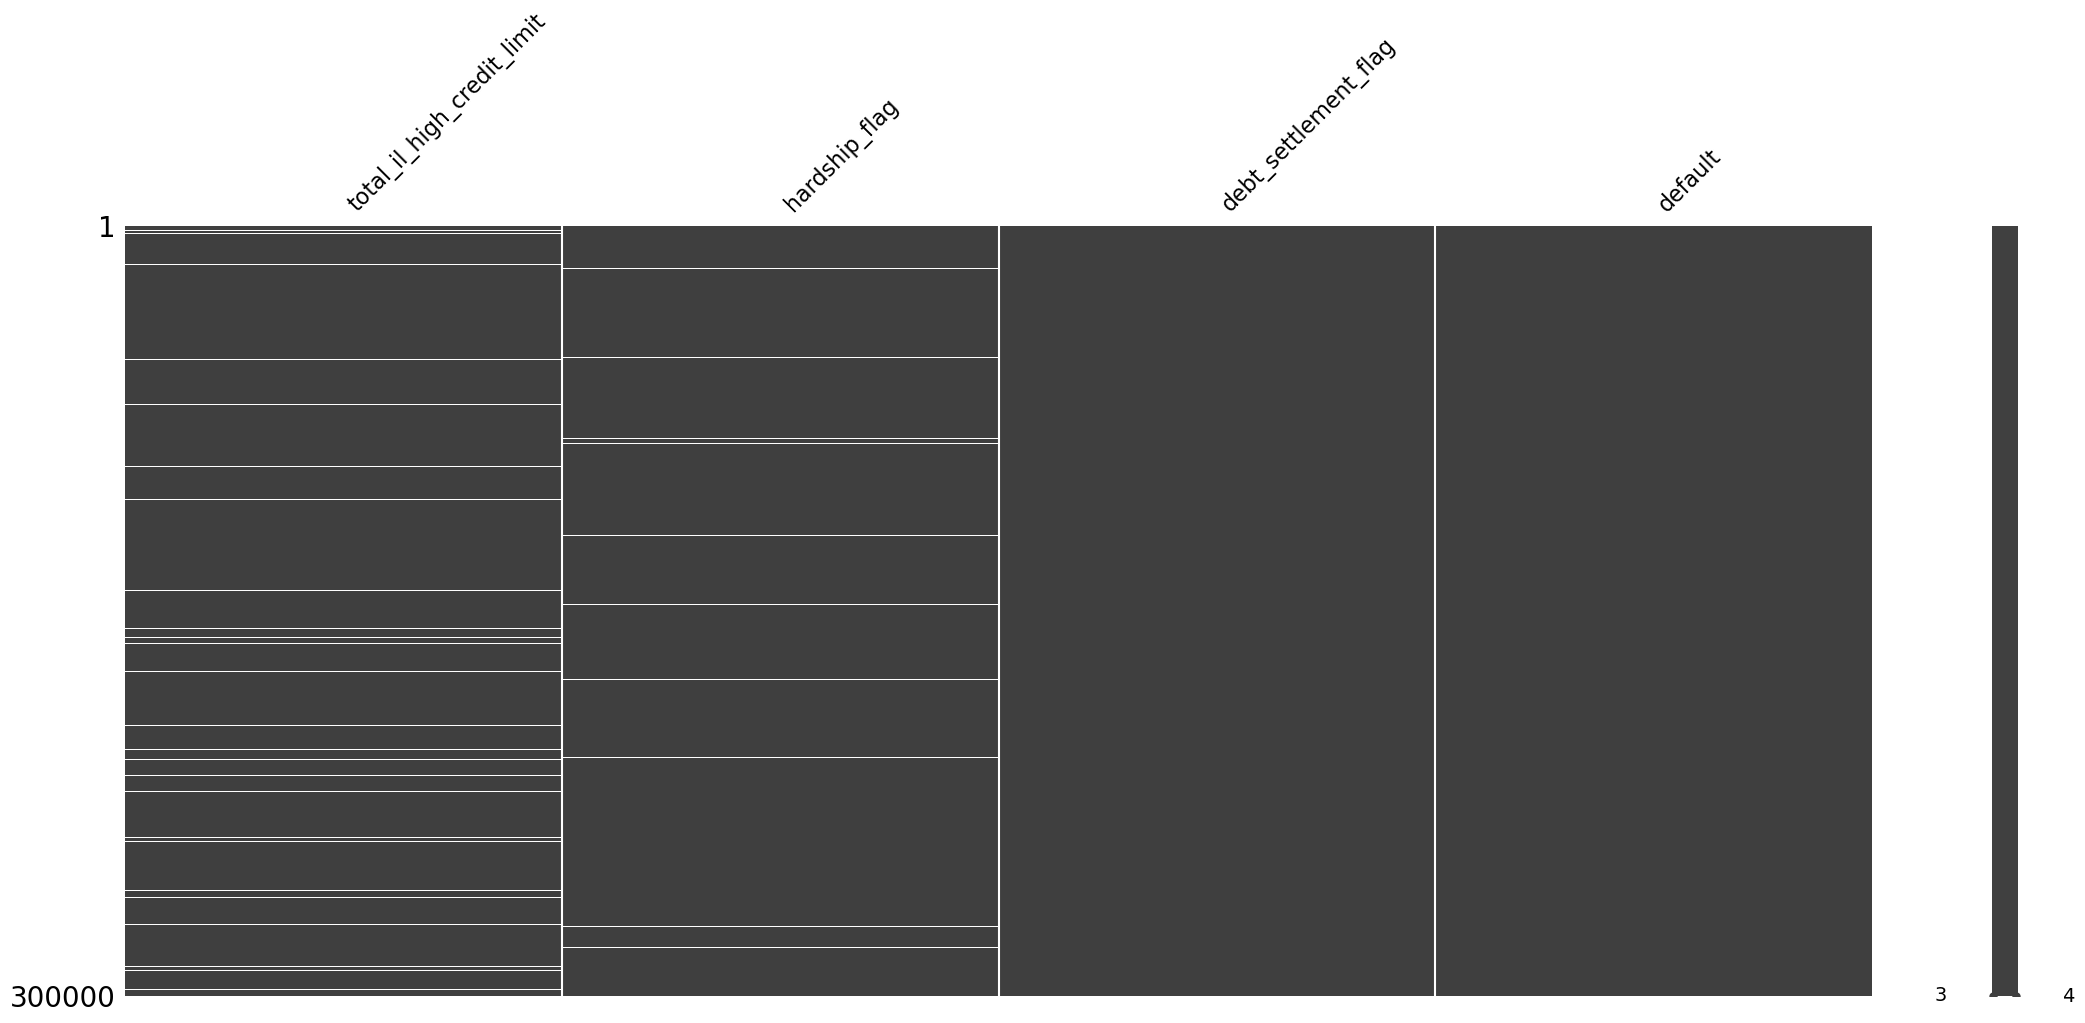

In [47]:
for chunk in list(partition(df.columns, 10)):
    msno.matrix(df.loc[:, chunk])
    plt.show()

# Transform and cull object-type series

In [15]:
df.term.value_counts()

term
 36 months    211299
 60 months     88701
Name: count, dtype: int64

In [48]:
df.select_dtypes(include='object').describe().swapaxes(0, 1)

,count,unique,top,freq
term,300000,2,36 months,211299
int_rate,300000,628,8.19%,6941
grade,300000,7,B,87742
sub_grade,300000,35,B4,18867
emp_title,272792,99126,Teacher,4998
emp_length,278810,11,10+ years,97321
home_ownership,300000,6,MORTGAGE,147668
verification_status,300000,3,Source Verified,117208
issue_d,300000,160,2016-03-01,6456
loan_status,300000,10,Fully Paid,153236


### Cull

In [49]:
# Series to cull from the start----
# id: contains no information.
# loan_status: this series has been converted into our target feature.
# url: contains no information.
# pymnt_plan: only 1 unique value. Will cause logistic regression to fail.
# emp_title: could contain information if we wanted to do a deep dive. However,
#            we are going to consider its over 500,000 unique values too noisy.
# title: Same as emp_title.
# zip_code: will introduce bias into model due to redlining and other historic factors.


cull_cols = ["id", "url", "pymnt_plan", "emp_title", "title", "zip_code"]
df.drop(labels=cull_cols, axis=1, inplace=True)

In [50]:
df.shape

(300000, 88)

## Convert to DateTime Objects

In [ ]:
# Convert date columns into datetime objects


for col in date_cols:
    df[col] = pd.to_datetime(df[col], format = "%b-%Y")
    
df.loc[:3, date_cols]

## Create Month and Year Columns

## Convert percentage strings to decimals

In [51]:
percent_cols = ["int_rate", "revol_util"]

for col in percent_cols:
    df[col] = df[col].str.replace('%', '').astype(float)/100

df.loc[:, percent_cols].head(2)

,int_rate,revol_util
0,0.1699,0.879
1,0.1399,0.870


### Variables to one-hot encode

In [17]:
# Binary Variables
temp = list(df.nunique().loc[df.nunique()==2].index)
df.nunique().loc[df.nunique()==2]

term                    2
initial_list_status     2
application_type        2
hardship_flag           2
debt_settlement_flag    2
default                 2
dtype: int64

In [18]:
for element in temp:
    print(df[element].value_counts(), "\n\n")

term
 36 months    211299
 60 months     88701
Name: count, dtype: int64 


initial_list_status
w    219457
f     80543
Name: count, dtype: int64 


application_type
Individual    278449
Joint App      21551
Name: count, dtype: int64 


hardship_flag
N    283508
Y     12544
Name: count, dtype: int64 


debt_settlement_flag
N    294719
Y      5281
Name: count, dtype: int64 


default
0    262361
1     37639
Name: count, dtype: int64 




In [53]:
 df.verification_status.value_counts(dropna=False)

verification_status
Source Verified    117208
Not Verified       109467
Verified            73325
Name: count, dtype: int64

In [54]:
success_rates(df, "verification_status")

{'Source Verified': 0.13, 'Not Verified': 0.08, 'Verified': 0.18}

In [ ]:
# Possible endogeneity issue with this feature. 
# Why is the default rate so much lower for the "Not Verified" class?
# I'm going to choose to drop the variable due to the increase in generalization error
# that may result from including it.

In [55]:
df.home_ownership.value_counts(dropna=False)

home_ownership
MORTGAGE    147668
RENT        117834
OWN          34115
ANY            354
OTHER           23
NONE             6
Name: count, dtype: int64

In [56]:
# Default rate by home_ownership category.
# A good bit of variation between categories. These will be separately encoded.
success_rates(df,"home_ownership")

{'MORTGAGE': 0.11,
 'RENT': 0.15,
 'OWN': 0.12,
 'ANY': 0.07,
 'OTHER': 0.13,
 'NONE': 0.33}

In [19]:
df.purpose.value_counts(dropna=False)

purpose
debt_consolidation    168199
credit_card            71277
home_improvement       19963
other                  17967
major_purchase          6353
medical                 3707
small_business          3047
car                     3010
vacation                2046
moving                  1966
house                   1960
wedding                  267
renewable_energy         193
educational               45
Name: count, dtype: int64

In [20]:
success_rates(df, "purpose")

{'debt_consolidation': 0.14,
 'credit_card': 0.1,
 'home_improvement': 0.12,
 'other': 0.13,
 'major_purchase': 0.12,
 'medical': 0.14,
 'small_business': 0.21,
 'car': 0.1,
 'vacation': 0.12,
 'moving': 0.15,
 'house': 0.13,
 'wedding': 0.16,
 'renewable_energy': 0.16,
 'educational': 0.2}

In [32]:
success_rates(df, "addr_state")

In [58]:
df.acc_now_delinq.value_counts(dropna=False)

acc_now_delinq
0.0    299114
1.0       837
2.0        43
3.0         2
NaN         2
4.0         1
6.0         1
Name: count, dtype: int64

In [59]:
df.home_ownership.value_counts()

home_ownership
MORTGAGE    147668
RENT        117834
OWN          34115
ANY            354
OTHER           23
NONE             6
Name: count, dtype: int64

In [ ]:
df["owns_home"] = np.where(df.home_ownership == "OWN", 1, 0)
df.owns_home.value_counts()

In [ ]:
df["grade"].value_counts(ascending=False)

# Examining other features

#### Past due account information

In [ ]:
# How many customers with an account 30 days past due were in default or charge-off? 1:4 ratio vs 1:7 in full sample.
df.loc[df['num_tl_30dpd'] > 0, "default"].value_counts()

In [ ]:
# How many customers with an account 120 days past due were in default or charge-off? 1:4 ratio
df.loc[df['num_tl_120dpd_2m'] > 0, "default"].value_counts()

In [ ]:
# Do these series provide overlapping information? No.
df.loc[df['num_tl_30dpd'] > 0, 'num_tl_120dpd_2m'].value_counts()


In [ ]:
# How many customers with an account 90 days past due were in default or charge-off? 1:6 ratio. Curious.
df.loc[df['num_tl_90g_dpd_24m'] > 0, "default"].value_counts()

#### Funded Amount information. Is it redundant?

In [ ]:
# Mostly.
fund_cols = ["funded_amnt", "funded_amnt_inv", "loan_amnt"]
df.loc[:, fund_cols].head()

In [ ]:
# For our quick analysis we'll call them all "close-enough" and just use "funded_amnt". 
# A deeper dive would be required in a high-stakes situation (Why is funded_amnt_inv min 0?)
df.loc[:, fund_cols].describe()

In [ ]:
df.loc[df['num_tl_30dpd'] > 0, "default"].value_counts()

In [ ]:
df.loc[df['num_tl_120dpd_2m'] > 0, "default"].value_counts()

In [ ]:
# How about the chargeoff_within_12_mths features?
df.loc[df['chargeoff_within_12_mths'] > 0, "default"].value_counts()

In [ ]:
# Number of derogatory public records
df.pub_rec.value_counts()

In [ ]:
# 1:5 default ratio vs full sample 1:7
df.loc[df['pub_rec'] > 0, "default"].value_counts()

### Grade vs subgrade

In [ ]:
df.grade.value_counts().sort_index()

In [ ]:
df.sub_grade.value_counts().sort_index()

In [ ]:
# Verify that the subgrades are appropriately binned.
# Cannot use both in a logistic regression.
temp = df.grade.value_counts().sort_index()
temp2 = df.sub_grade.value_counts().sort_index()
temp_df = pd.DataFrame(temp.copy())
sub_grade_sums = []

for i in temp.index:
    i_sum = 0
    for j in temp2.index:
        if j[0] == i:
            i_sum += temp2.loc[j]
    sub_grade_sums.append(i_sum)
temp_df["sub_grade_sums"] = sub_grade_sums
temp_df

### acct_now_delinq vs loan_status (target)

In [77]:
# ok to include acct_now_delinq, does not seem to result in information leakage.
df.loan_status.value_counts(normalize=True).round(3)

loan_status
Fully Paid                                             0.511
Current                                                0.353
Charged Off                                            0.125
Late (31-120 days)                                     0.006
In Grace Period                                        0.003
Late (16-30 days)                                      0.001
Does not meet the credit policy. Status:Fully Paid     0.001
Issued                                                 0.001
Does not meet the credit policy. Status:Charged Off    0.000
Default                                                0.000
Name: proportion, dtype: float64

In [78]:
df.loc[df.acc_now_delinq >0, "loan_status"].value_counts(normalize=True).round(3)

loan_status
Fully Paid                                            0.718
Charged Off                                           0.196
Current                                               0.081
In Grace Period                                       0.002
Late (31-120 days)                                    0.001
Does not meet the credit policy. Status:Fully Paid    0.001
Name: proportion, dtype: float64

### Include both pairs of fico_scores?

In [88]:
fico_cols = ["fico_range_high", "fico_range_low", "last_fico_range_high", "last_fico_range_low"]
df.loc[:, fico_cols].describe().round(2)

,fico_range_high,fico_range_low,last_fico_range_high,last_fico_range_low
count,300000.00,300000.00,300000.00,300000.00
mean,704.51,700.51,690.26,677.59
std,33.75,33.75,74.80,114.59
min,634.00,630.00,0.00,0.00
25%,679.00,675.00,654.00,650.00
50%,699.00,695.00,699.00,695.00
75%,724.00,720.00,739.00,735.00
max,850.00,845.00,850.00,845.00


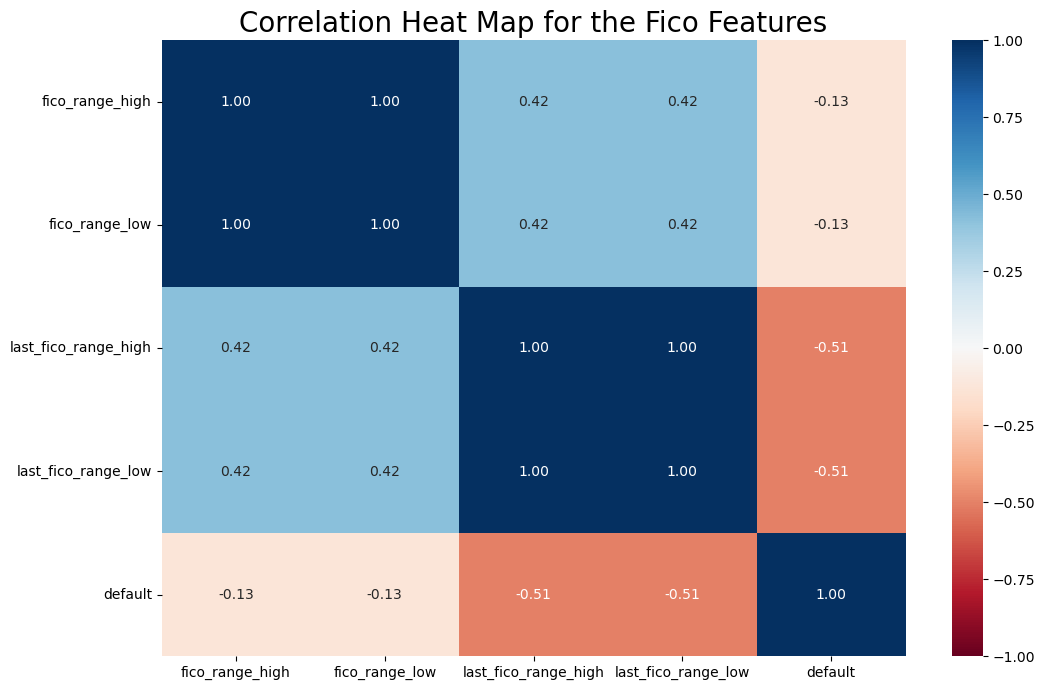

In [93]:
fico_cols2 = fico_cols + ["default"]
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df.loc[:, fico_cols2].corr(method="spearman"), 
            cmap = "RdBu", 
            annot=True, 
            fmt=".2f", 
            vmin=-1,
            vmax=1,
            ax=ax    
           )
plt.title("Correlation Heat Map for the Fico Features", fontsize=20)
plt.show()

In [ ]:
# Observing the correlation heatmap we can see some strong-to-perfect correlation between many of the features.
# We'll want to avoid using both values from a set, but will include one value from each set (high)

### Binary features

In [100]:
temp = list(df.nunique().loc[df.nunique()==2].index)
df.nunique().loc[df.nunique()==2]

term                    2
initial_list_status     2
application_type        2
hardship_flag           2
debt_settlement_flag    2
dtype: int64

In [101]:
for element in temp:
    print(df[element].value_counts(), "\n\n")

term
 36 months    211299
 60 months     88701
Name: count, dtype: int64 


initial_list_status
w    219457
f     80543
Name: count, dtype: int64 


application_type
Individual    278449
Joint App      21551
Name: count, dtype: int64 


hardship_flag
N    283508
Y     12544
Name: count, dtype: int64 


debt_settlement_flag
N    294719
Y      5281
Name: count, dtype: int64 




In [16]:
# Employment_Length
df.employment_length[:5]

AttributeError: 'DataFrame' object has no attribute 'employment_length'

In [ ]:
# Default values we'll set to 1:
# term: 36 months & NaN
# initial_list_status: w & NaN
# hardship_flag: 



In [ ]:
drop_cols = ["debt_settlement_flag", "debt_settlement_flag_date", "settlement_status", 
 "settlement_date", "settlement_amount", "settlement_percentage", 
 "settlement_term", "Unnamed: 0", 
 "num_accts_ever_120", "num_bc_sats", "num_bc_tl", 
 "num_rev_accts", "out_prncp", "out_prncp_inv", 
 "out_prncp_inv", "policy_code", "funded_amnt_inv", 
 "loan_amnt", "loan_status", "collection_recovery_fee", "last_credit_pull_d"]

In [69]:
# others to drop
drop_cols = ["debt_settlement_flag",   
 "Unnamed: 0", "loan_status", 'last_fico_range_low',
 "num_bc_sats", "num_bc_tl", 'fico_range_low',
 "num_rev_accts", "out_prncp", "out_prncp_inv", 
 "out_prncp_inv", "policy_code", "funded_amnt_inv", 
 "loan_amnt", "loan_status", "collection_recovery_fee", "last_credit_pull_d"]

df.drop(labels=drop_cols, axis=1).dropna().shape

(222603, 75)

In [71]:
sorted(df.columns)

['Unnamed: 0',
 'acc_now_delinq',
 'acc_open_past_24mths',
 'addr_state',
 'annual_inc',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'debt_settlement_flag',
 'default',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'earliest_cr_line',
 'emp_length',
 'fico_range_high',
 'fico_range_low',
 'funded_amnt',
 'funded_amnt_inv',
 'grade',
 'hardship_flag',
 'home_ownership',
 'initial_list_status',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'issue_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'last_pymnt_amnt',
 'last_pymnt_d',
 'loan_amnt',
 'loan_status',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_acc

In [ ]:
# total_b = {}
# for item in dir():
#     total_b[item] = int(round((getsizeof(eval(item))/1000000), 0))
# for item in total_b.items():
#     print(item)
#print(f"{sum(total_b)/1000000000} GB used. \nLargest item: {sorted(set(total_b))[-1]/1000000000} GB")